# Noise robustness of persistent homology on greyscale images, across filtrations and persistence signatures
  
  
Author: Renata Turkes, University of Antwerp  
Related article, turkevs2021noise: Renata Turkes, Jannes Nys, Tim Verdonck, Steven Latre, "Noise robustness of persistent homology on greyscale images, across filtrations and persistence signatures"


The goal of this notebook is to explore the robustness to noise of persistent homology (PH) on greyscale images, across different filtrations, persistence signatures and types of noise. The only input necessary for this notebook are variables:
- "data", a num_data_points x num_pixels numpy array, with each row representing the greyscale pixel values of an image
- "labels", a num_data_points x 1 numpy array, representing the data class for each image.



## 1) (Noisy) Datasets 

The notebook starts by calculating the variable "data_trnsf", which stores the given dataset under a number of affine and noisy transformations, e.g., data_trnsf["rotation 45"] corresponds to the given dataset under rotation. The definition of noise can easily be adjusted, or other types of noise can be considered.

The notebook then calculates persistent homology for every (non-noisy and noisy) image, using the following steps:
- PH1) Construct the input for persistent homology: Build a filtration (nested structured complexes) for each data point.
- PH2) Calculate persistent homology: Calculate persistence intervals (birth and death values of each cycle) for each data point.
- PH3) Construct the output of persistent homology: Represent the persistence intervals of each data point with a persistence signature.  

The persistent homology information is stored into a dictionary "data_sign_homdim_filt_trnsf", so that, e.g., data_sign_homdim_filt_trnsf["PL", "1-dim", "density", "rotation 45"] corresponds to the 1-dimensional persistence landscapes wrt density filtration on the given dataset under rotation. The definition of filtrations and signatures can easily be adjusted, or other filtrations and signatures can be considered.



## 2) Noise robustness

The goal of this section is to answer the following research question: 
> (RQ1) In what way, and to which degree, is the persistent homology information sensitive to noise, across different filtrations and persistence signatures?

The first part of this section is visually summarized with two figures (for 0-dim and 1-dim PH), which depict an example data point (image) under different types of transformations, together with the persistence homology information for each (non-noisy and noisy) image across different filtrations and persistence signatures. This figures helps to understand what noise does to an image, represented with its filtration functions, or persistent homology information.

The second part of this section is summarized with a table of average ($l_p$ or Wasserstein $W_p$) distances between non-noisy and noisy-images. The table helps to understand how much does the noisy image differ from the non-noisy image, represented with its filtration functions, or persistent homoology information (stability theorems).



## 3) Noise robustness and discriminative power

The goal of this section is to answer the following research question: 
> (RQ2) How discriminative is the persistent homology information with respect to different filtrations and signatures, on the dataset with noise, compared to the data with no noise?
  
This section is visually summarized with two boxplots (for 0-dim and 1-dim PH), with the accuracy of SVM trained on non-noisy and tested on noisy data on the y-axis, and different types of noise and different data representations on the x-axis. These figures help us understand how well does SVM classify the noisy images after training on non-noisy data, represented with filtration functions, or persistent homology information. We are less interested in the the absolute values of the SVM accuracy, but rather in the relative decrease of the accuracy for noisy compared to the non-noisy data, which enables us to assess noise robustness. Therefore, we also include a table which gives the drop in SVM accuracy.


The computation times of crucial steps are also stored.


Some interesting articles which employ persistent homology on images, or deal with definition or evaluation of invariance under affine or noise transformations:
- Garin et al, "A topological reading lesson: Classification of MNIST using TDA" (https://arxiv.org/pdf/1910.08345.pdf)   
- Obayashi et al, "Persistence diagrams with linear machine learning models" (https://link.springer.com/content/pdf/10.1007/s41468-018-0013-5.pdf)
- Ilyas et al, "Adversarial examples are not bugs, they are features" (https://arxiv.org/pdf/1905.02175.pdf)
- Goodfellow et al, "Explaining and harnessing adversarial examples" (https://arxiv.org/abs/1412.6572)
- Keras, "Image preprocessing" (https://keras.io/preprocessing/image/)
- Wikipedia, "Image noise" (https://en.wikipedia.org/wiki/Image_noise)

In [1]:
# pip install numpy keras tensorflow gudhi scikit-learn scikit-learn-extra matplotlib pillow pandas POT

import numpy as np # np.loadtxt(), np.sum(), np.max(), np.random.uniform(), etc.
import math # math.floor()

from keras.preprocessing.image import ImageDataGenerator # ImageDataGenerator()

import gudhi as gd # gd.CubicalComplex(), gd.RipsComplex(), gd.SimplexTree(), gd.persistence(), gd.persistence_intervals_in_dimension(), gd.bottleneck_distance()
from gudhi.weighted_rips_complex import WeightedRipsComplex
import gudhi.wasserstein
import gudhi.representations # gd.representations.Landscape(), gd.representations.PersistenceImage()
# other TDA libraries:
# import sklearn_tda # Mathieu Carriere, https://github.com/MathieuCarriere/sklearn-tda 
# import gtda # Guillaume Tauzin, Umberto Lupo, Kathryn Hess, https://github.com/giotto-ai/giotto-tda
# import teaspoon # Elizabeth Munch, https://github.com/lizliz/teaspoon
# import scikit-tda # Chris Trailie, https://github.com/scikit-tda
# import homcloud.interface as hc # Ippei Obayashi, http://www.wpi-aimr.tohoku.ac.jp/hiraoka_labo/homcloud/index.en.html

from sklearn import datasets # datasets.load_digits()
from sklearn.neighbors import KDTree
from sklearn.metrics.pairwise import euclidean_distances 
from sklearn.metrics import plot_confusion_matrix
from sklearn.base import BaseEstimator, TransformerMixin # class kernel_rbf(BaseEstimator, TransformerMixin)
from sklearn.svm import SVC 
from sklearn.pipeline import Pipeline 
from sklearn.model_selection import GridSearchCV
from sklearn.base import clone 
from tempfile import TemporaryDirectory

from scipy.spatial.distance import directed_hausdorff

import matplotlib.pyplot as plt # plt.matshow(), plt.scatter(), plt.hist(), etc.
%matplotlib inline

import time # time.time()
import pickle # pickle.dump(), pickle.load()
from numba import njit, prange # @njit(parallel = True), prange() 
from joblib import Parallel, delayed # Parallel(n_jobs = -1)(delayed(function)(arguments) for arguments in arguments_array)

## Auxiliary functions.

In the cells below, we define auxiliary functions from the above imported packages:
- for affine data transformations, from keras
- for noisy data transformations, from numpy
- for calculation of filtrations, from numpy
- for calculation of persistence, from gudhi
- for calculation of distances, from numpy
- for plotting, from matplotlib

For details on different steps in the TDA pipeline for persistent homology, see https://github.com/GUDHI/TDA-tutorial.  
For documentation on TDA functions from gudhi library, see: http://gudhi.gforge.inria.fr/doc/latest/.

In [2]:
def affine_transform(data, transform_params):
    '''
    Calculate the image under given affine transformation, for each image in the dataset.
    
    Input:
    data: a num_data_poins x num_pixels numpy array, with each row representing the greyscale pixel values of an image.
    transform_params: parameter for keras.preprocessing.image.ImageDataGenerator which defines the transformation,
    'theta': Float. Rotation angle in degrees.
    'tx': Float. Shift in the x direction.
    'ty': Float. Shift in the y direction.
    'shear': Float. Shear angle in degrees.
    'zx': Float. Zoom in the x direction.
    'zy': Float. Zoom in the y direction.abs
    'flip_horizontal': Boolean. Horizontal flip.
    'flip_vertical': Boolean. Vertical flip.
    'channel_shift_intensity': Float. Channel shift intensity.
    'brightness': Float. Brightness shift intensity.
    e.g., transform_parameters = {'theta':40, 'brightness':0.8, 'zx':0.9, 'zy':0.9}
    
    Output:
    data_trnsf: a num_data_poins x num_pixels numpy array, with each row representing the greyscale pixel values 
    of an image under transformation.
    '''
    num_data_points = data.shape[0] 
    num_pixels = data.shape[1] 
    num_x_pixels = np.sqrt(num_pixels).astype(int)
    num_y_pixels = num_x_pixels   
    data_images = data.reshape((num_data_points, num_x_pixels, num_y_pixels))    
    data_trnsf = np.zeros((num_data_points, num_pixels))    
    datagen = ImageDataGenerator()
    for p, image in enumerate(data_images):
        # We first need to represent each image as a num_x_pixels x num_y_pixels x 1 numpy array.
        image_3D_array = np.zeros((num_x_pixels, num_y_pixels, 1))
        for i in range(num_x_pixels):
            for j in range(num_x_pixels):
                image_3D_array[i][j] = [image[i][j]]
        # Next, we transform the image using keras.preprocessing.image import ImageDataGenerator.
        image_trnsf_3D_array = datagen.apply_transform(x = image_3D_array, transform_parameters = transform_params)
        # Finally, we represent the transformed image as a vector of length num_x_pixels x num_y_pixels.
        image_trnsf = np.zeros((num_x_pixels, num_y_pixels))
        for i in range(num_x_pixels):
            for j in range(num_y_pixels):
                image_trnsf[i][j] = image_trnsf_3D_array[i][j].item()
        data_point_trnsf = image_trnsf.reshape(num_pixels, )
        data_trnsf[p] = data_point_trnsf
    return data_trnsf


def gaussian_noise(data, noise_std_dev):
    '''
    Calculate the image under gaussian noise, for each image in the dataset.
    
    Input:
    data: a num_data_poins x num_pixels numpy array, with each row representing the greyscale pixel values of an image.
    noise_std_dev: a float, standard deviation of gaussian noise. Most of the values are within +-3std_dev from the mean 0.
    
    Output:
    data_gaussian_noise: a num_data_poins x num_pixels numpy array, with each row representing the greyscale pixel values 
    of an image under gaussian noise.
    '''
    data_gaussian_noise = np.zeros(data.shape)    
    for p, data_point in enumerate(data):
        # We apply noise to each image separately, as we want have noise_mean=0 and noise_std_dev for each image (row in data)
        # and not for this to be the mean and std dev for the whole 2D matrix data.
        gaussian_noise = np.random.normal(0, noise_std_dev, data_point.shape)
        data_point_gaussian_noise = data_point + gaussian_noise
        data_gaussian_noise[p] = data_point_gaussian_noise
    data_gaussian_noise = np.clip(data_gaussian_noise, np.min(data), np.max(data))
    return data_gaussian_noise


def salt_and_pepper_noise(data, proportion_noise_pixels):
    '''
    Calculate the image under salt and pepper noise, for each image in the dataset. 
    Salt and pepper noise changes the value of a given ratio of pixels, which are selected randomly, 
    to either salt (white) or pepper (black).
    
    Input:
    data: a num_data_poins x num_pixels numpy array, with each row representing the greyscale pixel values of an image.
    proportion_noise_pixels: a float, proportion of pixels to be changed.
    
    Output:
    data_sp_noise: a num_data_poins x num_pixels numpy array, with each row representing the greyscale pixel values 
    of an image under salt and pepper noise.    
    '''
    data_sp_noise = np.zeros(data.shape)    
    for p, data_point in enumerate(data):
        # Each pixel changes (pixel_chaned[i, j] = 1) with a given probability.
        pixel_changed = np.random.binomial(1, proportion_noise_pixels, data_point.shape)
        # The pixels which change, change equally likely to salt (white) or peper (black).      
        # For the MNIST images, it might be more reasonable to set the probability of changing to pepper as very large 
        # (e.g., 0.8), since it is only then that something changes for white pixels, which are in the large majority.
        sp_noise = np.random.binomial(1, 0.5, data_point.shape) * np.max(data)
        # if pixel_chaned[i][j] = 0
        # data_point_image_sp_noise[i][j] = 1 * data_point_image[i][j] + 0 * sp_noise = data_point_image[i][j]
        # if pixel_chaned[i][j] = 1
        # data_point_image_sp_noise[i][j] = 0 * data_point_image[i][j] + 1 * sp_noise = sp_noise[i][j]     
        data_point_sp_noise = (1 - pixel_changed)*data_point + pixel_changed*sp_noise       
        data_sp_noise[p] = data_point_sp_noise
    return data_sp_noise  
    
    
def shot_noise(data, pixel_scaling_factor):
    '''
    Calculate the image under shot noise, for each image in the dataset. 
    Shot noise has a root-mean-square value proportional to the square root of the image intensity, 
    and the noise at different pixels are independent of one another. Shot noise follows a Poisson distribution, 
    which except at very high intensity levels approximates a Gaussian distribution of only positive numbers.
    
    Input:
    data: a num_data_poins x num_pixels numpy array, with each row representing the greyscale pixel values of an image.
    pixel_scaling_factor: a float, level of noise.
    
    Output:
    data_shot_noise: a num_data_poins x num_pixels numpy array, with each row representing the greyscale pixel values 
    of an image under shot noise.    
    '''
    data_shot_noise = np.zeros(data.shape)   
    pixel_scaling_factor = 1 / pixel_scaling_factor 
    for p, data_point in enumerate(data):
        # The Poisson noise is signal dependent; it is not additive as Gaussian noise. 
        # Each new pixel is defined as a value which is drawn from a "normal" positive (i.e., Poisson) distribution
        # with distribution mean being the original pixel value. 
        data_point_shot_noise = np.random.poisson(data_point * pixel_scaling_factor) / float(pixel_scaling_factor) 
        data_shot_noise[p] = data_point_shot_noise
    data_shot_noise = np.clip(data_shot_noise, np.min(data), np.max(data))   
    return data_shot_noise

In [3]:
def binary_filtration_function(data, threshold_grsc_perc):
    '''
    Calculate the binary filtration function values for each image in the dataset. 
    
    Input:
    data: a num_data_poins x num_pixels numpy array, with each row representing the greyscale pixel values of an image.
    threshold_grsc_perc: a float in [0,1], representing the threshold greyscale value percentage to obtain the binary image.
    
    Output:
    filt_func_vals_data: a num_data_poins x num_pixels numpy array, with each row representing the values of the 
    binary filtration function on each pixel of an image.
    '''
    num_data_points = data.shape[0]
    num_pixels = data.shape[1]
    filt_func_vals_data = np.zeros((num_data_points, num_pixels))
    for p, data_point in enumerate(data): 
        filt_func_vals_data[p] = data_point > threshold_grsc_perc * np.max(data_point)
        # Pixels with the lowest filtration function values appear first in the filtration. 
        filt_func_vals_data[p] = 1 - filt_func_vals_data[p]
    return filt_func_vals_data    


def greyscale_filtration_function(data):
    '''
    Calculate the greyscale filtration function values for each image in the dataset. 
    
    Input:
    data: a num_data_poins x num_pixels numpy array, with each row representing the greyscale pixel values of an image.
    
    Output:
    filt_func_vals_data: a num_data_poins x num_pixels numpy array, with each row representing the values of the 
    greyscale filtration function on each pixel of an image.
    '''
    num_data_points = data.shape[0]
    num_pixels = data.shape[1]
    filt_func_vals_data = np.zeros((num_data_points, num_pixels))
    for p, data_point in enumerate(data):     
        # Pixels with the lowest filtration function values appear first in the filtration. 
        filt_func_vals_data[p] = np.max(data_point) - data_point        
    return filt_func_vals_data    


def density_filtration_function(data, threshold_grsc_perc, max_dist):  
    '''
    Calculate the density filtration function values for each image in the dataset. 
    Density filtration function counts the number of dark-enough pixels in an image, within a given distance.
    
    Input:
    data: a num_data_poins x num_pixels numpy array, with each row representing the greyscale pixel values of an image.
    threshold_grsc_perc: a float in [0,1], representing the threshold greyscale value percentage to obtain the binary image.
    max_dist: a non-negative integer, representing the size of the considered neighborhood for each pixel in an image.
    
    Output:
    filt_func_vals_data: a num_data_poins x num_pixels numpy array, with each row representing the values of the 
    density filtration function on each pixel of an image.
    '''
    num_data_points = data.shape[0]
    num_x_pixels = np.sqrt(data.shape[1]).astype(int)
    num_y_pixels = num_x_pixels
    filt_func_vals_data = np.zeros((num_data_points, num_x_pixels * num_y_pixels))    
    point_cloud_complete = np.zeros((num_x_pixels * num_y_pixels, 2))
    p = 0
    for i in range(num_x_pixels):
        for j in range(num_y_pixels):
            point_cloud_complete[p, 0] = j
            point_cloud_complete[p, 1] = num_y_pixels - i
            p = p + 1            
    for p, data_point in enumerate(data): 
        point_cloud = build_point_cloud(data_point, threshold_grsc_perc)        
        kdt = KDTree(point_cloud, leaf_size = 30, metric = "euclidean") 
        num_nbhs = kdt.query_radius(point_cloud_complete, r = max_dist, count_only = True)
        filt_func_vals = num_nbhs
        max_num_nbhs = 2 * max_dist**2 + 2 * max_dist + 1 # num of pixels in euclidean ball with radius max_dist
        filt_func_vals = max_num_nbhs - filt_func_vals
        # Cut-off density value (so that density does not also reflect the size of the hole).
        # max_filt_func_val = np.max(filt_func_vals)
        # filt_func_vals[filt_func_vals > 0.65 * max_filt_func_val] = max_filt_func_val # 0.4 in carriere2018statistical  
        filt_func_vals_data[p] = filt_func_vals         
    return filt_func_vals_data


def radial_filtration_function(data, threshold_grsc_perc, x_pixel, y_pixel):  
    '''
    Calculate the radial filtration function values for each image in the dataset.
    Radial filtration function corresponds to the distance from a given reference pixel.
    
    Input:
    data: a num_data_poins x num_pixels numpy array, with each row representing the greyscale pixel values of an image.
    threshold_grsc_perc: a float in [0,1], representing the threshold greyscale value percentage to obtain the binary image.
    x_pixel, y_pixel: integers, coordinates of the reference pixel.
    
    Output:
    filt_func_vals_data: a num_data_poins x num_pixels numpy array, with each row representing the values of the 
    radial filtration function on each pixel of an image.
    '''
    num_data_points = data.shape[0]
    num_x_pixels = np.sqrt(data.shape[1]).astype(int)
    num_y_pixels = num_x_pixels    
    filt_func_vals_data = np.zeros((num_data_points, num_x_pixels * num_y_pixels))
    for p, data_point in enumerate(data):                   
        image = data_point.reshape((num_x_pixels, num_y_pixels))    
        binary_image = image >= threshold_grsc_perc * np.max(image)         
        filt_func_vals = np.zeros((num_x_pixels, num_y_pixels))
        point_reference = np.array([x_pixel, y_pixel])
        for i in range(num_x_pixels):
            for j in range(num_y_pixels):
                point = np.array([i, j])
                filt_func_vals[i, j] = np.linalg.norm(point - point_reference, ord = 2)  
                # filt_func_vals[i, j] = np.inner(point, point_reference)   
        filt_func_vals[binary_image == 0] = np.max(filt_func_vals)                    
        filt_func_vals_data[p] = filt_func_vals.reshape((num_x_pixels * num_y_pixels, ))                 
    return filt_func_vals_data


def build_point_cloud(data_point, threshold_grsc_perc): 
    '''
    Calculate the point cloud from an image, which sees a point cloud point for any pixel with the
    greyscale value above the given threshold.
    
    Input:
    data_point: a num_pixels x 1 numpy array, representing the greyscale pixel values of an image.
    threshold_grsc_perc: a float in [0,1], representing the threshold greyscale value percentage to obtain the binary image.
    
    Output:
    point_cloud: a num_black_pixels_data_point x 2 numpy array, x and y coordinates of each point cloud point.
    '''    
    num_x_pixels = np.sqrt(data_point.shape[0]).astype(int)
    num_y_pixels = num_x_pixels     
    image = data_point.reshape((num_x_pixels, num_y_pixels))    
    binary_image = image >= threshold_grsc_perc * np.max(image)          
    num_black_pixels = np.sum(binary_image) 
    point_cloud = np.zeros((num_black_pixels, 2))
    point = 0        
    for i in range(num_x_pixels):
        for j in range(num_y_pixels):
            if binary_image[i, j] > 0:
                point_cloud[point, 0] = j
                point_cloud[point, 1] = num_y_pixels - i
                point = point + 1        
    return point_cloud


def distance_filtration_function(data, threshold_grsc_perc):
    '''
    Calculate the Rips filtration (i.e., empirical distance) function values for a point cloud, obtained from each image in the dataset. 
    Rips filtration function corresponds to the distance to the closest dark-enough pixel.
    
    Input:
    data: a num_data_poins x num_pixels numpy array, with each row representing the greyscale pixel values of an image.
    threshold_grsc_perc: a float in [0,1], representing the threshold greyscale value percentage to obtain the binary image.
    
    Output:
    filt_func_vals_data: a num_data_poins x num_pixels numpy array, with each row representing the values of the 
    Rips filtration function on discretized R^d.
    '''      
    return dtm_filtration_function(data, threshold_grsc_perc, 0)


def dtm_filtration_function(data, threshold_grsc_perc, m):          
    '''
    Compute the DTM filtration function values (with exponent p=2) of the empirical measure of a point cloud, obtained from each image in the dataset. 
    DTM filtration function corresponds to the average distance to some of the closest dark-enough pixels.
    This is an adaption from DTM implementation available at: 
    https://github.com/GUDHI/TDA-tutorial/blob/master/DTM_filtrations.py (from Anai et al, DTM-based filtrations).
    
    Input:
    data: a num_data_poins x num_pixels numpy array, with each row representing the greyscale pixel values of an image.
    threshold_grsc_perc: a float in [0,1], representing the threshold greyscale value percentage to obtain the binary image.
    m: a float in [0, 1] reflecting the number of neighbors to be considered for each point in point cloud.
    
    Output:
    filt_func_vals_data: a num_data_poins x num_pixels numpy array, with each row representing the values of the 
    DTM filtration function on discretized R^d.
    '''      
    num_data_points = data.shape[0]
    num_x_pixels = np.sqrt(data.shape[1]).astype(int)
    num_y_pixels = num_x_pixels    
    filt_func_vals_data = np.zeros((num_data_points, num_x_pixels * num_y_pixels))    
    point_cloud_complete = np.zeros((num_x_pixels * num_y_pixels, 2))
    p = 0
    for i in range(num_x_pixels):
        for j in range(num_y_pixels):
            point_cloud_complete[p, 0] = j
            point_cloud_complete[p, 1] = num_y_pixels - i
            p = p + 1    
    for p, data_point in enumerate(data):    
        point_cloud = build_point_cloud(data_point, threshold_grsc_perc)        
        kdt = KDTree(point_cloud, leaf_size = 30, metric = "euclidean")         
        num_points = point_cloud.shape[0]
        num_nbhs = math.floor(m * num_points) + 1
        dists_to_nbhs, _ = kdt.query(point_cloud_complete, num_nbhs, return_distance = True)  
        filt_func_vals = np.sqrt(np.sum(dists_to_nbhs*dists_to_nbhs, axis = 1) / num_nbhs) 
        # Cut-off DTM value, as in carriere2018statistical. No, because in this case DTM does not capture size of hole.
        # max_filt_func_val = np.max(filt_func_vals)
        # filt_func_vals[filt_func_vals > 0.5 * max_filt_func_val] = max_filt_func_val
        filt_func_vals_data[p] = filt_func_vals  
    return filt_func_vals_data

In [4]:
def pers_intervals_across_homdims(filt_func_vals_data, filt = " ", data = [], threshold_grsc_perc = 0.5):
    '''
    Compute persistent homology with respect to the given filtration for each filtration in the dataset.   
    
    Input:
    > filt_func_vals_data: a num_data_points x num_pixels numpy array, with each row representing the filtration function 
    values on each pixel/cell in discretized R^2.
    > filt: a string that determines the choice of filtration.
    
    Persistent homology is calculated on a filtration, but for the PH calculated with respect to simplicial complexes built on point clouds, 
    GUDHI implementation requires the point cloud itself, in order to calculate the distances between point cloud points which determine 
    when an edge appears in the filtration. The additional parameters that are needed for the calculation of persistent homology
    on point clouds are the following:    
    > data: a num_data_points x num_pixels numpy array, with each row representing the greyscale pixel values of an image.
    > threshold_grsc_perc: a float in [0, 1], representing the threshold greyscale value percentage used to build a point cloud from image.
    
    Output:
    > pers_intervals_homdim0_data: list of persistence intervals (b, d) corresponding to 0-dim cycles (connected components).
    > pers_intervals_homdim1_data: list of persistence intervals (b, d) corresponding to 0-dim cycles (holes).
    '''    
    pers_intervals_homdim0_data = []
    pers_intervals_homdim1_data = []   

    for i, filt_func_vals_data_point in enumerate(filt_func_vals_data):   
        
        if(filt == "Rips"):
            data_point = data[i]
            point_cloud = build_point_cloud(data_point, threshold_grsc_perc)
            simplicial_complex = gd.RipsComplex(points = point_cloud, max_edge_length = np.inf)
            simplex_tree = simplicial_complex.create_simplex_tree(max_dimension = 2)  
        
        elif(filt == "DTM"):          
            data_point = data[i]
            point_cloud = build_point_cloud(data_point, threshold_grsc_perc)               
            # To build a weighted simplex tree, we need:
            # 1) distance matrix between point cloud points
            distance_matrix = euclidean_distances(point_cloud)
            # 2) (one half of) weight, i.e., filtration function value for each point cloud point
            num_points = point_cloud.shape[0]
            filt_func_vals_point_cloud = np.zeros(num_points)
            num_x_pixels = np.sqrt(filt_func_vals_data.shape[1]).astype(int) 
            num_y_pixels = num_x_pixels
            filt_func_vals_data_point = np.copy(filt_func_vals_data_point).reshape((num_x_pixels, num_y_pixels))            
            # In build point cloud, image -> point cloud: x = j, y = num_y_pixels - i,
            # so that an inverse transformation is necessary here: j = x, i = num_y_pixels - y.                
            for p, point in enumerate(point_cloud):  
                i = num_y_pixels - point[1].astype(int)
                j = point[0].astype(int)
                filt_func_vals_point_cloud[p] = filt_func_vals_data_point[i, j]               
            simplicial_complex = WeightedRipsComplex(distance_matrix = distance_matrix, weights = filt_func_vals_point_cloud, max_filtration = np.inf)  
            simplex_tree = simplicial_complex.create_simplex_tree(max_dimension = 2)
        
        else:                       
            num_x_pixels = np.sqrt(filt_func_vals_data.shape[1]).astype(int) 
            num_y_pixels = num_x_pixels
            simplicial_complex = gd.CubicalComplex(dimensions = [num_x_pixels, num_y_pixels], 
                                                   top_dimensional_cells = filt_func_vals_data_point) 
            simplex_tree = simplicial_complex # CubicalComplex is similar to simplex tree

        homdims_pers_intervals = simplex_tree.persistence() # needs to be called before persistence_intervals_in_dimension()           
        pers_intervals_homdim0 = simplex_tree.persistence_intervals_in_dimension(0)
        pers_intervals_homdim1 = simplex_tree.persistence_intervals_in_dimension(1)        
       
        # If the list of persistence intervals is empty, gd.representations.PersistenceImage().fit_transfrom()
        # returns an error. Therefore, we replace such lists with [[0, 0]], and this has no influence on the 
        # calculation of Wasserstein distances.
        if(len(pers_intervals_homdim0) == 0):
            pers_intervals_homdim0 = np.asarray([[0, 0]])
        if(len(pers_intervals_homdim1) == 0):
            pers_intervals_homdim1 = np.asarray([[0, 0]])    

        pers_intervals_homdim0_data.append(pers_intervals_homdim0)
        pers_intervals_homdim1_data.append(pers_intervals_homdim1)

    return pers_intervals_homdim0_data, pers_intervals_homdim1_data

In [5]:
def l_p_distances(data_1, data_2, p):
    '''
    Calculate l_p distance between an image in one dataset, and the corresponding image in the other dataset.
    
    Input:
    > data_1, data_2: a num_data_points x num_pixels numpy array, with each row representing the greyscale pixel values of an image.
    > p: a float in [1, \infty], reflecting the choice of l_p metric.
    
    Output:
    > dists_data_1_2: a num_data_points x 1 array, with each row representing the the distance between an image in data_1
    and the corresponding image (in the same row) in data_2.
    ''' 
    num_data_points = data_1.shape[0]
    dists_data_1_2 = np.zeros((num_data_points, ))
    for i in range(num_data_points):
        dists_data_1_2[i] = np.linalg.norm(data_1[i] - data_2[i], ord = p)
    return dists_data_1_2


def wasserstein_p_q_distances(pers_intervals_homdim_data_1, pers_intervals_homdim_data_2, p, q):
    '''
    Calculate Wasserstein_p_g distance between an persistence diagram in one dataset, and the corresponding 
    persistence diagram in the other dataset.
    
    Input:
    > pers_intervals_homdim_data_1, pers_intervals_homdim_data_2: lists of num_data_points elements, 
    each a num_cycles x 2 numpy array of birth and death values for each cycle in the given homological dimension
    (a persistence diagram).
    > p, q: floats in [1, \infty], reflecting the choice of Wasserstein_p_q metric.
    
    Output:
    > dists_pers_intervals_homdim_data_1_2: a num_data_points x 1 array, with each row representing the the distance 
    between a persistence diagram in pers_intervals_homdim_data_1 and the corresponding persistence diagram (in the same row)
    in pers_intervals_homdim_data_2.
    ''' 
    num_data_points = len(pers_intervals_homdim_data_1)
    dist_pers_intervals_homdim_data_1_2 = np.zeros((num_data_points, ))
    for i in range(num_data_points):
        if p == np.inf:
            dist_pers_intervals_homdim_data_1_2[i] = gd.bottleneck_distance(pers_intervals_homdim_data_1[i], 
                                                                            pers_intervals_homdim_data_2[i], e = 0)
        else:
            dist_pers_intervals_homdim_data_1_2[i] = gudhi.wasserstein.wasserstein_distance(pers_intervals_homdim_data_1[i], 
                                                                                            pers_intervals_homdim_data_2[i], 
                                                                                            order = p, internal_p = q)
    return dist_pers_intervals_homdim_data_1_2


@njit(parallel = True)
def l_p_distance_matrix(data, p):
    '''
    Calculate l_p distance between any two images in the given dataset.
    
    Input:
    > data: a num_data_points x num_pixels numpy array, with each row representing the greyscale pixel values of an image.
    > p: a float in [1, \infty], reflecting the choice of l_p metric.
    
    Output:
    > distance_matrix_data: a num_data_points x num_data_point numpy array, with each element corresponding to the distance
    between two images.    
    ''' 
    num_data_points = len(data)
    distance_matrix_data = np.zeros((num_data_points, num_data_points))
    for i in prange(num_data_points):
        for j in prange(i):
            distance_matrix_data[i, j] = np.linalg.norm(data[i] - data[j], ord = p)
    # Distance matrix elements above the diagonal.
    distance_matrix_data =  distance_matrix_data + distance_matrix_data.transpose()
    return distance_matrix_data


def wasserstein_p_q_distance_matrix(pers_intervals_homdim, p, q):
    '''
    Calculate the Wasserstein W_p_q distance between any two persistence diagrams in the given dataset.
    
    Input:
    > pers_intervals_homdim: a list of num_data_points elements, each a num_cycles x 2 numpy array of birth and death
    values for each cycle in the given homological dimension.
    > p, q: floats in [1, \infty], reflecting the choice of Wasserstein_p_q metric.
    
    Output:
    > distance_matrix_data: a num_data_points x num_data_point numpy array, with each element corresponding to the distance
    between two persistence diagrams.    
    ''' 
    num_data_points = len(pers_intervals_homdim)
    distance_matrix_homdim = np.zeros((num_data_points, num_data_points))
    for i in range(num_data_points):
        for j in range(i):
            if p == np.inf:
                distance_matrix_homdim[i, j] = gd.bottleneck_distance(pers_intervals_homdim[i], pers_intervals_homdim[j], e = 0) # e=0?
            else:
                distance_matrix_homdim[i, j] = gudhi.wasserstein.wasserstein_distance(pers_intervals_homdim[i], 
                                                                                      pers_intervals_homdim[j], 
                                                                                      order = p, internal_p = q)
    # Distance matrix elements above the diagonal.
    distance_matrix_homdim = distance_matrix_homdim + distance_matrix_homdim.transpose()
    return distance_matrix_homdim

In [6]:
def plot_image(image, vmin, vmax, axes):
    '''
    Plot the given image.
    
    Input:
    > image: a num_x_pixels x num_y_pixels numpy array.
    > vmin, vmax: mininum and maximum pixel value.
    > axes: an object of class Axes, axes to plot the image.  
    ''' 
    axes.matshow(image, cmap = plt.cm.gray_r, vmin = vmin, vmax = vmax)
    axes.set_xticks([])
    axes.set_yticks([])
    axes.set_xticklabels([])
    axes.set_yticklabels([])

    
def plot_PD(PD, xymax, axes):    
    '''
    Plot the given persistence diagram (PD).
    
    Input:
    > PD: a num_cycles x 2 numpy array of birth and death values for each cycle, i.e., a persistence diagram (PD).
    > xymax: a positive float, maximum value of the plot x and y axis.
    > axes: an object of class Axes, axes to plot the PD.  
    ''' 
    axes.scatter(PD[:, 0], PD[:, 1], 80, c = "green")
    axes.set_aspect(aspect = 'equal')
    axes.set_xlim(-0.05 * xymax, 1.1 * xymax)
    axes.set_ylim(-0.05 * xymax, 1.1 * xymax)
    x = np.arange(-0.05 * xymax, 1.1 * xymax, 0.01)
    axes.plot(x, x, c = 'black') # plot the diagonal    
    intervals_unique, multiplicities = np.unique(PD, axis = 0, return_counts = True) 
    for i, multiplicity in enumerate(multiplicities):
        if multiplicity > 1: # Annotate a persistence interval/PD point only if it appears multiple times, for visual clarity.
            axes.annotate(multiplicity, xy = (intervals_unique[i, 0], intervals_unique[i, 1]), ha = "left", va = "bottom",
                          xytext = (5, 0), textcoords = "offset points", fontsize = 15, color = "green")    
    # axes.set_xticks([])
    # axes.set_yticks([])
    # axes.set_xticklabels([])
    # axes.set_yticklabels([])
    
    
def plot_PL(PL, num_lndscs, lndsc_resolution, ymax, axes):
    '''
    Plot the given persistence landscape (PL).
    
    Input:
    > PL: a num_lndscs x lndsc_resolution x 1 numpy array, a persistence landscape (PL).
    > num_lndscs: a natural number, number of different landscape functions.
    > lndsc_resolution: a natural number, number of equidistant point that the landscape function is evaluated on to obtain
    the vectorized persistence landscape.
    > ymax: a positive float, maximum value of the plot y-axis.
    > axes: an object of class Axes, axes to plot the PL.  
    ''' 
    cmap = plt.get_cmap('Dark2')
    for i in range(num_lndscs):
        axes.plot(PL[i*lndsc_resolution : (i+1)*lndsc_resolution], linewidth = 5, c = cmap.colors[i % 8]) # Only 8 colors in Dark2 colormap.
        axes.set_ylim(0, 1.1 * ymax) 
    # axes.set_xticks([])
    # axes.set_yticks([])
    # axes.set_xticklabels([])
    # axes.set_yticklabels([])
        

def plot_PI(PI, pers_image_resolution, vmin, vmax, axes):
    '''
    Plot the given persistence image (PI).
    
    Input:
    > PI: a PI_resolution*PI_resolution x 1 numpy array, a persistence image (PI).
    > PI_resolution: a natural number, resolution of the persistence image.
    > lndsc_resolution: a natural number, number of equidistant point that the landscape function is evaluated on to obtain
    the vectorized persistence landscape.
    > vmin, vmax: mininum and maximum pixel value.
    > axes: an object of class Axes, axes to plot the image.  
    ''' 
    plot_image(np.flip(PI.reshape((pers_image_resolution, pers_image_resolution)), 0), vmin = vmin, vmax = vmax, axes = axes)


def plot_bar_containers(x_ticks_labels, y_values_per_bar_container, legend_labels):  
    '''
    Plot the grouped bar chart with given values.
    
    Input:
    > x_tick_labels: a list of string labels on the x-axis.
    > y_values_per_bar_container: a dictionary, with each element being a list of y-axis values for a specific 
    group/color/legend item.
    > legend labels: a list of string legend labels.
    ''' 
    num_x_ticks = len(x_ticks_labels) 
    x_ticks = np.arange(num_x_ticks)      
    num_bars_per_x_tick = len(y_values_per_bar_container) # = len(legend_labels)   
    width_bar = 0.65 * 1/num_bars_per_x_tick
    width_from_x_tick = np.arange(num_bars_per_x_tick) - np.floor(num_bars_per_x_tick/2)  # (..., -3, -2, -1, 0, 1, 2, 3, ...)
    fig, axes = plt.subplots(figsize = (20, 7)) 
    cmap = plt.get_cmap('tab20') # we have two levels of each type of noise
    bar_colors = ["black"] + [cmap.colors[t] for t in range(16)] # no-noise and two levels of 8 trnsfs     
    for t, legend_label in enumerate(legend_labels):    
        axes.bar(x_ticks + width_from_x_tick[t] * width_bar, y_values_per_bar_container[legend_label], width_bar, 
                 label = legend_label, color = bar_colors[t])        
    axes.set_xticks(x_ticks)
    axes.set_xticklabels(x_ticks_labels, fontsize = 10)
    axes.set_axisbelow(True)
    return fig, axes

## 1) (Noisy) Datasets

This notebook relies on a labeled dataset of greyscale images, stored in two variables:
- $\color{blue}{\text{data}},$ a num_data_points x num_pixels numpy array, with each row representing the greyscale pixel values of an image.
- $\color{blue}{\text{labels}},$ a num_data_points x 1 numpy array, with each row representing the label of an image.  

It is easy to calculate the following variables:
- min_data
- max_data
- num_data_points
- num_x_pixels
- num_y_pixels
- num_pixels
- data_images = a num_data_points x num_x_pixels x num_y_pixels numpy array,  

that will be used throughout the notebook.

For the given dataset of greyscale images, we consider a few most common types of noise to be expected, three types of affine, three types of noisy transformations, change in image brightness and contrast, each at two different levels. The (noisy) datasets are stored in the dictionary:
- $\color{red}{\text{data_trnsf}}.$ 

We are interested in computing the persistent homology for each (non-noisy and noisy) image in data_trnsf. The input for persistent homology is a filtration, so we first calculate the filtration function values across different filtrations, stored in the dictionary:
- $\color{red}{\text{data_filt_trnsf}}.$  

Finally, we calculate a number of different persistence signatures for each of the filtrations, stored in the dictionary:
- $\color{red}{\text{data_sign_homdim_filt_trnsf}}.$  


Some of the elements in these dictionaries are:  
- data_filt_trnsf["grsc", "rotation 45"] = num_data_points x num_pixels numpy array, dataset of images under rotation, represented with a vector of its greyscale filtration function values
- data_sign_filt_homdim_trnsf["PD", "0-dim", "density", "rotation 45"] = list of num_data_points, dataset of images under rotation, represented with its 0-dim persistent diagram (list of persistence intervals) wrt density filtration  
- data_sign_filt_homdim_trnsf["PL", "0-dim", "density", "rotation 45"] = num_data_points x (num_lndscs * lndsc_resolution) numpy array, dataset of images under rotation, represented with its 0-dim persistent landscape (a vector) wrt density filtration.  

In [7]:
start_time = time.time()

In [8]:
# Store variables "data" and "labels".
# Here we import the MNIST dataset consisting of 70000 28x28 greyscale images of handwritten digits,
# which can be replaced with any dataset of greyscale images.

# Load data.
labels_and_data = np.loadtxt("DATASETS/mnist.csv", delimiter = ',')

# Explore data.
print("type(labels_and_data) = ", type(labels_and_data))
print("labels_and_data.shape =", labels_and_data.shape)

# Pre-process the data.
data = labels_and_data[:, 1:]
labels = labels_and_data[:, 0]
labels = labels.astype(int)

type(labels_and_data) =  <class 'numpy.ndarray'>
labels_and_data.shape = (300, 785)


In [9]:
# Compute min_data, max_data, num_data_points, num_x_pixels, num_y_pixels, num_pixels and data images.

# For testing purposes, we can consider a smaller subset of the dataset.
data_subset_size = 1000
data = data[0:data_subset_size, :] 
labels = labels[0:data_subset_size]

# Calculate some auxiliary variables used throughout the notebook.
min_data = np.min(data)
max_data = np.max(data)
num_data_points = labels.size
num_x_pixels = np.sqrt(data.shape[1]).astype(int)
num_y_pixels = num_x_pixels
num_pixels = num_x_pixels * num_y_pixels
data_images = data.reshape((num_data_points, num_x_pixels, num_y_pixels))

type(data) = <class 'numpy.ndarray'>
data.shape = (70, 784) 

type(labels) = <class 'numpy.ndarray'>
labels.shape = (70,) 

min_data = 0.0
max_data = 255.0 

num_data_points = 70
num_x_pixels = 28
num_y_pixels = 28
num_pixels = 784 

type(data_images) = <class 'numpy.ndarray'>
data_images.shape = (70, 28, 28) 



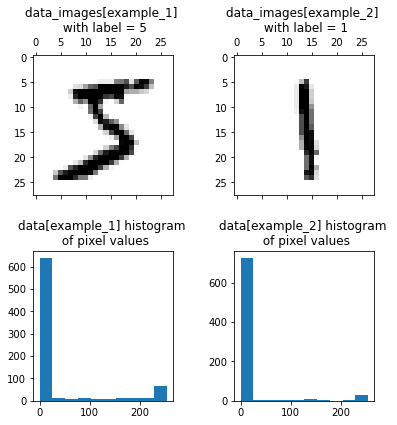

In [10]:
# Auxiliary cell to explore the dataset and visualize a few example images.

# Explore the dataset.
print("type(data) =", type(data))
print("data.shape =", data.shape, "\n")
print("type(labels) =", type(labels))
print("labels.shape =", labels.shape, "\n")
print("min_data =", min_data)
print("max_data =", max_data, "\n")
print("num_data_points =", num_data_points)
print("num_x_pixels =", num_x_pixels)
print("num_y_pixels =", num_y_pixels)
print("num_pixels =", num_pixels, "\n")
print("type(data_images) =", type(data_images))
print("data_images.shape =", data_images.shape, "\n")
# print("data_images[example_1] = \n", data_images[example_1])


# Visualize two example data points, i.e., two example images.
example_1 = 0
example_2 = 8
label_1 = labels[example_1]
label_2 = labels[example_2]
num_fig_rows = 2
num_fig_cols = 2
subfig_height = 3
subfig_width = 3
fig, axes = plt.subplots(num_fig_rows, num_fig_cols, figsize = (num_fig_cols * subfig_width, num_fig_rows * subfig_height)) 
fig.tight_layout(pad = 3.0)
axes[0, 0].matshow(data_images[example_1], cmap = plt.cm.gray_r)
axes[0, 0].set_title("data_images[example_1] \n with label = %i" %label_1)   
axes[0, 1].matshow(data_images[example_2], cmap = plt.cm.gray_r)
axes[0, 1].set_title("data_images[example_2] \n with label = %i" %label_2) 
axes[1, 0].hist(data[example_1], range = (0, np.max(data[example_1])))
axes[1, 0].set_title("data[example_1] histogram \n of pixel values")
axes[1, 1].hist(data[example_2], range = (0, np.max(data[example_2])))
axes[1, 1].set_title("data[example_2] histogram \n of pixel values")
plt.show()

Poisson noise with scaling factor p transforms an array less than with scaling factor q, if p<q:
a =  [ 25  50 125 250  30 100 120  40  10  80]
a_poisson =  [ 34  50 138 266  38  97 110  31   9  87]
a_poisson_1 =  [ 21.  58. 140. 242.  29.  99. 134.  47.  12.  71.]
a_poisson_2 =  [ 20.  60. 115. 220.  25. 110. 100.  25.   0.  80.]
l2_distance(a, a_poisson_1) =  26.48
l2_distance(a, a_poisson_2) =  44.44




Image, built point cloud and DTM(m=0) filtration function values on the point cloud points correspond well:
DTM(m=0) filt_func_vals_point_cloud (should be zero) = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


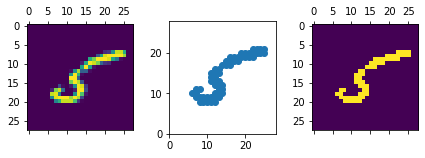





Image, built point cloud, density and DTM filtration function:


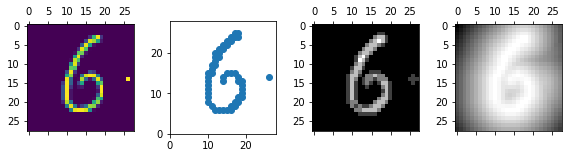





Image as a distance function or a point cloud:
l_infty distance between the two images, represented with their distance functions =  3.605551275463989
hausdorff distance between the two images, represented with their point clouds =  3.605551275463989


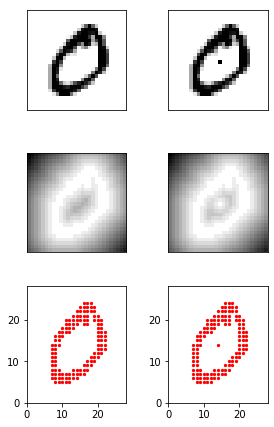





PH wrt Rips filtration, caclulated on a simplicial complex on a point cloud, or on a cubical complex and distance function:
PD0_point_cloud =  [[ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0. 

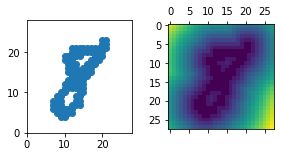

In [11]:
# Auxiliary cell for 28 x 28 images to check if some of the auxiliary functions return reasonable results.

print("Poisson noise with scaling factor p transforms an array less than with scaling factor q, if p<q:")
pixel_scaling_factor_1 = 1
pixel_scaling_factor_2 = 5
pixel_scaling_factor_1 = 1 / pixel_scaling_factor_1
pixel_scaling_factor_2 = 1 / pixel_scaling_factor_2
a = np.array([25, 50, 125, 250, 30, 100, 120, 40, 10, 80])
a_poisson = np.random.poisson(a)
a_poisson_1 = np.random.poisson(a * pixel_scaling_factor_1) / float(pixel_scaling_factor_1)
a_poisson_2 = np.random.poisson(a * pixel_scaling_factor_2) / float(pixel_scaling_factor_2)
print("a = ", a)
print("a_poisson = ", a_poisson)
print("a_poisson_1 = ", a_poisson_1)
print("a_poisson_2 = ", a_poisson_2)
print("l2_distance(a, a_poisson_1) = ", np.around(np.linalg.norm(a - a_poisson_1), 2))
print("l2_distance(a, a_poisson_2) = ", np.around(np.linalg.norm(a - a_poisson_2), 2))
print("\n\n\n")


print("Image, built point cloud and DTM(m=0) filtration function values on the point cloud points correspond well:")
data_point = np.copy(data[11])
image = data_point.reshape((num_x_pixels, num_y_pixels))
point_cloud = build_point_cloud(data_point, 0.5) 
num_points = point_cloud.shape[0]
filt_func_vals_point_cloud = np.zeros(num_points)
filt_func_vals_data_point = dtm_filtration_function(np.asarray([data_point]), 0.5, 0)[0]
filt_func_vals_data_point = filt_func_vals_data_point.reshape((num_x_pixels, num_y_pixels))   
binary_image_test = np.zeros((num_x_pixels, num_y_pixels)) 
for p, point in enumerate(point_cloud):  
    i = num_y_pixels - point[1].astype(int)
    j = point[0].astype(int)
    filt_func_vals_point_cloud[p] = filt_func_vals_data_point[i, j]
    binary_image_test[i, j] = 1    
print("DTM(m=0) filt_func_vals_point_cloud (should be zero) =", filt_func_vals_point_cloud)
num_fig_rows = 1
num_fig_cols = 3
subfig_height = 2
subfig_width = 2
fig, axes = plt.subplots(num_fig_rows, num_fig_cols, figsize = (num_fig_cols * subfig_width, num_fig_rows * subfig_height)) 
fig.tight_layout(pad = 0.5) 
axes[0].matshow(image)
axes[1].scatter(point_cloud[:, 0], point_cloud[:, 1])
axes[1].set_xlim(0, num_x_pixels)
axes[1].set_ylim(0, num_x_pixels)
axes[2].matshow(binary_image_test)
plt.show()
print("\n\n\n")


print("Image, built point cloud, density and DTM filtration function:")
# Image.
data_point = np.copy(data[18]) 
data_point[14*28+26] = 255 # add outlying black pixel in the backround, far away from the point cloud
# data_point[14*28+14] = 255 # add outlying black pixel in the middle of the hole
# Point cloud.
point_cloud = build_point_cloud(data_point, threshold_grsc_perc = 0.5)
# Reference point cloud for density and DTM filtration functions.
point_cloud_complete = np.zeros((num_x_pixels * num_y_pixels, 2))
p = 0
for i in range(num_x_pixels):
    for j in range(num_y_pixels):
        point_cloud_complete[p, 0] = j
        point_cloud_complete[p, 1] = num_y_pixels - i
        p = p + 1         
# Density filtration function.
kdt_1 = KDTree(point_cloud, leaf_size = 30, metric = "euclidean") 
num_nbhs = kdt_1.query_radius(point_cloud_complete, r = 1, count_only = True)  
filt_func_vals_1 = num_nbhs
filt_func_vals_1 = np.max(filt_func_vals_1) - filt_func_vals_1
# max_filt_1 = np.max(filt_func_vals_1)
# filt_func_vals_1[filt_func_vals_1 > 0.8 * max_filt_1] = max_filt_1    
# DTM filtration function.
kdt_2 = KDTree(point_cloud, leaf_size = 30, metric = "euclidean")   
num_points = point_cloud.shape[0]
k = math.floor(0.05 * num_points) + 1
dists_to_nbhs, indices_of_nbhs = kdt_2.query(point_cloud_complete, k, return_distance = True)  
# print(point_cloud.shape)
# print(dists_to_nbhs.shape)
# print(indices_of_nbhs.shape)
# print(dists_to_nbhs)
# print(indices_of_nbhs)
filt_func_vals_2 = np.sqrt(np.sum(dists_to_nbhs**2, axis = 1) / k) 
# max_filt_2 = np.max(filt_func_vals_2)
# filt_func_vals_2[filt_func_vals_2 > 0.4 * max_filt_2] = max_filt_2    
# Plot image, point cloud, density and DTM filtration functions.
num_fig_rows = 1
num_fig_cols = 4
subfig_height = 2
subfig_width = 2
fig, axes = plt.subplots(num_fig_rows, num_fig_cols, figsize = (num_fig_cols * subfig_width, num_fig_rows * subfig_height)) 
fig.tight_layout(pad = 0.5) 
axes[0].matshow(data_point.reshape((num_x_pixels, num_y_pixels)))
axes[1].scatter(point_cloud[:, 0], point_cloud[:, 1])
axes[1].set_xlim(0, num_x_pixels)
axes[1].set_ylim(0, num_x_pixels)
axes[2].matshow(filt_func_vals_1.reshape((num_x_pixels, num_y_pixels)), cmap = plt.cm.gray_r)
axes[3].matshow(filt_func_vals_2.reshape((num_x_pixels, num_y_pixels)), cmap = plt.cm.gray_r)
plt.show()
print("\n\n\n")


print("Image as a distance function or a point cloud:")
# Images.
data_point_1 = np.copy(data[1])
data_point_2 = np.copy(data_point_1)
data_point_2[14*28+14] = 255 # add outlying black pixel in the backround, in the middle of the hole
# data_point_2 = np.copy(data[7])
# data_point_2 = np.copy(data_trnsf["translation -2 -2"][1])
data_1_2 = np.asarray([data_point_1, data_point_2])
# Distance functions.
data_1_2_distance_function = distance_filtration_function(data_1_2, threshold_grsc_perc = 0.5)
data_point_1_distance_function = data_1_2_distance_function[0]
data_point_2_distance_function = data_1_2_distance_function[1]
# Point clouds.
data_point_1_point_cloud = build_point_cloud(data_point_1, threshold_grsc_perc = 0.5)
data_point_2_point_cloud = build_point_cloud(data_point_2, threshold_grsc_perc = 0.5)
distance_distance_functions = np.linalg.norm(data_point_1_distance_function - data_point_2_distance_function, ord = np.inf)
distance_point_clouds = max(directed_hausdorff(data_point_1_point_cloud, data_point_2_point_cloud)[0], 
                            directed_hausdorff(data_point_2_point_cloud, data_point_1_point_cloud)[0])
print("l_infty distance between the two images, represented with their distance functions = ", distance_distance_functions)
print("hausdorff distance between the two images, represented with their point clouds = ", distance_point_clouds)
# Visualize images, distance functions and point clouds.
num_fig_rows = 3
num_fig_cols = 2
subfig_height = 2
subfig_width = 2
fig, axes = plt.subplots(num_fig_rows, num_fig_cols, figsize = (num_fig_cols * subfig_width, num_fig_rows * subfig_height)) 
fig.tight_layout(pad = 0.5)
plot_image(data_point_1.reshape((num_x_pixels, num_y_pixels)), vmin = 0, vmax = np.max(data_1_2), axes = axes[0, 0])
plot_image(data_point_2.reshape((num_x_pixels, num_y_pixels)), vmin = 0, vmax = np.max(data_1_2), axes = axes[0, 1])
plot_image(data_point_1_distance_function.reshape((num_x_pixels, num_y_pixels)), vmin = 0, vmax = np.max(data_1_2_distance_function), axes = axes[1, 0])
plot_image(data_point_2_distance_function.reshape((num_x_pixels, num_y_pixels)), vmin = 0, vmax = np.max(data_1_2_distance_function), axes = axes[1, 1])
axes[2, 0].scatter(data_point_1_point_cloud[:, 0], data_point_1_point_cloud[:, 1], 5, c = "red")
axes[2, 0].set_xlim(0, num_x_pixels)
axes[2, 0].set_ylim(0, num_x_pixels)
axes[2, 1].scatter(data_point_2_point_cloud[:, 0], data_point_2_point_cloud[:, 1], 5, c = "red")
axes[2, 1].set_xlim(0, num_x_pixels)
axes[2, 1].set_ylim(0, num_x_pixels)
plt.show()
print("\n\n\n")
# Distance function is continuous, but the volume below the function (the integral) is equal to the sum of volumes
# below each grid cell, since in our definition of the point cloud, one non-white pixel corresponds to one point cloud point.


print("PH wrt Rips filtration, caclulated on a simplicial complex on a point cloud, or on a cubical complex and distance function:")
data_point = np.copy(data[17])
# Image is considered as a point cloud.
filt_func_vals_data_point_point_cloud = build_point_cloud(data_point, threshold_grsc_perc = 0.5)
simplicial_complex_point_cloud = gd.RipsComplex(points = filt_func_vals_data_point_point_cloud, max_edge_length = np.inf)
simplex_tree_point_cloud = simplicial_complex_point_cloud.create_simplex_tree(max_dimension = 2)  
PDs_point_cloud = simplex_tree_point_cloud.persistence() 
PD0_point_cloud = simplex_tree_point_cloud.persistence_intervals_in_dimension(0)
PD1_point_cloud = simplex_tree_point_cloud.persistence_intervals_in_dimension(1)
# Image is considered as a grid of pixel values.
filt_func_vals_data_point_cubical = distance_filtration_function(np.asarray([data_point]), threshold_grsc_perc =0.5)[0]
# print("filt_func_vals_data_point_cubical = \n", filt_func_vals_data_point_cubical)
simplicial_complex_cubical = gd.CubicalComplex(dimensions = [num_x_pixels, num_y_pixels], top_dimensional_cells = filt_func_vals_data_point_cubical) 
simplex_tree_cubical = simplicial_complex_cubical 
PDs_cubical = simplex_tree_cubical.persistence() 
PD0_cubical = simplex_tree_cubical.persistence_intervals_in_dimension(0)
PD1_cubical = simplex_tree_cubical.persistence_intervals_in_dimension(1)
print("PD0_point_cloud = ", PD0_point_cloud)
print("PD0_cubical = ", PD0_cubical)
print("PD1_point_cloud = ", PD1_point_cloud)
print("PD1_cubical = ", PD1_cubical)
num_fig_rows = 1
num_fig_cols = 2
subfig_height = 2
subfig_width = 2
fig, axes = plt.subplots(num_fig_rows, num_fig_cols, figsize = (num_fig_cols * subfig_width, num_fig_rows * subfig_height)) 
fig.tight_layout(pad = 0.5)
axes[0].scatter(filt_func_vals_data_point_point_cloud[:, 0], filt_func_vals_data_point_point_cloud[:, 1])
axes[0].set_xlim(0, num_x_pixels)
axes[0].set_ylim(0, num_x_pixels)
axes[1].matshow(filt_func_vals_data_point_cubical.reshape((num_x_pixels, num_y_pixels)))
plt.show()
print("\n\n\n")
# The two approaches do not yield exactly the same lists of persistence intervals:
# 0-dim intervals for point clouds include a connected component (with small persistence) for each point cloud point,
# which does not appear for cubical complex.
# 1-dim intervals for point clouds are born at the max dist between two nbh point cloud points along the hole,
# whereas they are born usually at 0 for cubical complex. For point clouds, they die at the shortest diameter of the hole, 
# which is the same for cubical (largest distance within a hole to a black pixel). 
# However, there are many small "holes" for point clouds.
# The two approaches thus yield similar results, except for the points close to the diagonal (noise).

1-dim PH wrt Rips filtration: 
 

data point 1 : 
 [[1.         1.41421356]
 [1.         1.41421356]
 [1.         1.41421356]
 [1.         1.41421356]
 [1.         1.41421356]
 [1.         1.41421356]
 [1.         1.41421356]
 [1.         1.41421356]
 [1.         1.41421356]
 [1.         1.41421356]
 [1.         1.41421356]
 [1.         1.41421356]
 [1.         1.41421356]
 [1.         1.41421356]
 [1.         1.41421356]
 [1.         1.41421356]
 [1.         1.41421356]
 [1.         1.41421356]
 [1.         1.41421356]
 [1.         1.41421356]
 [1.         1.41421356]
 [1.         1.41421356]
 [1.         1.41421356]
 [1.         1.41421356]
 [1.         1.41421356]
 [1.         1.41421356]
 [1.         1.41421356]
 [1.         1.41421356]
 [1.         1.41421356]
 [1.         1.41421356]
 [1.         1.41421356]
 [1.         1.41421356]
 [1.         1.41421356]
 [1.         1.41421356]
 [1.         1.41421356]
 [1.         1.41421356]
 [1.         1.41421356]
 [1.         1.41421356]

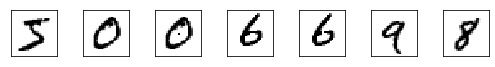

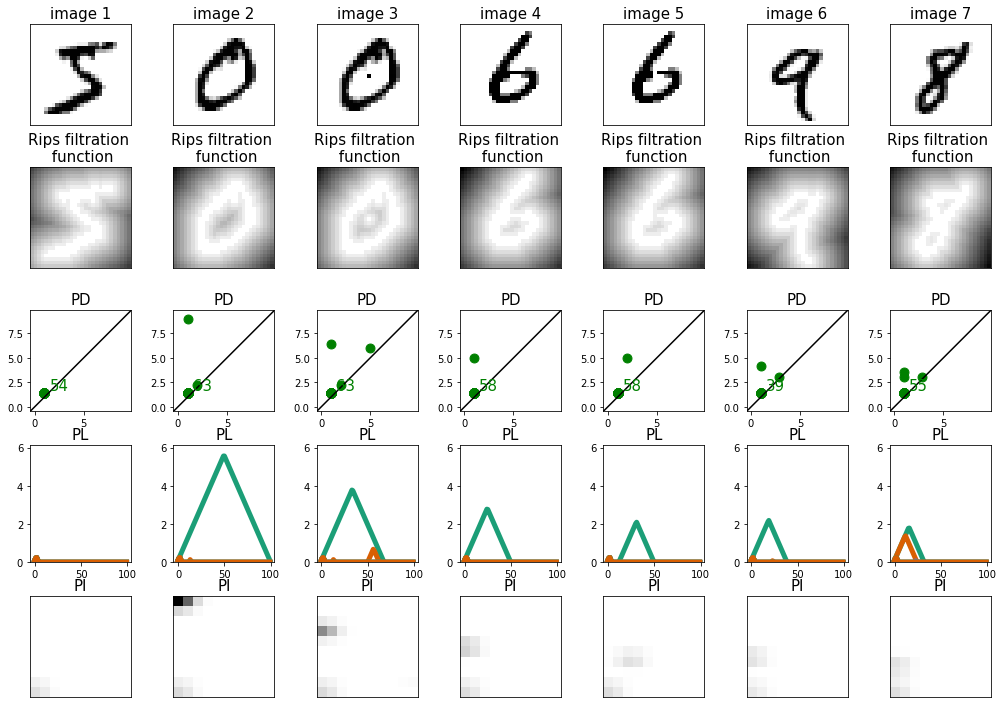

In [12]:
# Auxiliary cell for 28 x 28 images (or without data_4 and data_5 for any image dataset) 
# to gain some initial insights into the discriminative power robustness to one-pixel noise
# across a few example images (under affine transformations, change of a greyscale value 
# of a single pixel, change in brightness or noisy transformations) (Table 1 in turkevs2021noise),
# and to guide the choice of filtration and signature parameters,
# prior to the calculation of filtration functions and PH on the complete dataset.

# Choose images.
data_1 = np.copy(data[0])
data_2 = np.copy(data[47])
data_3 = np.copy(data[1])
data_4 = np.copy(data_3)
data_4[14*28+14] = 255 # add outlying black pixel in the background, in the middle of the hole
# data_4[2*28-2] = 255 # add outlying black pixel in the background
data_5 = np.copy(data[66])
data_5[12*28+14] = 0 
data_5[12*28+15] = 0 
data_5[12*28+16] = 0 
data_5[12*28+17] = 0 
data_5[14*28+14] = 0 
data_5[14*28+15] = 0 
data_5[14*28+16] = 0 
# data_5 = np.copy(data_trnsf["salt and pepper noise 10"][1])
data_6 = np.copy(data_5)
data_6[13*28+14] = 0 # replace a black pixel on the hole with a white pixel, disconnect the hole
data_7 = np.copy(data[18])
data_8 = np.copy(data[4])
data_translated_up = affine_transform(data, {'tx':5, 'ty':5})
data_9 = np.copy(data_translated_up[4])
data_10 = np.copy(data[17])
data_temp = np.asarray([data_1, data_3, data_4, data_5, data_6, data_8, data_10])

# Choose filtration function.
filt_temp = "Rips"

# Choose filtration function parameters and calculate filtration function values.
if filt_temp == "binary":
    filt_func_vals_temp = binary_filtration_function(data_temp, 0.5)
if filt_temp == "grsc":
    filt_func_vals_temp = greyscale_filtration_function(data_temp)
if filt_temp == "density":
    filt_func_vals_temp = density_filtration_function(data_temp, 0.5, 1) 
if filt_temp == "radial":
    filt_func_vals_temp = radial_filtration_function(data_temp, 0.5, 0, 0)
if filt_temp == "Rips":
    filt_func_vals_temp = distance_filtration_function(data_temp, 0.5)
if filt_temp == "DTM":
    filt_func_vals_temp = dtm_filtration_function(data_temp, 0.5, 0.05)

# Choose PD parameters (for Rips and DTM) and calculate PDs.
PDs0, PDs1 = pers_intervals_across_homdims(filt_func_vals_temp, filt_temp, data_temp, 0.5)
    
# Choose homological dimension.
PDs_temp = PDs1
    
# Print persistence intervals for Table 1 in turkevs2021noise.
print("1-dim PH wrt", filt_temp, "filtration: \n \n")
for i, PD in enumerate(PDs_temp): 
    print("data point %d" %(i+1), ": \n", PD, "\n\n")
    

# Calculate maximum value in PDs, to define PI bandwidth
# and to determine the range of x and y-axis in PD plot.
max_PDs_temp = 0
for PD in PDs_temp:
    max_PD = np.max(PD)
    if max_PD > max_PDs_temp:
        max_PDs_temp = max_PD        
    
# Choose PL parameters and calculate PLs.
landscape_ = gd.representations.Landscape(num_landscapes = 10, resolution = 100)
PLs_temp = landscape_.fit_transform(PDs_temp)

# Choose PI parameters and caclulate PIs.
pers_image_ = gd.representations.PersistenceImage(bandwidth = 0.05 * max_PDs_temp, 
                                                  weight = lambda x: x[1]**2, resolution = [10, 10])
PIs_temp = pers_image_.fit_transform(PDs_temp)
    
# Print figure of images for Table 1 in turkevs2021noise.
num_fig_rows = 1
num_fig_cols = data_temp.shape[0]
subfig_height = 1
subfig_width = 1
fig, axes = plt.subplots(num_fig_rows, num_fig_cols, figsize = (num_fig_cols * subfig_width, num_fig_rows * subfig_height)) 
fig.tight_layout(pad = 0) 
for column, data_point in enumerate(data_temp):
    plot_image(data_point.reshape(num_x_pixels, num_y_pixels), vmin = min_data, vmax = max_data, axes = axes[column])
fig.savefig("FIGURES/choice_of_filtration_images", bbox_inches = "tight")


# Plot PDs, PLs, PIs.
num_fig_rows = 5
num_fig_cols = data_temp.shape[0]
subfig_height = 2
subfig_width = 2
fig, axes = plt.subplots(num_fig_rows, num_fig_cols, figsize = (num_fig_cols * subfig_width, num_fig_rows * subfig_height)) 
fig.tight_layout(pad = 0.5) 
for column, data_point in enumerate(data_temp):
    # Image.
    image = np.copy(data_temp[column])
    image = image.reshape((num_x_pixels, num_y_pixels))
    plot_image(image, vmin = np.min(data_temp), vmax = np.max(data_temp), axes = axes[0, column])
    axes[0, column].set_title("image %d" %(column+1), fontsize = 15)
    # Filtration function values.
    filt_func_vals = np.copy(filt_func_vals_temp[column])
    filt_func_vals = filt_func_vals.reshape((num_x_pixels, num_y_pixels))
    plot_image(filt_func_vals, vmin = 0, vmax = np.max(filt_func_vals_temp), axes = axes[1, column]) 
    axes[1, column].set_title(filt_temp + " filtration \n function", fontsize = 15)
    # PD.
    PD = np.copy(PDs_temp[column])
    plot_PD(PD, xymax = max_PDs_temp, axes = axes[2, column]) 
    axes[2, column].set_title("PD", fontsize = 15)   
    # PL.
    PL = np.copy(PLs_temp[column])
    plot_PL(PL, num_lndscs = 10, lndsc_resolution = 100, ymax = np.max(PLs_temp), axes = axes[3, column])
    axes[3, column].set_title("PL", fontsize = 15)
    # PI.
    PI = np.copy(PIs_temp[column])
    plot_PI(PI, pers_image_resolution = 10, vmin = 0, vmax = np.max(PIs_temp), axes = axes[4, column])
    axes[4, column].set_title("PI", fontsize = 15)     
plt.show()

In [13]:
# Compute "data_trnsf", dictionary which stores the given dataset of images under given transformations. 
data_trnsf = {}

# Make a choice on the set of transformations to be considered in the experiments.
trnsfs = ["no noise", 
          "rotation 45", "rotation -90", "translation 1 1", "translation -2 -2", "stretch-shear-flip 1.5 10 h", "stretch-shear-flip 0.75 -20 v",
          "brightness -50", "brightness 100", "contrast 2", "contrast 0.5",
          "gaussian noise 10", "gaussian noise 20", "salt and pepper noise 5", "salt and pepper noise 10", "shot noise 50", "shot noise 100"]
# If we wish to investigate only some types of noise, or shorten the computation time, we can consider e.g.:
# trnsfs = ["no noise", "rotation -90", "translation -2 -2", "stretch-shear-flip 0.75 -20 v", "brightness 100", "contrast 0.5",          
#          "gaussian noise 20", "salt and pepper noise 20", "shot noise 100"]

num_trnsfs = len(trnsfs)
data_trnsf["no noise"] = data

print("Constructing the data under transformations, when images are represented as greyscale pixel values...")
t0 = time.time()

data_trnsf["rotation 45"] = affine_transform(data, {'theta':45})
data_trnsf["rotation -90"] = affine_transform(data, {'theta':-90})
data_trnsf["translation 1 1"] = affine_transform(data, {'tx':1, 'ty':1})
data_trnsf["translation -2 -2"] = affine_transform(data, {'tx':-2, 'ty':-2})
data_trnsf["stretch-shear-flip 1.5 10 h"] = affine_transform(data, {'zx':1.5, 'shear':10, 'flip_horizontal':True})
data_trnsf["stretch-shear-flip 0.75 -20 v"] = affine_transform(data, {'zx':0.75, 'shear':-20, 'flip_vertical':True})

data_trnsf["brightness -50"] = data - 50
data_trnsf["brightness -50"] = np.clip(data_trnsf["brightness -50"], min_data, max_data)
data_trnsf["brightness 100"] = data + 100
data_trnsf["brightness 100"] = np.clip(data_trnsf["brightness 100"], min_data, max_data) 
data_trnsf["contrast 2"] = data * 2
data_trnsf["contrast 2"] = np.clip(data_trnsf["contrast 2"], min_data, max_data)
data_trnsf["contrast 0.5"] = data * 0.5
data_trnsf["contrast 0.5"] = np.clip(data_trnsf["contrast 0.5"], min_data, max_data)

data_trnsf["gaussian noise 10"] = gaussian_noise(data, noise_std_dev = 10) 
data_trnsf["gaussian noise 20"] = gaussian_noise(data, noise_std_dev = 20) 
data_trnsf["salt and pepper noise 5"] = salt_and_pepper_noise(data, proportion_noise_pixels = 0.05)
data_trnsf["salt and pepper noise 10"] = salt_and_pepper_noise(data, proportion_noise_pixels = 0.1)
data_trnsf["shot noise 50"] = shot_noise(data, pixel_scaling_factor = 50) 
data_trnsf["shot noise 100"] = shot_noise(data, pixel_scaling_factor = 100) 
# from skimage.util import img_as_float, random_noise
# data_trnsf["gaussian noise 10"] = 255 * random_noise(data, mode = "gaussian", var = 0.1) # variance is for the range [0,1]
# data_trnsf["gaussian noise 20"] = 255 * random_noise(data, mode = "gaussian", var = 0.2)
# data_trnsf["salt and pepper noise 5"] = 255 * random_noise(data, mode = "s&p", amount = 0.1, salt_vs_pepper = 0.2)
# data_trnsf["salt and pepper noise 20"] = 255 * random_noise(data, mode = "s&p", amount = 0.2, salt_vs_pepper = 0.2)
# data_trnsf["shot noise 50"] = 255 * random_noise(data*1, mode = "poisson") / 1
# data_trnsf["shot noise 100"] = 255 * random_noise(data*0.75, mode = "poisson") / 0.75

with open("VARIABLES/data_trnsf.pkl", "wb") as f:
    pickle.dump(data_trnsf, f)
t1 = time.time()
runtime = t1 - t0
print("Runtime = %.3f s" % runtime)

Constructing the data under transformations, when images are represented as greyscale pixel values...
Runtime = 1.456 s


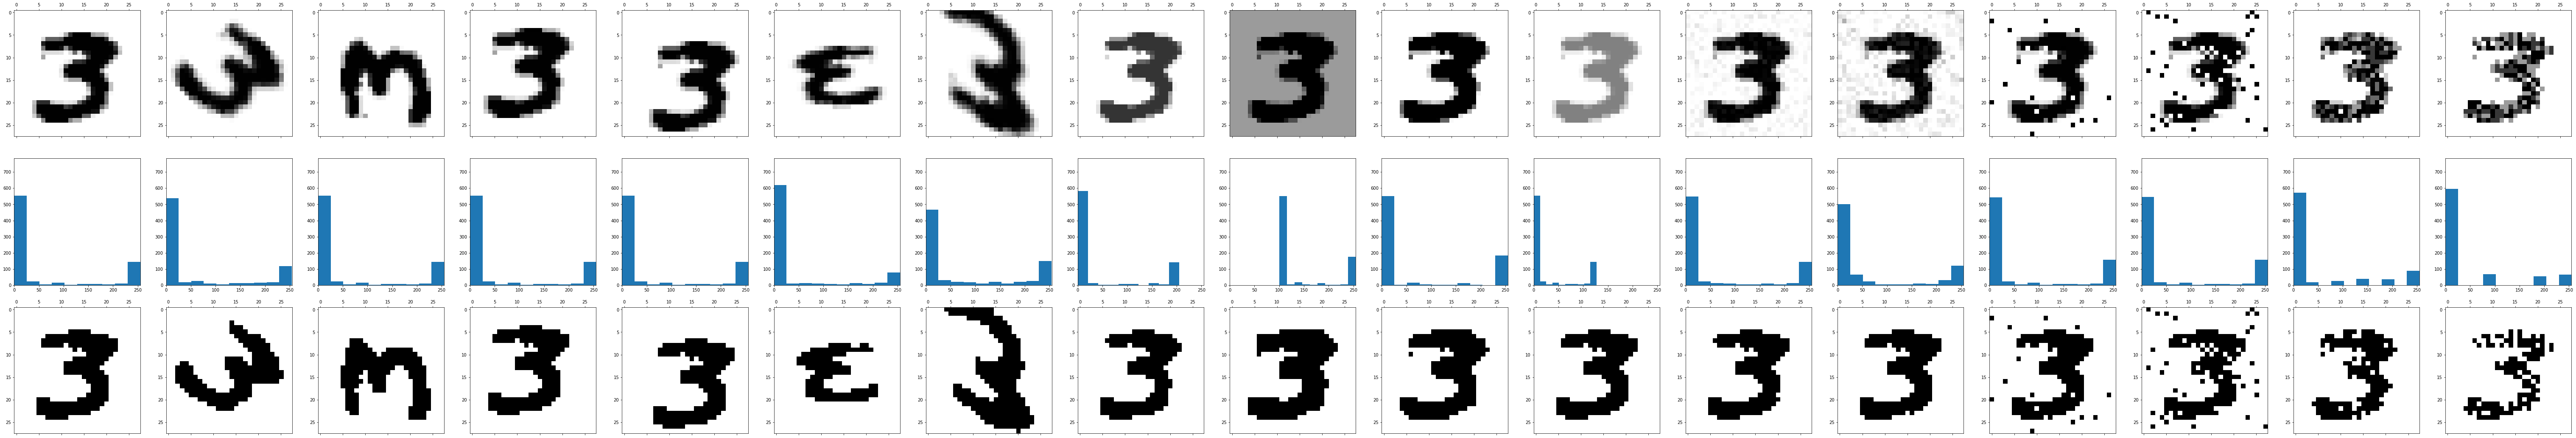

Maximum greyscale value =
no noise : 255.0
rotation 45 : 255.00000000000003
rotation -90 : 255.0
translation 1 1 : 255.0
translation -2 -2 : 255.0
stretch-shear-flip 1.5 10 h : 255.00000000000003
stretch-shear-flip 0.75 -20 v : 255.0
brightness -50 : 205.0
brightness 100 : 255.0
contrast 2 : 255.0
contrast 0.5 : 127.5
gaussian noise 10 : 255.0
gaussian noise 20 : 255.0
salt and pepper noise 5 : 255.0
salt and pepper noise 10 : 255.0
shot noise 50 : 255.0
shot noise 100 : 255.0

Distance(noisy image, non-noisy image) =
no noise : 0.0
rotation 45 : 3043.0
rotation -90 : 3702.0
translation 1 1 : 1965.0
translation -2 -2 : 2993.0
stretch-shear-flip 1.5 10 h : 3368.0
stretch-shear-flip 0.75 -20 v : 3069.0
brightness -50 : 743.0
brightness 100 : 2499.0
contrast 2 : 675.0
contrast 0.5 : 1628.0
gaussian noise 10 : 225.0
gaussian noise 20 : 442.0
salt and pepper noise 5 : 1079.0
salt and pepper noise 10 : 1720.0
shot noise 50 : 1098.0
shot noise 100 : 1416.0

Number of black pixels in binary im

In [14]:
# Auxiliary cell to visualize and explore different types of noise,
# and to guide the choice of parameters for transformations in the previous cell.

# Construct the image datasets, for visualization purposes.
data_images_trnsf = {}
for trnsf in trnsfs:
    data_images_trnsf[trnsf] = data_trnsf[trnsf].reshape((num_data_points, num_x_pixels, num_y_pixels))  
        
# Visualize different transformations for an example image.
example = 27
num_fig_rows = 3
num_fig_cols = num_trnsfs
subfig_height = 5
subfig_width = 5
fig, axes = plt.subplots(num_fig_rows, num_fig_cols, figsize = (num_fig_cols * subfig_width, num_fig_rows * subfig_height)) 
fig.tight_layout(pad = 3.0)
for t, trnsf in enumerate(trnsfs):
    # Image.
    axes[0, t].matshow(data_images_trnsf[trnsf][example], cmap = plt.cm.gray_r, vmin = min_data, vmax = max_data)
    # Histogram of pixel values.
    axes[1, t].hist(data_trnsf[trnsf][example])
    axes[1, t].set_xlim(np.min(data), np.max(data))
    axes[1, t].set_ylim(0, num_pixels)  
    # Binary image.
    axes[2, t].matshow(data_images_trnsf[trnsf][example] > 0.5 * np.max(data_images_trnsf[trnsf][example]),
                       cmap = plt.cm.gray_r)
plt.show()  
    
# Explore different transformations for an example image.
print("Maximum greyscale value =")
for trnsf in trnsfs:
    print(trnsf, ":", np.max(data_trnsf[trnsf]))
print()
print("Distance(noisy image, non-noisy image) =")
for trnsf in trnsfs:
    print(trnsf, ":", np.around(np.linalg.norm(data_trnsf[trnsf][example] - data_trnsf["no noise"][example]), 0))
print()
print("Number of black pixels in binary image (above given threshold greyscale value) =")
for trnsf in trnsfs:
    print(trnsf, ":", np.sum(data_images_trnsf[trnsf][example] > 0.5 * np.max(data_trnsf[trnsf][example])))
print()

d([0, l], [0, 0]):


<ipython-input-15-0cf88e3ac2d9>:30: RuntimeWarning: invalid value encountered in power
  plt.plot(x, x**(3/2), c = "black")


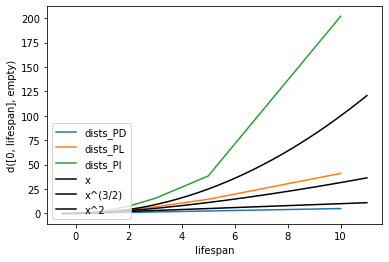

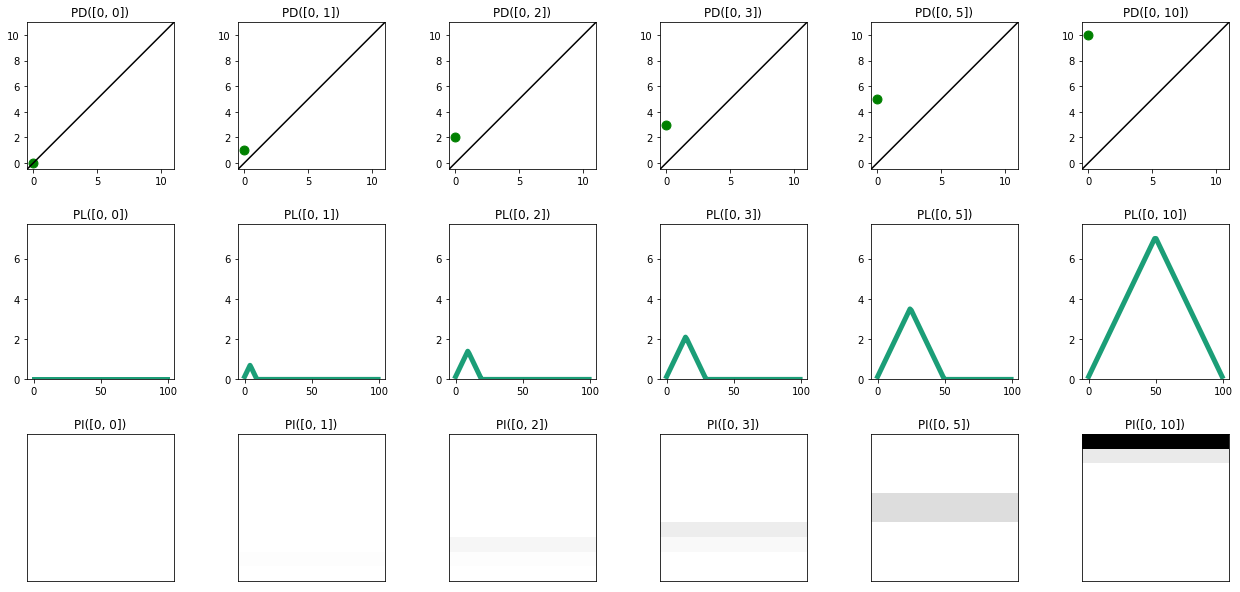





d(PH, PH0), when PH and PH0 points are matched to each other, or when both are matched to diagonal:


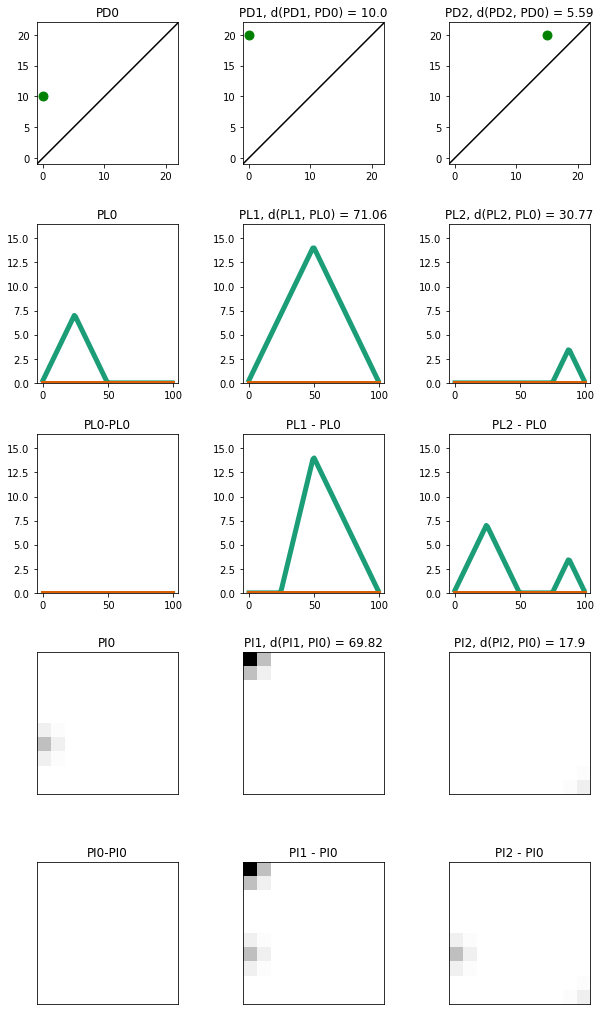





d(PH, P0), when PH is obtained from PH0 by changing the existing lifespan of the cycle, or by including additional cycle:


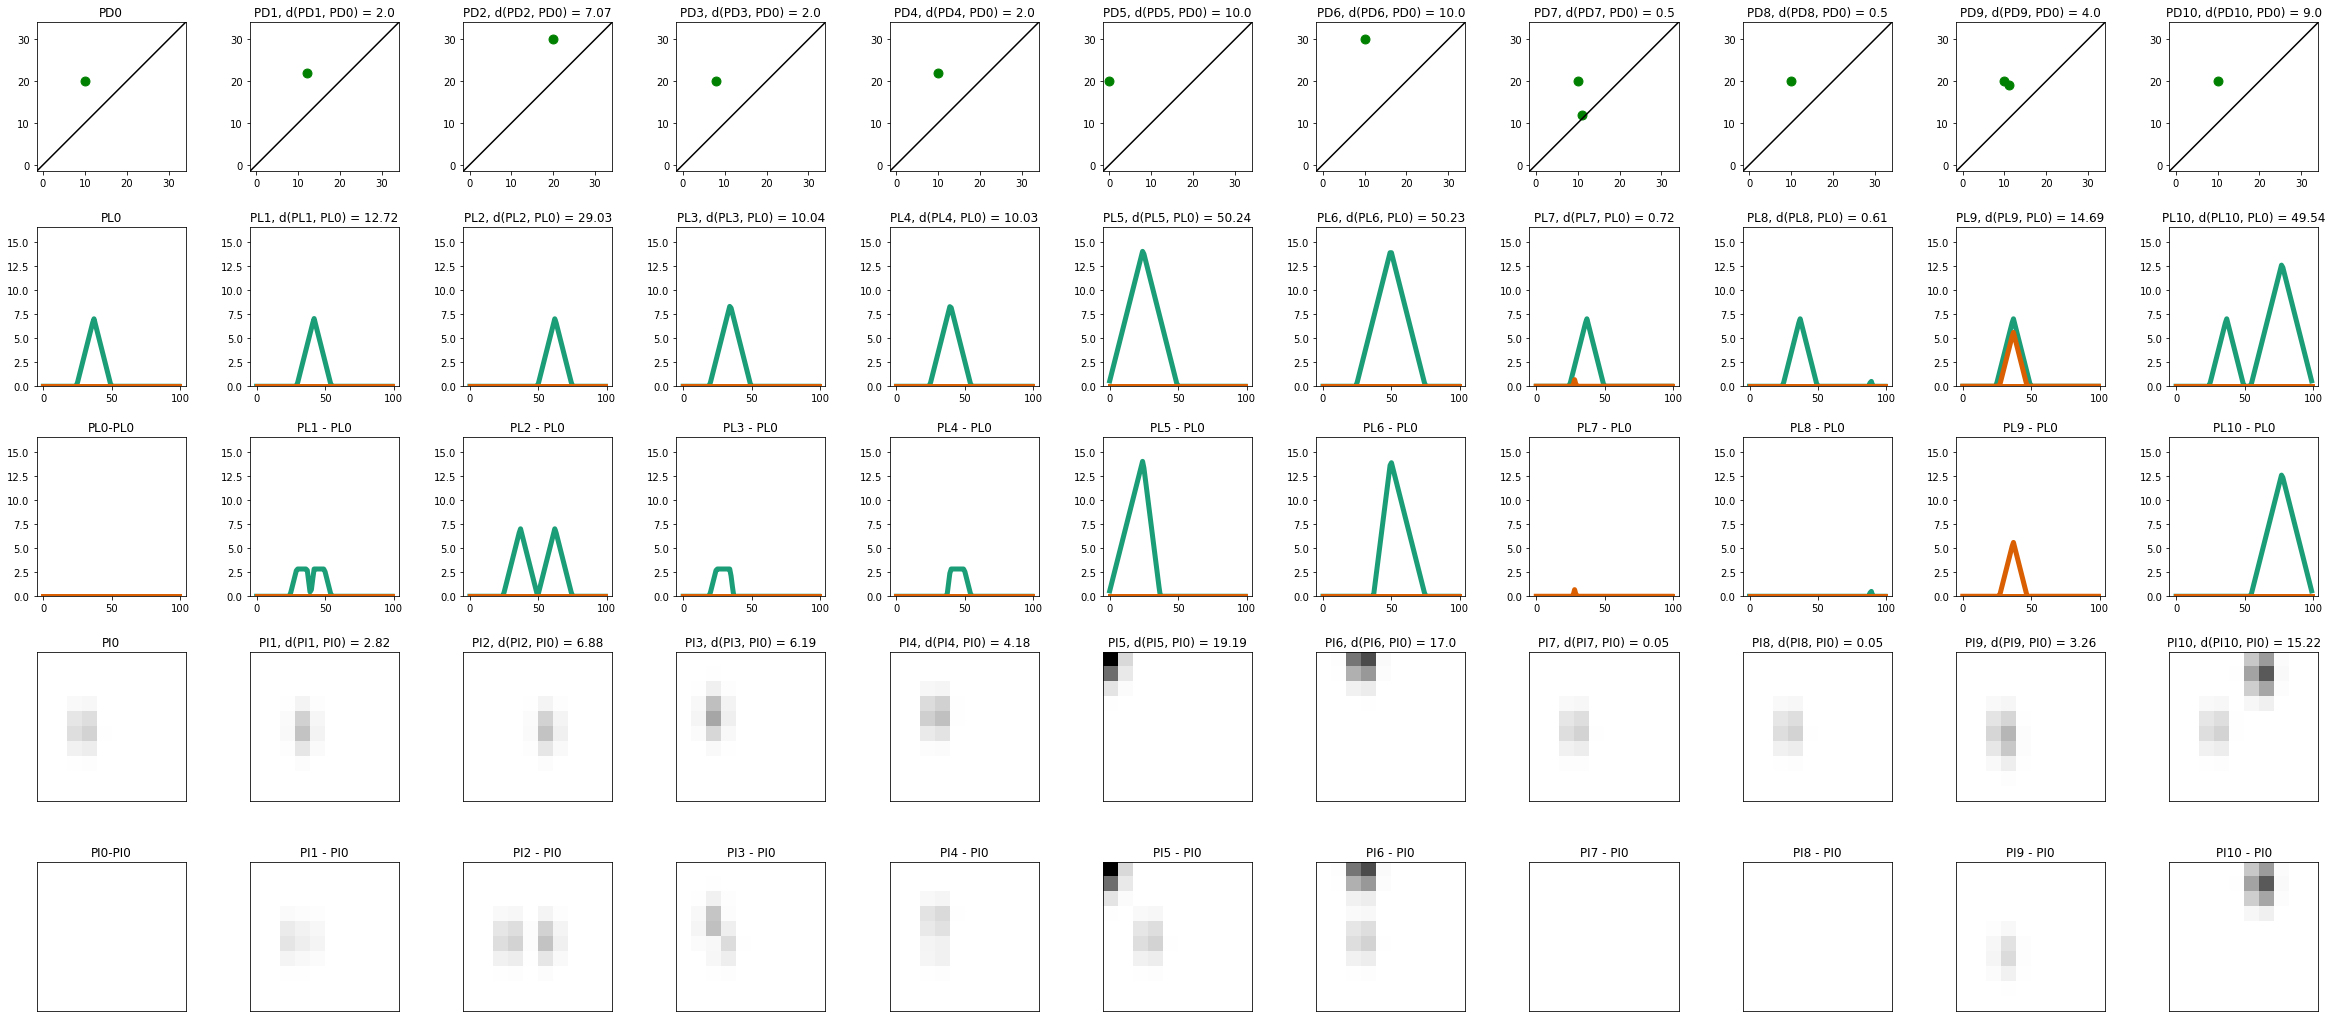

In [15]:
# Auxiliary cell to investigate how the choice of persistence signature (and metric)
# influences the noise robustness of PH (related to Table 2 in turkevs2021noise),
# on some synthetic examples of persistence intervals;
# and to further guide the choice of persistence signature parameters
# prior to the calculation of signatures on the complete dataset.


print("d([0, l], [0, 0]):")
lifespans = np.asarray([0, 1, 2, 3, 5, 10])
PDs = []    
num_PDs = len(lifespans)
for l in lifespans:
    PDs.append(np.asarray([[0, l]]))
landscape = gd.representations.Landscape(num_landscapes = 1, resolution = 100)
PLs = landscape.fit_transform(PDs)
pers_image = gd.representations.PersistenceImage(bandwidth = 0.05 * np.max(lifespans), weight = lambda x: x[1]**2, resolution = [10, 10])
PIs = pers_image.fit_transform(PDs)
dists_PDs = np.zeros(num_PDs)
dists_PLs = np.zeros(num_PDs)
dists_PIs = np.zeros(num_PDs)
for i in range(num_PDs):
    dists_PDs[i] = gudhi.wasserstein.wasserstein_distance(PDs[i], PDs[0], order = 2, internal_p = np.inf)
    dists_PLs[i] = np.linalg.norm(PLs[i] - PLs[0], ord = 2)
    dists_PIs[i] = np.linalg.norm(PIs[i] - PIs[0], ord = 2)
plt.plot(lifespans, dists_PDs)
plt.plot(lifespans, dists_PLs)
plt.plot(lifespans, dists_PIs)
x = np.arange(-0.05 * np.max(lifespans), 1.1 * np.max(lifespans), 0.01)
plt.plot(x, x, c = "black")
plt.plot(x, x**(3/2), c = "black")
plt.plot(x, x**2, c = "black")
plt.xlabel("lifespan")
plt.ylabel("d([0, lifespan], empty)")
plt.legend(("dists_PD", "dists_PL", "dists_PI", "x", "x^(3/2)", "x^2"), loc = "lower left")
plt.show()
num_fig_rows = 3
num_fig_cols = num_PDs
subfig_height = 3
subfig_width = 3
fig, axes = plt.subplots(num_fig_rows, num_fig_cols, figsize = (num_fig_cols * subfig_width, num_fig_rows * subfig_height)) 
fig.tight_layout(pad = 3.0)
for i in range(num_fig_cols):
    plot_PD(PDs[i], xymax = np.max(lifespans), axes = axes[0, i])
    plot_PL(PLs[i], num_lndscs = 1, lndsc_resolution = 100, ymax = np.max(PLs), axes = axes[1, i])
    plot_PI(PIs[i], pers_image_resolution = 10, vmin = 0, vmax = np.max(PIs), axes = axes[2, i])
    axes[0, i].set_title("PD([0, %d])" %lifespans[i])
    axes[1, i].set_title("PL([0, %d])" %lifespans[i])
    axes[2, i].set_title("PI([0, %d])" %lifespans[i])
plt.show()
print("\n\n\n")    
    
    
print("d(PH, PH0), when PH and PH0 points are matched to each other, or when both are matched to diagonal:")
PD0 = np.asarray([[0, 10]])
PD1 = np.asarray([[0, 20]]) # points in PD1 and PD0 are matched to each other
PD2 = np.asarray([[15, 20]]) # points in PD2 and PD0 are both matched to diagonal
PDs = [PD0, PD1, PD2]     
landscape = gd.representations.Landscape(num_landscapes = 10, resolution = 100)
PLs = landscape.fit_transform(PDs)
pers_image = gd.representations.PersistenceImage(bandwidth = 0.05 * 20, weight = lambda x: x[1]**2, resolution = [10, 10])
PIs = pers_image.fit_transform(PDs)
num_fig_rows = 5
num_fig_cols = len(PDs)
subfig_height = 3
subfig_width = 3
fig, axes = plt.subplots(num_fig_rows, num_fig_cols, figsize = (num_fig_cols * subfig_width, num_fig_rows * subfig_height)) 
fig.tight_layout(pad = 3.0)
for i in range(num_fig_cols):
    plot_PD(PDs[i], xymax = 20, axes = axes[0, i])
    plot_PL(PLs[i], num_lndscs = 10, lndsc_resolution = 100, ymax = np.max(PLs)+1, axes = axes[1, i])
    plot_PL(np.abs(PLs[i] - PLs[0]), num_lndscs = 10, lndsc_resolution = 100, ymax = np.max(PLs)+1, axes = axes[2, i])   
    plot_PI(PIs[i], 10, vmin = 0, vmax = np.max(PIs), axes = axes[3, i])
    plot_PI(np.abs(PIs[i]-PIs[0]), 10, vmin = 0, vmax = np.max(PIs), axes = axes[4, i])   
    axes[0, 0].set_title("PD0")
    axes[1, 0].set_title("PL0")
    axes[2, 0].set_title("PL0-PL0")
    axes[3, 0].set_title("PI0")
    axes[4, 0].set_title("PI0-PI0")
    if i > 0:        
        axes[0, i].set_title("PD%d, d(PD%d, PD0) = %s" %(i, i, np.around(gudhi.wasserstein.wasserstein_distance(PDs[i], PDs[0], order = 2, internal_p = np.inf), 2)))
        axes[1, i].set_title("PL%d, d(PL%d, PL0) = %s" %(i, i, np.around(np.linalg.norm(PLs[i] - PLs[0], ord = 2), 2)))
        axes[2, i].set_title("PL%d - PL0" %i)
        axes[3, i].set_title("PI%d, d(PI%d, PI0) = %s" %(i, i, np.around(np.linalg.norm(PIs[i] - PIs[0], ord = 2), 2))) 
        axes[4, i].set_title("PI%d - PI0" %i)
plt.show()
print("\n\n\n")


print("d(PH, P0), when PH is obtained from PH0 by changing the existing lifespan of the cycle, or by including additional cycle:")
PD0 = np.asarray([[10, 20]])
PD1 = np.asarray([[12, 22]]) # l unchanged, b=b+eps, d=d+eps, close to (b,d)
PD2 = np.asarray([[20, 30]]) # l unchanged, b=b+eps, d=d+eps, far from (b,d)
PD3 = np.asarray([[8, 20]]) # l increased a little bit, b=b-eps, d=d
PD4 = np.asarray([[10, 22]])# l increased a little bit, b=b, d=d+eps
PD5 = np.asarray([[0, 20]]) # l increased a lot, b=b-eps, d=d
PD6 = np.asarray([[10, 30]]) # l increased a lot, b=b, d=d+eps
PD7 = np.asarray([[10, 20], [11, 12]]) # additional small lifespan, close to (b,d)
PD8 = np.asarray([[10, 20], [35, 36]]) # additional small lifespan, far from (b,d)
PD9 = np.asarray([[10, 20], [11, 19]]) # additional large lifespan, close to (b,d)
PD10 = np.asarray([[10, 20], [22, 40]]) # additional large lifespan, far from (b,d)
PDs = [PD0, PD1, PD2, PD3, PD4, PD5, PD6, PD7, PD8, PD9, PD10]     
landscape = gd.representations.Landscape(num_landscapes = 10, resolution = 100)
PLs = landscape.fit_transform(PDs)
pers_image = gd.representations.PersistenceImage(bandwidth = 0.05 * 40, weight = lambda x: x[1]**2, resolution = [10, 10])
PIs = pers_image.fit_transform(PDs)
num_fig_rows = 5
num_fig_cols = len(PDs)
subfig_height = 3
subfig_width = 3
fig, axes = plt.subplots(num_fig_rows, num_fig_cols, figsize = (num_fig_cols * subfig_width, num_fig_rows * subfig_height)) 
fig.tight_layout(pad = 3.0)
for i in range(num_fig_cols):
    plot_PD(PDs[i], xymax = 30+1, axes = axes[0, i])    
    plot_PL(PLs[i], num_lndscs = 10, lndsc_resolution = 100, ymax = np.max(PLs)+1, axes = axes[1, i])
    plot_PL(np.abs(PLs[i] - PLs[0]), num_lndscs = 10, lndsc_resolution = 100, ymax = np.max(PLs)+1, axes = axes[2, i])
    plot_PI(PIs[i], 10, vmin = 0, vmax = np.max(PIs), axes = axes[3, i])
    plot_PI(np.abs(PIs[i]-PIs[0]), 10, vmin = 0, vmax = np.max(PIs), axes = axes[4, i])
    axes[0, 0].set_title("PD0")
    axes[1, 0].set_title("PL0")
    axes[2, 0].set_title("PL0-PL0")
    axes[3, 0].set_title("PI0")
    axes[4, 0].set_title("PI0-PI0")
    if i > 0:
        axes[0, i].set_title("PD%d, d(PD%d, PD0) = %s" %(i, i, np.around(gudhi.wasserstein.wasserstein_distance(PDs[i], PDs[0], order = 2, internal_p = np.inf), 2)))
        axes[1, i].set_title("PL%d, d(PL%d, PL0) = %s" %(i, i, np.around(np.linalg.norm(PLs[i] - PLs[0], ord = 2), 2)))
        axes[2, i].set_title("PL%d - PL0" %i)
        axes[3, i].set_title("PI%d, d(PI%d, PI0) = %s" %(i, i, np.around(np.linalg.norm(PIs[i] - PIs[0], ord = 2), 2))) 
        axes[4, i].set_title("PI%d - PI0" %i)
plt.show()

In [16]:
# Compute "data_filt_func_vals_trnsf", dictionary which stores the filtration function values for any (noisy and non-noisy) image.
data_filt_trnsf = {}
runtime_data_filt_trnsf = {}

# Make a choice on the set of filtrations to be considered in the experiments.
filts = ["binary", "grsc", "density", "radial", "Rips", "DTM"]
# If we wish to investigate only some of the filtration functions, or shorten the computation time, we can consider e.g.:
# filts = ["radial", DTM"]
num_filts = len(filts)

# Auxiliary function to enable parallel computing of filtration functions.
def filt_trnsf(filt, trnsf, data):    
    t0 = time.time()         
    if filt == "binary":          
        filt_func_vals = binary_filtration_function(data, threshold_grsc_perc)        
    if filt == "grsc":          
        filt_func_vals = greyscale_filtration_function(data)        
    if filt == "density":               
        filt_func_vals = density_filtration_function(data, threshold_grsc_perc, density_max_dist)       
    if filt == "radial":
        filt_func_vals = radial_filtration_function(data, threshold_grsc_perc, radial_x_pixel, radial_y_pixel)        
    if filt == "Rips": 
        filt_func_vals = distance_filtration_function(data, threshold_grsc_perc)
    if filt == "DTM": 
        filt_func_vals = dtm_filtration_function(data, threshold_grsc_perc, dtm_m)        
    filt_func_vals_dict = {}    
    filt_func_vals_dict[filt, trnsf] = filt_func_vals
    t1 = time.time()
    runtime = t1 - t0
    runtime_dict = {}
    runtime_dict[filt, trnsf] = runtime  
    return filt_func_vals_dict, runtime_dict

# !!! Choice of parameters for the filtration functions.
threshold_grsc_perc = 0.5
density_max_dist = 1
radial_x_pixel = 0
radial_y_pixel = 0
dtm_m = 0.1

print("Parallel calculation of filtration functions for the given dataset, across filtrations and data transformations ...")
t0 = time.time()
filt_func_vals_and_runtime_dicts = Parallel(n_jobs = -1)(
    delayed(filt_trnsf)(filt, trnsf, data_trnsf[trnsf])
    for filt in filts
    for trnsf in trnsfs)
for filt_func_vals_dict, runtime_dict in filt_func_vals_and_runtime_dicts:
    data_filt_trnsf.update(filt_func_vals_dict)
    runtime_data_filt_trnsf.update(runtime_dict)
with open("VARIABLES/data_filt_trnsf.pkl", "wb") as f:
    pickle.dump(data_filt_trnsf, f)
with open("VARIABLES/runtime_data_filt_trnsf.pkl", "wb") as f:
    pickle.dump(runtime_data_filt_trnsf, f)
t1 = time.time()
runtime = t1 - t0
print("Runtime = %.3f s" % runtime)

# Calculate maximum filtration function values, in order to properly visualize the filtrations.
max_data_filt = {}
for filt in filts:
    max_data_filt[filt] = 0
    for trnsf in trnsfs:
        max_data_filt_trnsf = np.max(data_filt_trnsf[filt, trnsf])
        if max_data_filt_trnsf > max_data_filt[filt]:
            max_data_filt[filt] = max_data_filt_trnsf

Parallel calculation of filtration functions for the given dataset, across filtrations and data transformations ...
Runtime = 5.634 s


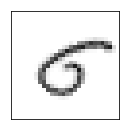

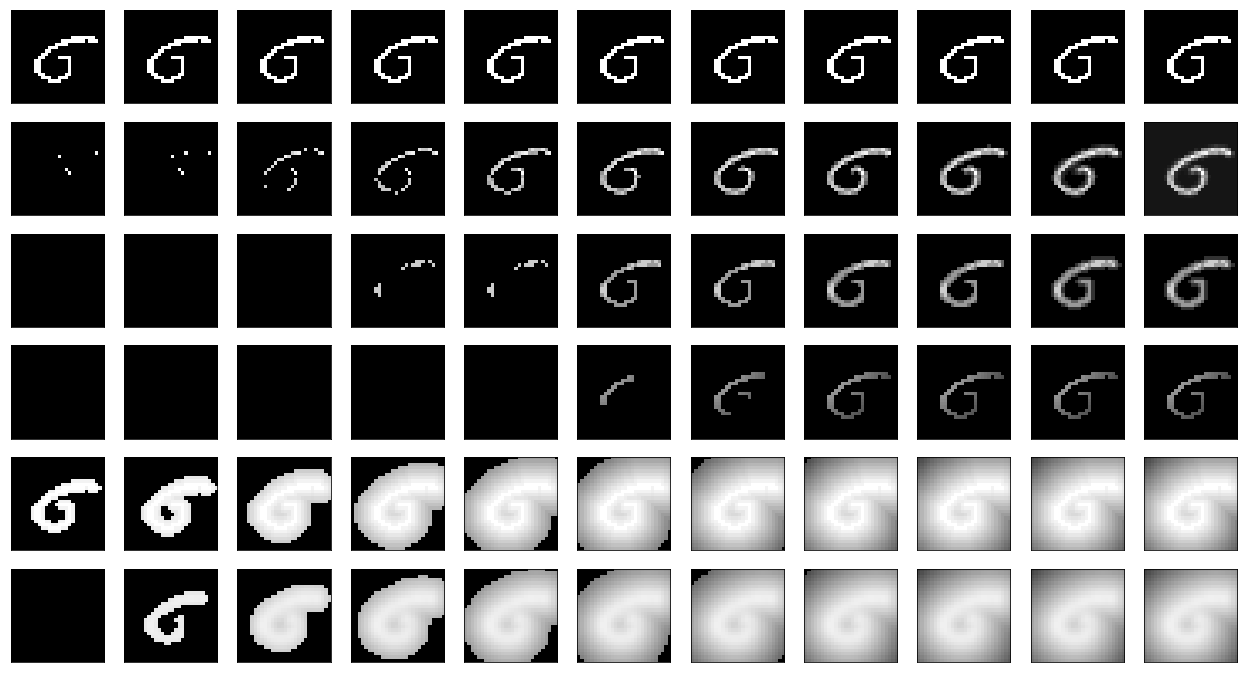

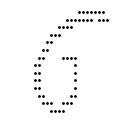

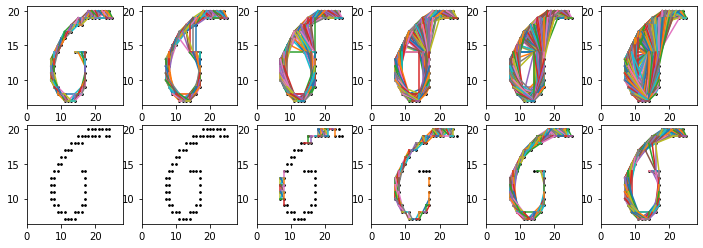

data_filt_trnsf[density, rotation 45].shape = (70, 784)
data_filt_trnsf[density, rotation 45][example].shape = (784,)
data_filt_trnsf[Rips, rotation 45].shape = (70, 784)
data_filt_trnsf[Rips, rotation 45][example].shape = (784,)

max_data_filt[ binary ] =  1.0
max_data_filt[ grsc ] =  255.00000000000003
max_data_filt[ density ] =  5.0
max_data_filt[ radial ] =  38.18376618407357
max_data_filt[ Rips ] =  20.808652046684813
max_data_filt[ DTM ] =  21.317330307254036

data_filt_trnsf[Rips, no noise][example] = 
 [[14.42 13.6  12.81 12.04 11.31 10.63  9.9   9.22  8.49  7.81  7.07  6.4
   5.66  5.    4.24  3.61  3.16  3.    3.    3.16  3.61  4.24  5.    5.83
   6.71  7.62  8.54  9.49]
 [13.89 13.04 12.21 11.4  10.63  9.9   9.22  8.49  7.81  7.07  6.4   5.66
   5.    4.24  3.61  2.83  2.24  2.    2.    2.24  2.83  3.61  4.47  5.39
   6.32  7.28  8.25  9.22]
 [13.42 12.53 11.66 10.82 10.    9.22  8.49  7.81  7.07  6.4   5.66  5.
   4.24  3.61  2.83  2.24  1.41  1.    1.    1.41  2.24  3.16  

In [17]:
# Auxiliary cell to visualize and explore filtration (function)s, for an example (noisy or non-noisy) image.
# and, if necessary, to adjust the choice of parameters for filtrations in the previous cell.

example = 18
trnsf = "rotation 45"

subfig_height = 2
subfig_width = 2
       
# Visualize image.
fig, axes = plt.subplots(1, 1, figsize = (subfig_width, subfig_height)) 
plot_image(data_images_trnsf[trnsf][example], vmin = min_data, vmax = max_data, axes = axes)

# Visualize filtrations on image.
filt_func_vals_percentages = np.asarray([0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
num_fig_rows = num_filts
num_fig_cols = len(filt_func_vals_percentages)
fig, axes = plt.subplots(num_fig_rows, num_fig_cols, figsize = (num_fig_cols * subfig_width, num_fig_rows * subfig_height)) 
for f, filt in enumerate(filts):
    filt_func_vals_pixels = np.copy(data_filt_trnsf[filt, trnsf][example])
    filt_func_vals_pixels = filt_func_vals_pixels.reshape((num_x_pixels, num_y_pixels)) 
    for p, perc in enumerate(filt_func_vals_percentages):
        cubical_complex = np.zeros((num_x_pixels, num_y_pixels)) + max_data_filt[filt]
        filt_func_val_upper_limit = perc * max_data_filt[filt]
        for i in range(num_x_pixels):
            for j in range(num_y_pixels):
                if(filt_func_vals_pixels[i, j] < filt_func_val_upper_limit):
                    cubical_complex[i, j] = filt_func_vals_pixels[i, j]                    
        plot_image(cubical_complex, vmin = 0, vmax = max_data_filt[filt], axes = axes[f, p])
    
# Visualize point cloud from image.
point_cloud = build_point_cloud(data_trnsf[trnsf][example], threshold_grsc_perc)
fig, axes = plt.subplots(1, 1, figsize = (subfig_width, subfig_height)) 
axes.scatter(point_cloud[:, 0], point_cloud[:, 1], c = "black", s = 3)
axes.set_xlim(0, num_x_pixels)
axes.set_xlim(0, num_y_pixels)
axes.axis('off')
   
# Visualize filtrations on point cloud.
filt_func_vals_percentages = np.asarray([0.15, 0.2, 0.25, 0.3, 0.35, 0.4]) # [0.02, 0.03, 0.05, 0.1, 0.125, 0.15]
num_fig_rows = 2
num_fig_cols = len(filt_func_vals_percentages)
fig, axes = plt.subplots(num_fig_rows, num_fig_cols, figsize = (num_fig_cols * subfig_width, num_fig_rows * subfig_height)) 
for f, filt in enumerate(["Rips", "DTM"]):    
    num_points = point_cloud.shape[0]
    distances_between_points = euclidean_distances(point_cloud)    
    if filt == "Rips":
        filt_func_vals_points = np.zeros(num_points)
        filt_func_vals_edges = distances_between_points
    else:
        filt_func_vals = np.copy(data_filt_trnsf[filt, trnsf][example])   
        filt_func_vals = filt_func_vals.reshape((num_x_pixels, num_y_pixels)) 
        filt_func_vals_points = np.zeros(num_points, )
        for p, point in enumerate(point_cloud):  
            i = num_y_pixels - point[1].astype(int)
            j = point[0].astype(int)
            # This is how the filtration function for a vertex is calculated in gudhi's WeightedRipsComplex().
            filt_func_vals_points[p] = 2 * filt_func_vals[i, j]
        filt_func_vals_edges = np.zeros((num_points, num_points))
        for i in range(num_points): 
            for j in range(i):           
                # This is how the filtration function for an edge is calculated in gudhi's WeightedRipsComplex().
                filt_func_vals_edges[i][j] = np.maximum(np.maximum(2 * filt_func_vals_points[i], 2* filt_func_vals_points[j]), distances_between_points[i][j] + filt_func_vals_points[i] + filt_func_vals_points[j])
    max_filt_val_points = np.max(filt_func_vals_points)
    max_filt_val_edges = np.max(filt_func_vals_edges)
    max_filt_val = np.maximum(max_filt_val_points, max_filt_val_edges)    
    for p, perc in enumerate(filt_func_vals_percentages):
        filt_func_val_upper_limit = perc * max_filt_val        
        # Plot all point cloud points with filtration function value under the given limit.
        for i in range(num_points): 
            if filt_func_vals_points[i] < filt_func_val_upper_limit:
                axes[f, p].scatter(point_cloud[i, 0], point_cloud[i, 1], c = "black", s = 3)         
        # Plot all point cloud edges with filtration function value under the given limit.
        for i in range(num_points): 
            for j in range(i):           
                if filt_func_vals_edges[i, j] < filt_func_val_upper_limit:
                    edge_point_1 = point_cloud[i]
                    edge_point_2 = point_cloud[j]
                    x_values = [edge_point_1[0], edge_point_2[0]]
                    y_values = [edge_point_1[1], edge_point_2[1]]                    
                    axes[f, p].plot(x_values, y_values)    
        axes[f, p].set_xlim(0, num_x_pixels)
        axes[f, p].set_xlim(0, num_y_pixels)       
        # axes[f, p].axis('off')        
plt.show()

# Explore filtration functions.    
print("data_filt_trnsf[density, rotation 45].shape =", data_filt_trnsf["density", "rotation 45"].shape)
print()
for filt in filts:
    print("max_data_filt[", filt, "] = ", max_data_filt[filt])
print()
print("data_filt_trnsf[Rips, no noise][example] = \n", 
      np.around(data_filt_trnsf["Rips", "no noise"][example].reshape((num_x_pixels, num_y_pixels)), 2))
print()
print("data_filt_trnsf[DTM, no noise][example] = \n", 
      np.around(data_filt_trnsf["DTM", "no noise"][example].reshape((num_x_pixels, num_y_pixels)), 2))

In [18]:
# Compute persistent homology information across filtrations and persistent signatures, on non-noisy and noisy datasets.
data_sign_homdim_filt_trnsf = {}
runtime_data_sign_homdim_filt_trnsf = {}

# Make a choice on the set of homological dimensions and persistent signatures to be considered in the experiments.
homdims = ["0-dim", "1-dim"]
signs = ["PD", "PL", "PI"]
# If we wish to investigate only some of the persistence signatures, or shorten the computation time, we can consider e.g.:
# signs = ["PI", "PL"]
num_homdims = len(homdims)
num_signs = len(signs)


# We cannot parallelize across all persistent signatures, because persistence diagrams (PDs) need to be calculated first,
# as they are input for persistence landscapes (PLs) and persistence images (PIs).
# Therefore, we first parallelize calculations of PDs across filtrations and transformations (not parallelizing across 
# homdims not to construct the filtrations, i.e. structured complexes filtered with a filtration function, multiple times). 
# Next, we parallelize calculations for remaining vector persistent signatures.
# 1) Parallel calculation of PDs, across filts, trnsfs.
# 2) Parallel calculation of PH, across remaining signs, homdims, filts, trnsfs.





# Auxiliary function to enable parallel computing of PDs.
def pers_intervals_filt_trnsf_across_homdims(filt, trnsf, filt_func_vals, data):   
    t0 = time.time()
    if filt == "binary":          
        ph = pers_intervals_across_homdims(filt_func_vals, "binary")               
    if filt == "grsc":          
        ph = pers_intervals_across_homdims(filt_func_vals, "grsc")    
    if filt == "density":
        ph = pers_intervals_across_homdims(filt_func_vals, "density")
    if filt == "radial":
        ph = pers_intervals_across_homdims(filt_func_vals, "radial")
    if filt == "Rips":         
        ph = pers_intervals_across_homdims(filt_func_vals, "Rips", data, threshold_grsc_perc)   
    if filt == "DTM": 
        ph = pers_intervals_across_homdims(filt_func_vals, "DTM", data, threshold_grsc_perc)       
    ph_dict = {}    
    ph_dict["PD", "0-dim", filt, trnsf] = ph[0]
    ph_dict["PD", "1-dim", filt, trnsf] = ph[1]          
    t1 = time.time()
    runtime = t1 - t0
    runtime_dict = {}
    runtime_dict["PD", "0-dim", filt, trnsf] = runtime
    runtime_dict["PD", "1-dim", filt, trnsf] = runtime  
    return ph_dict, runtime_dict

print("Parallel calculation of persistence intervals (for every homological dimension) across filtrations and data transformations...")
t0 = time.time()
ph_and_runtime_dicts = Parallel(n_jobs = -1)(
    delayed(pers_intervals_filt_trnsf_across_homdims)(filt, trnsf, data_filt_trnsf[filt, trnsf], data_trnsf[trnsf])
    for filt in filts
    for trnsf in trnsfs)
for ph_dict, runtime_dict in ph_and_runtime_dicts:
    data_sign_homdim_filt_trnsf.update(ph_dict)
    runtime_data_sign_homdim_filt_trnsf.update(runtime_dict)
t1 = time.time()
runtime = t1 - t0
print("Runtime = %.3f s \n" % runtime)  

# Although the filtration function values are all finite, 0-dim PDs can contain features with np.inf as death value.
# We replace these values with the maximum finite death value in the lists of persistence intervals, 
# and we do it only here since we want to use the same value across all transformations
# (and when calculating PH on a dataset, we do this for a single type of noise).
for filt in filts:
    # Calculate maximum non-infimum death value in a persistence diagram.
    max_noninf_death_PDs = 0
    for trnsf in trnsfs: 
        PDs_trnsf = data_sign_homdim_filt_trnsf["PD", "0-dim", filt, trnsf]            
        death_values = []
        for PD in PDs_trnsf:
            for pers_interval in PD:
                d = pers_interval[1]
                death_values.append(d)
        death_values = np.asarray(death_values)
        max_noninf_death_PDs_trnsf = np.max(death_values[death_values != np.inf])
        if max_noninf_death_PDs_trnsf >= max_noninf_death_PDs:
            max_noninf_death_PDs = max_noninf_death_PDs_trnsf
    # Replace the np.inf death value with the above calculated maximum finite death value.
    for trnsf in trnsfs:
        for pers_intervals_homdim0_data_point in data_sign_homdim_filt_trnsf["PD", "0-dim", filt, trnsf]:
            for i, pers_interval in enumerate(pers_intervals_homdim0_data_point):
                if pers_interval[1] == np.inf:
                    pers_interval[1] = max_noninf_death_PDs     
                    
# Calculate min and max for PDs, as these are necessary to define:
# PL range, PI bandwidth, PI range (see below).
min_birth_PDs_homdim_filt = {}
max_birth_PDs_homdim_filt = {}
min_death_PDs_homdim_filt = {}
max_death_PDs_homdim_filt = {}
min_lifespan_PDs_homdim_filt = {}
max_lifespan_PDs_homdim_filt = {}
for homdim in homdims:
    for filt in filts:        
        min_birth_PDs_homdim_filt[homdim, filt] = np.inf
        max_birth_PDs_homdim_filt[homdim, filt] = 0
        min_death_PDs_homdim_filt[homdim, filt] = np.inf
        max_death_PDs_homdim_filt[homdim, filt] = 0
        min_lifespan_PDs_homdim_filt[homdim, filt] = np.inf
        max_lifespan_PDs_homdim_filt[homdim, filt] = 0
        for trnsf in trnsfs:            
            PDs_trnsf = data_sign_homdim_filt_trnsf["PD", homdim, filt, trnsf]            
            birth_values = []
            death_values = []
            lifespans = []
            for PD in PDs_trnsf:
                for pers_interval in PD:
                    b = pers_interval[0]
                    d = pers_interval[1]
                    birth_values.append(b)
                    death_values.append(d)
                    lifespans.append(d-b)
            min_birth_PDs_trnsf = np.min(birth_values)
            max_birth_PDs_trnsf = np.max(birth_values)
            min_death_PDs_trnsf = np.min(death_values)
            max_death_PDs_trnsf = np.max(death_values)
            min_lifespan_PDs_trnsf = np.min(lifespans)
            max_lifespan_PDs_trnsf = np.max(lifespans)
            if min_birth_PDs_trnsf < min_birth_PDs_homdim_filt[homdim, filt]:
                min_birth_PDs_homdim_filt[homdim, filt] = min_birth_PDs_trnsf  
            if max_birth_PDs_trnsf > max_birth_PDs_homdim_filt[homdim, filt]:
                max_birth_PDs_homdim_filt[homdim, filt] = max_birth_PDs_trnsf  
            if min_death_PDs_trnsf < min_death_PDs_homdim_filt[homdim, filt]:
                min_death_PDs_homdim_filt[homdim, filt] = min_death_PDs_trnsf  
            if max_death_PDs_trnsf > max_death_PDs_homdim_filt[homdim, filt]:
                max_death_PDs_homdim_filt[homdim, filt] = max_death_PDs_trnsf
            if min_lifespan_PDs_trnsf < min_lifespan_PDs_homdim_filt[homdim, filt]:
                min_lifespan_PDs_homdim_filt[homdim, filt] = min_lifespan_PDs_trnsf  
            if max_lifespan_PDs_trnsf > max_lifespan_PDs_homdim_filt[homdim, filt]:
                max_lifespan_PDs_homdim_filt[homdim, filt] = max_lifespan_PDs_trnsf
                



        
# Auxiliary function to enable parallel computing of PLs and PIs.
def transform_pers_intervals_to_vector_sign(sign, homdim, filt, trnsf, pers_ints):
    t0 = time.time()    
    if sign == "PL":
        # PL sample_range is the minimum and maximum of all piecewise-linear function domains, 
        # (the interval on which samples will be drawn evenly).
        # If sample range is not given, it is calculated within .fit()
        # as the minimum and maximum value of PDs.
        # However, we fit PLs separately across transformations, so that
        # if e.g. PD=[0, 10] changes under noise to [0, 20],
        # the base of the two PLs could span across the whole range on the x-axis.
        # To properly reflect the change in PDs in their PLs,
        # the range to plot the bases should be the same across all transformations!
        x_min = min_birth_PDs_homdim_filt[homdim, filt] 
        x_max = max_death_PDs_homdim_filt[homdim, filt]
        landscape = gd.representations.Landscape(num_landscapes = PL_num, 
                                                 resolution = PL_resolution,
                                                 sample_range = [x_min, x_max])
        ph = landscape.fit_transform(pers_ints)        
    if sign == "PI":       
        # Similarly as with PLs above, the im_range needs to be 
        # explicitly given when fitting PIs,
        # in order for the change in PDs under transformations
        # to be properly reflected in the PIs.
        x_min = min_birth_PDs_homdim_filt[homdim, filt]
        x_max = max_birth_PDs_homdim_filt[homdim, filt]
        y_min = min_lifespan_PDs_homdim_filt[homdim, filt] 
        y_max = max_lifespan_PDs_homdim_filt[homdim, filt]       
        pers_image = gd.representations.PersistenceImage(bandwidth = PI_bandwidth[homdim, filt], 
                                                         weight = PI_weight_func, 
                                                         resolution = [PI_resolution, PI_resolution],
                                                         im_range = [x_min, x_max, y_min, y_max])  
        ph = pers_image.fit_transform(pers_ints)
    ph_dict = {}
    ph_dict[sign, homdim, filt, trnsf] = ph       
    t1 = time.time()
    runtime = t1 - t0
    runtime_dict = {}
    runtime_dict[sign, homdim, filt, trnsf] = runtime    
    return ph_dict, runtime_dict

# !!! Choice of parameters for the computation of PLs and PIs.
# We only look at 10 most important landscape functions, implying that image with 2 cycles and image with 100 cycles
# (e.g., under salt and pepper noise) will be in any case considered less different for PLs then PDs or PIs !!!
PL_num = 10
PL_resolution = 100
PI_bandwidth = {}
for homdim in homdims:
    for filt in filts:
        PI_bandwidth[homdim, filt] = 0.05 * max_death_PDs_homdim_filt[homdim, filt]        
        # garin2019topological: Gaussian sigma (not for PI, but for a similar heat kernel above PD) is 10 and 15,
        # but "in the unit of disrete filtration values".        
PI_weight_func = lambda x: x[1]**2
PI_resolution = 10

print("Parallel transformation of persistence intervals into vectors, across vector persistent signatures, homological dimensions and filtrations ...")
t0 = time.time()
ph_and_runtime_dicts = Parallel(n_jobs = -1)(
    delayed(transform_pers_intervals_to_vector_sign)(sign, homdim, filt, trnsf, data_sign_homdim_filt_trnsf["PD", homdim, filt, trnsf])
    for sign in [signs[s] for s in range(len(signs)) if signs[s] != "PD"] 
    for homdim in homdims
    for filt in filts
    for trnsf in trnsfs)
for ph_dict, runtime_dict in ph_and_runtime_dicts:
    data_sign_homdim_filt_trnsf.update(ph_dict)
    runtime_data_sign_homdim_filt_trnsf.update(runtime_dict)
with open("VARIABLES/data_sign_homdim_filt_trnsf.pkl", "wb") as f:
    pickle.dump(data_sign_homdim_filt_trnsf, f)    
with open("VARIABLES/runtime_data_sign_homdim_filt_trnsf.pkl", "wb") as f:
    pickle.dump(runtime_data_sign_homdim_filt_trnsf, f)
t1 = time.time()
runtime = t1 - t0
print("Runtime = %.3f s \n" % runtime)

# For persistence signs computed from PDs, calculate the runtime as the sum of the runtime needed to calculate PDs
# for the given filtration, and the runtime for transforming the PDs into the given persistence signature.
for sign in [signs[s] for s in range(len(signs)) if signs[s] != "PD"]:
    for homdim in homdims:
        for filt in filts:
            for trnsf in trnsfs:  
                runtime_data_sign_homdim_filt_trnsf[sign, homdim, filt, trnsf] = runtime_data_sign_homdim_filt_trnsf["PD", homdim, filt, trnsf] + runtime_data_sign_homdim_filt_trnsf[sign, homdim, filt, trnsf]

# Calculate PH maximum values, in order to properly visualize it later.
max_data_sign_homdim_filt = {}
for sign in [signs[s] for s in range(len(signs)) if signs[s] != "PD"]:
    for homdim in homdims:
        for filt in filts:
            max_data_sign_homdim_filt[sign, homdim, filt] = 0
            for trnsf in trnsfs:
                max_data_sign_homdim_filt_trnsf = np.max(data_sign_homdim_filt_trnsf[sign, homdim, filt, trnsf])
                if max_data_sign_homdim_filt_trnsf > max_data_sign_homdim_filt[sign, homdim, filt]:
                    max_data_sign_homdim_filt[sign, homdim, filt] = max_data_sign_homdim_filt_trnsf

Parallel calculation of persistence intervals (for every homological dimension) across filtrations and data transformations...
Runtime = 102.981 s 

Parallel transformation of persistence intervals into vectors, across vector persistent signatures, homological dimensions and filtrations ...
Runtime = 9.326 s 



In [26]:
# Auxiliary cell to explore the variables storing persistent homology information.
print("Persistent homology information for the dataset, across signatures, homological dimensions, filtrations, transformations:")
print("type(data_sign_homdim_filt_trnsf) = ", type(data_sign_homdim_filt_trnsf))
print("len(data_sign_homdim_filt_trnsf) = ", len(data_sign_homdim_filt_trnsf))
print()
print("Persistent diagrams for the dataset and for an example image, for some homological dimension, filtration and transformation:")
print("type(data_sign_homdim_filt_trnsf[PD, 0-dim, grsc, no noise]) = ", type(data_sign_homdim_filt_trnsf["PD", "0-dim", "grsc", "no noise"]))
print("len(data_sign_homdim_filt_trnsf[PD, 0-dim, grsc, no noise]) = ", len(data_sign_homdim_filt_trnsf["PD", "0-dim", "grsc", "no noise"]))
print("type(data_sign_homdim_filt_trnsf[PD, 0-dim, grsc, no noise][example]) = ", type(data_sign_homdim_filt_trnsf["PD", "0-dim", "grsc", "no noise"][example]))
print("data_sign_homdim_filt_trnsf[PD, 0-dim, grsc, no noise][example].shape = ", data_sign_homdim_filt_trnsf["PD", "0-dim", "grsc", "no noise"][example].shape)
print("data_sign_homdim_filt_trnsf[PD, 0-dim, grsc, no noise] = \n", data_sign_homdim_filt_trnsf["PD", "0-dim", "grsc", "no noise"][example])
print()
print("Persistent diagrams min and max birth, death and lifespan values, across filtrations and homological dimensions:")
for filt in filts:
    for homdim in homdims:
        print("max_data_filt[", filt, "] = ", max_data_filt[filt])
        print("min_birth_PDs_homdim_filt[", homdim, ", ", filt, "] = ", min_birth_PDs_homdim_filt[homdim, filt]) 
        print("max_birth_PDs_homdim_filt[", homdim, ", ", filt, "] = ", max_birth_PDs_homdim_filt[homdim, filt]) 
        print("min_death_PDs_homdim_filt[", homdim, ", ", filt, "] = ", min_death_PDs_homdim_filt[homdim, filt]) 
        print("max_death_PDs_homdim_filt[", homdim, ", ", filt, "] = ", max_death_PDs_homdim_filt[homdim, filt]) 
        print("min_lifespan_PDs_homdim_filt[", homdim, ", ", filt, "] = ", min_lifespan_PDs_homdim_filt[homdim, filt])
        print("min_lifespan_PDs_homdim_filt[", homdim, ", ", filt, "] = ", max_lifespan_PDs_homdim_filt[homdim, filt]) 
        print()             
print()
print("Persistent landscapes for the dataset and for an example image, for some homological dimension, filtration and transformation:")
print("type(data_sign_homdim_filt_trnsf[PL, 0-dim, grsc, rotation 45]) = ", type(data_sign_homdim_filt_trnsf["PL", "0-dim", "grsc", "rotation 45"]))
print("data_sign_homdim_filt_trnsf[PL, 0-dim, grsc, rotation 45].shape = ", data_sign_homdim_filt_trnsf["PL", "0-dim", "grsc", "rotation 45"].shape)
print("type(data_sign_homdim_filt_trnsf[PL, 0-dim, grsc, rotation 45][example]) = ", type(data_sign_homdim_filt_trnsf["PL", "0-dim", "grsc", "rotation 45"][example]))
print("data_sign_homdim_filt_trnsf[PL, 0-dim, grsc, rotation 45].shape = ", data_sign_homdim_filt_trnsf["PL", "0-dim", "grsc", "rotation 45"][example].shape)
print("data_sign_homdim_filt_trnsf[PL, 0-dim, grsc, rotation 45] = \n", data_sign_homdim_filt_trnsf["PL", "0-dim", "grsc", "rotation 45"][example])    
print()
print("Persistent images for the dataset and for an example image, for some homological dimension, filtration and transformation:")
print("type(data_sign_homdim_filt_trnsf[PI, 1-dim, Rips, translation -2 -2]) = ", type(data_sign_homdim_filt_trnsf["PI", "1-dim", "Rips", "translation -2 -2"]))
print("data_sign_homdim_filt_trnsf[PI, 1-dim, Rips, translation -2 -2].shape = ", data_sign_homdim_filt_trnsf["PI", "1-dim", "Rips", "translation -2 -2"].shape)
print("type(data_sign_homdim_filt_trnsf[PI, 1-dim, Rips, translation -2 -2][example]) = ", type(data_sign_homdim_filt_trnsf["PI", "1-dim", "Rips", "translation -2 -2"][example]))
print("data_sign_homdim_filt_trnsf[PI, 1-dim, Rips, translation -2 -2][example].shape = ", data_sign_homdim_filt_trnsf["PI", "1-dim", "Rips", "translation -2 -2"][example].shape)
print("data_sign_homdim_filt_trnsf[PI, 1-dim, Rips, translation -2 -2][example] = \n", data_sign_homdim_filt_trnsf["PI", "1-dim", "Rips", "translation -2 -2"][example])

Persistent homology information for the dataset, across signatures, homological dimensions, filtrations, transformations:
type(data_sign_homdim_filt_trnsf) =  <class 'dict'>
len(data_sign_homdim_filt_trnsf) =  612

Persistent diagrams for the dataset and for an example image, for some homological dimension, filtration and transformation:
type(data_sign_homdim_filt_trnsf[PD, 0-dim, grsc, no noise]) =  <class 'list'>
len(data_sign_homdim_filt_trnsf[PD, 0-dim, grsc, no noise]) =  70
type(data_sign_homdim_filt_trnsf[PD, 0-dim, grsc, no noise][example]) =  <class 'numpy.ndarray'>
data_sign_homdim_filt_trnsf[PD, 0-dim, grsc, no noise][example].shape =  (10, 2)
data_sign_homdim_filt_trnsf[PD, 0-dim, grsc, no noise] = 
 [[ 12.  24.]
 [  2.  26.]
 [  8.  34.]
 [  4.  45.]
 [ 42.  46.]
 [  8.  55.]
 [  5.  60.]
 [  2.  62.]
 [  1.  74.]
 [  0. 255.]]

Persistent diagrams min and max birth, death and lifespan values, across filtrations and homological dimensions:
max_data_filt[ binary ] =  1.0
mi

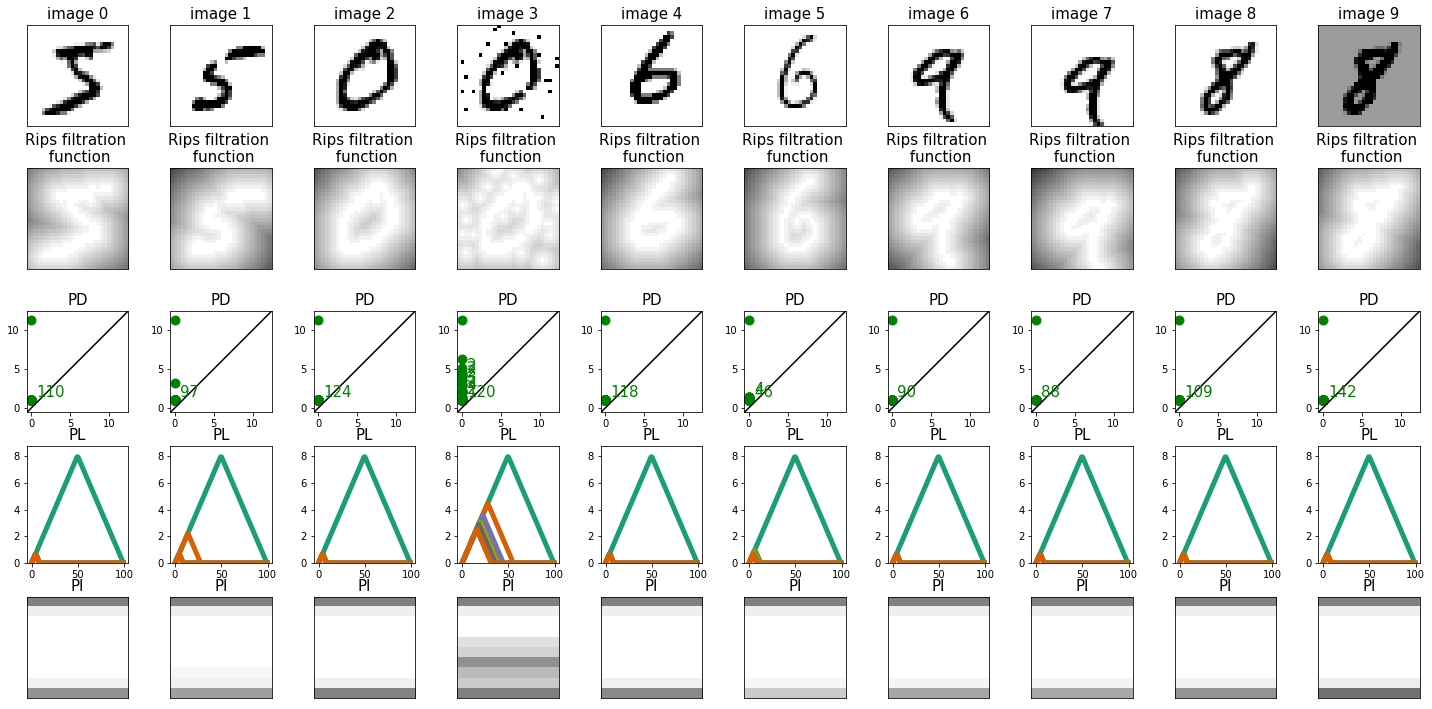

Inetermezzo: The image  55 under  salt and pepper noise 5 has the darkest pixel in a persistence image:
max_data_sign_homdim_filt[PI, homdim, filt] = 127.33806955199452


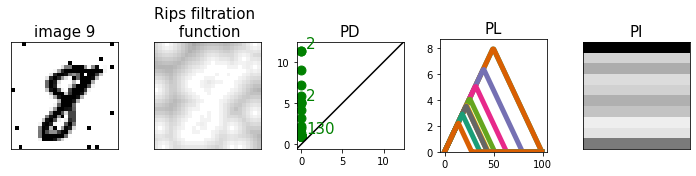

Distance matrices should have pretty white 2x2 pixel patches around the diagonal, d(non-noisy, noisy), for noise robustness;
and dark pixels outside, d(one class, other class), for discriminative power. 


Distances between images in the same class (0 for images 1 and 2, 6 for images 3 and 4, 9 for images 5 and 6)
are more reasonable for persistent homology than original image representation as greyscale pixel values
(note the small bright squares around the diagonal in Wasserstein distance matrices)! 


Consider also if distance matrices between PDs, PLs, PIs reflect each other.


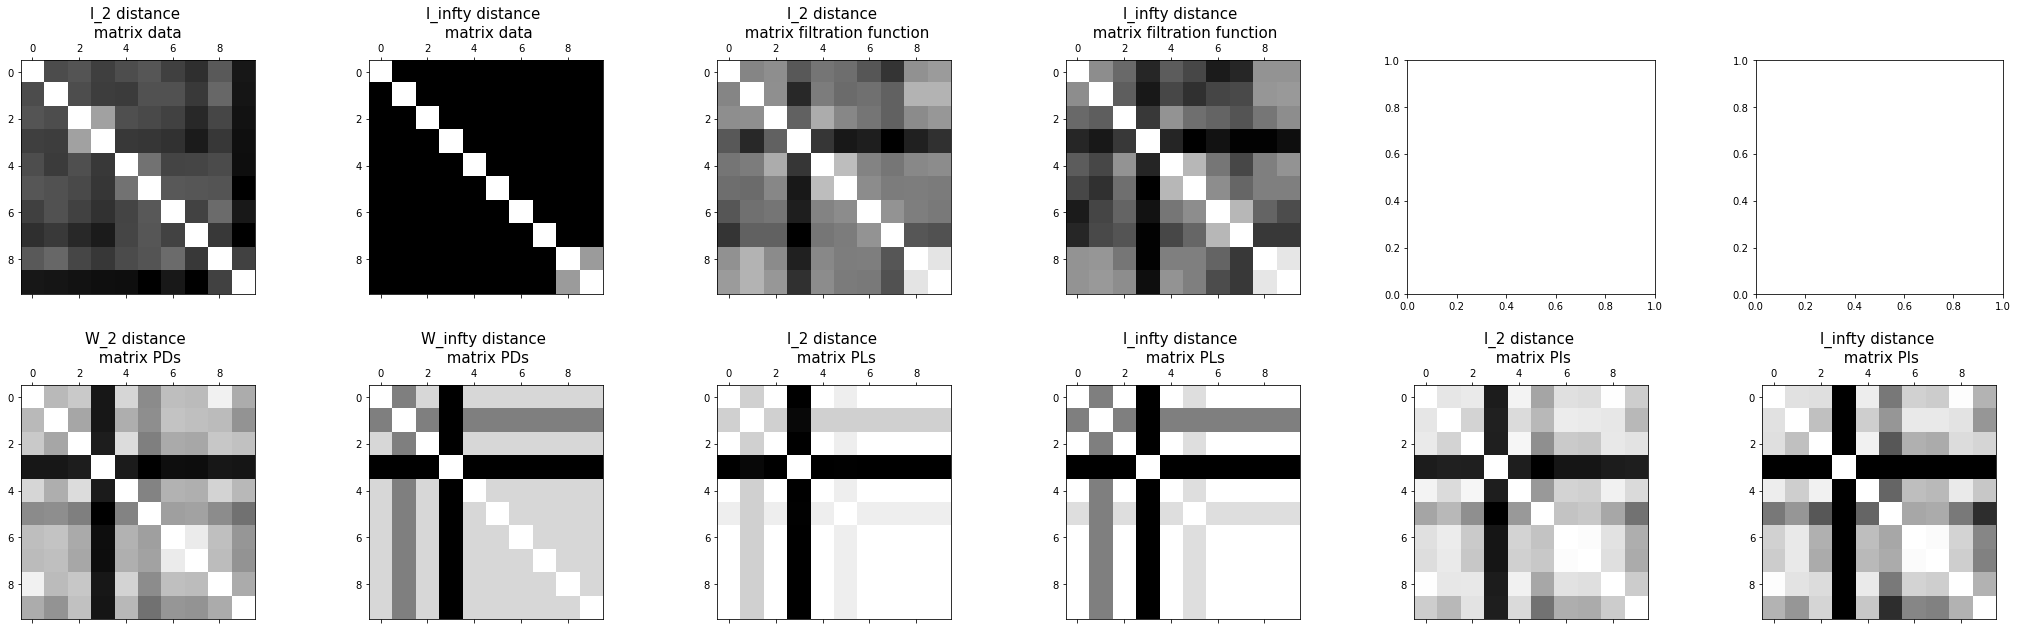

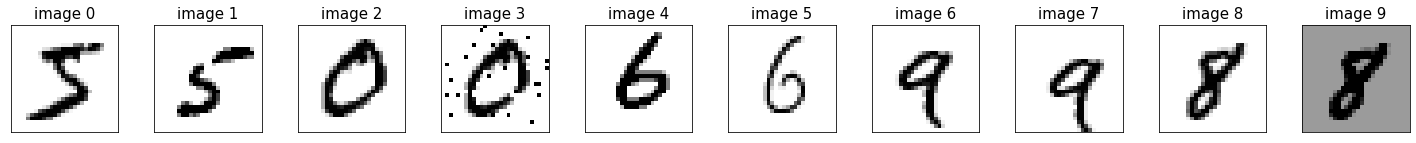

In [28]:
# Auxilary cell to visualize the persistent homology information across signatures, 
# for some filtration and homological dimension, 
# and to guide the choice of parameters for filtrations and persistence signatures in the cells above
# (based on the trade off between noise robustness and discriminative power across classes).
# The figure is similar to Table 1 in turkevs2021noise, but on actual noise considered in the data, 
# and we also do not only look at the filtration function and persistent homology information for an image and its noisy variant,
# but rather compare this against an image from another class (and its noisy variants).
# We also look at the Wasserstein or l2 distances between these data points.

# Choose interesting example data points, noisy versions of the same image, different examples from the same class,
# and different classes.
example_1 = 0
example_2 = 47 #
example_3 = 1
example_4 = 1 # salt and pepper noise
example_5 = 66 
example_6 = 18
example_7 = 4
example_8 = 4 # translation 
example_9 = 17
example_10 = 17 # brightness

data_point_1 = np.copy(data[example_1])
data_point_2 = np.copy(data[example_2]) # 47
data_point_3 = np.copy(data[example_3])
data_point_4 = np.copy(data_trnsf["salt and pepper noise 10"][example_4])
data_point_5 = np.copy(data[example_5]) # 66
data_point_6 = np.copy(data[example_6])
data_point_7 = np.copy(data[example_7])
data_point_8 = np.copy(data_trnsf["translation -2 -2"][example_8])
data_point_9 = np.copy(data[example_9])
data_point_10 = np.copy(data_trnsf["brightness 100"][example_10])
data_temp = np.asarray([data_point_1, data_point_2, data_point_3, data_point_4, data_point_5, data_point_6, data_point_7, 
                        data_point_8, data_point_9, data_point_10])

# Choose filtration function.
filt = "Rips"

filt_func_vals_1 = np.copy(data_filt_trnsf[filt, "no noise"][example_1])
filt_func_vals_2 = np.copy(data_filt_trnsf[filt, "no noise"][example_2])
filt_func_vals_3 = np.copy(data_filt_trnsf[filt, "no noise"][example_3])
filt_func_vals_4 = np.copy(data_filt_trnsf[filt, "salt and pepper noise 10"][example_4])
filt_func_vals_5 = np.copy(data_filt_trnsf[filt, "no noise"][example_5])
filt_func_vals_6 = np.copy(data_filt_trnsf[filt, "no noise"][example_6])
filt_func_vals_7 = np.copy(data_filt_trnsf[filt, "no noise"][example_7])
filt_func_vals_8 = np.copy(data_filt_trnsf[filt, "translation -2 -2"][example_8])
filt_func_vals_9 = np.copy(data_filt_trnsf[filt, "no noise"][example_9])
filt_func_vals_10 = np.copy(data_filt_trnsf[filt, "brightness 100"][example_10])
filt_func_vals_temp = [filt_func_vals_1, filt_func_vals_2, filt_func_vals_3, filt_func_vals_4, 
                       filt_func_vals_5, filt_func_vals_6, filt_func_vals_7, filt_func_vals_8,
                       filt_func_vals_9, filt_func_vals_10]

# Choose homological dimension.
homdim = "0-dim"

# Calculate PDs.
PD_1 = np.copy(data_sign_homdim_filt_trnsf["PD", homdim, filt, "no noise"][example_1])
PD_2 = np.copy(data_sign_homdim_filt_trnsf["PD", homdim, filt, "no noise"][example_2])
PD_3 = np.copy(data_sign_homdim_filt_trnsf["PD", homdim, filt, "no noise"][example_3])
PD_4 = np.copy(data_sign_homdim_filt_trnsf["PD", homdim, filt, "salt and pepper noise 10"][example_4])
PD_5 = np.copy(data_sign_homdim_filt_trnsf["PD", homdim, filt, "no noise"][example_5])
PD_6 = np.copy(data_sign_homdim_filt_trnsf["PD", homdim, filt, "no noise"][example_6])
PD_7 = np.copy(data_sign_homdim_filt_trnsf["PD", homdim, filt, "no noise"][example_7])
PD_8 = np.copy(data_sign_homdim_filt_trnsf["PD", homdim, filt, "translation -2 -2"][example_8])
PD_9 = np.copy(data_sign_homdim_filt_trnsf["PD", homdim, filt, "no noise"][example_9])
PD_10 = np.copy(data_sign_homdim_filt_trnsf["PD", homdim, filt, "brightness 100"][example_10])
PDs_temp = [PD_1, PD_2, PD_3, PD_4, PD_5, PD_6, PD_7, PD_8, PD_9, PD_10]     

# Calculate PLs.
PL_1 = np.copy(data_sign_homdim_filt_trnsf["PL", homdim, filt, "no noise"][example_1])
PL_2 = np.copy(data_sign_homdim_filt_trnsf["PL", homdim, filt, "no noise"][example_2])
PL_3 = np.copy(data_sign_homdim_filt_trnsf["PL", homdim, filt, "no noise"][example_3])
PL_4 = np.copy(data_sign_homdim_filt_trnsf["PL", homdim, filt, "salt and pepper noise 10"][example_4])
PL_5 = np.copy(data_sign_homdim_filt_trnsf["PL", homdim, filt, "no noise"][example_5])
PL_6 = np.copy(data_sign_homdim_filt_trnsf["PL", homdim, filt, "no noise"][example_6])
PL_7 = np.copy(data_sign_homdim_filt_trnsf["PL", homdim, filt, "no noise"][example_7])
PL_8 = np.copy(data_sign_homdim_filt_trnsf["PL", homdim, filt, "translation -2 -2"][example_8])
PL_9 = np.copy(data_sign_homdim_filt_trnsf["PL", homdim, filt, "no noise"][example_9])
PL_10 = np.copy(data_sign_homdim_filt_trnsf["PL", homdim, filt, "brightness 100"][example_10])
PLs_temp = [PL_1, PL_2, PL_3, PL_4, PL_5, PL_6, PL_7, PL_8, PL_9, PL_10]

# Calculate PIs.
PI_1 = np.copy(data_sign_homdim_filt_trnsf["PI", homdim, filt, "no noise"][example_1])
PI_2 = np.copy(data_sign_homdim_filt_trnsf["PI", homdim, filt, "no noise"][example_2])
PI_3 = np.copy(data_sign_homdim_filt_trnsf["PI", homdim, filt, "no noise"][example_3])
PI_4 = np.copy(data_sign_homdim_filt_trnsf["PI", homdim, filt, "salt and pepper noise 10"][example_4])
PI_5 = np.copy(data_sign_homdim_filt_trnsf["PI", homdim, filt, "no noise"][example_5])
PI_6 = np.copy(data_sign_homdim_filt_trnsf["PI", homdim, filt, "no noise"][example_6])
PI_7 = np.copy(data_sign_homdim_filt_trnsf["PI", homdim, filt, "no noise"][example_7])
PI_8 = np.copy(data_sign_homdim_filt_trnsf["PI", homdim, filt, "translation -2 -2"][example_8])
PI_9 = np.copy(data_sign_homdim_filt_trnsf["PI", homdim, filt, "no noise"][example_9])
PI_10 = np.copy(data_sign_homdim_filt_trnsf["PI", homdim, filt, "brightness 100"][example_10])
PIs_temp = [PI_1, PI_2, PI_3, PI_4, PI_5, PI_6, PI_7, PI_8, PI_9, PI_10]

# Plot images, PDs, PLs and PIs.
num_fig_rows = 5
num_fig_cols = data_temp.shape[0]
subfig_height = 2
subfig_width = 2
fig, axes = plt.subplots(num_fig_rows, num_fig_cols, figsize = (num_fig_cols * subfig_width, num_fig_rows * subfig_height)) 
fig.tight_layout(pad = 0.5) 
for column, data_point in enumerate(data_temp):
    # Image.
    image = np.copy(data_temp[column])
    image = image.reshape((num_x_pixels, num_y_pixels))
    plot_image(image, vmin = min_data, vmax = max_data, axes = axes[0, column])
    axes[0, column].set_title("image %d" %column, fontsize = 15)
    # Filtration function values.
    filt_func_vals = np.copy(filt_func_vals_temp[column])
    filt_func_vals = filt_func_vals.reshape((num_x_pixels, num_y_pixels))
    plot_image(filt_func_vals, vmin = 0, vmax = max_data_filt[filt], axes = axes[1, column]) 
    axes[1, column].set_title(filt + " filtration \n function", fontsize = 15)
    # PD.
    PD = np.copy(PDs_temp[column])
    plot_PD(PD, xymax = max_death_PDs_homdim_filt[homdim, filt], axes = axes[2, column]) 
    axes[2, column].set_title("PD", fontsize = 15) 
    # PL.
    PL = np.copy(PLs_temp[column])
    plot_PL(PL, num_lndscs = PL_num, lndsc_resolution = PL_resolution, ymax = max_data_sign_homdim_filt["PL", homdim, filt], axes = axes[3, column])
    axes[3, column].set_title("PL", fontsize = 15)
    # PI.
    PI = np.copy(PIs_temp[column])
    plot_PI(PI, PI_resolution, vmin = 0, vmax = max_data_sign_homdim_filt["PI", homdim, filt], axes = axes[4, column])
    axes[4, column].set_title("PI", fontsize = 15)     
plt.show()

# Identify the image with the longest/most persistent cycle.
max_PIs = 0
max_PIs_trnsf = 0
for trnsf in trnsfs:    
    for i, PI in enumerate(data_sign_homdim_filt_trnsf["PI", homdim, filt, trnsf]):
        max_PI_trnsf_i = np.max(PI)
        if max_PI_trnsf_i > max_PIs_trnsf:
            max_PIs_trnsf = max_PI_trnsf_i
            i_max = i
    if max_PIs_trnsf > max_PIs:
        max_PIs = max_PIs_trnsf
        trnsf_max = trnsf        
print("Inetermezzo: The image ", i_max,  "under ", trnsf_max, "has the darkest pixel in a persistence image:")
print("max_data_sign_homdim_filt[PI, homdim, filt] =", max_data_sign_homdim_filt["PI", homdim, filt])
image_max = data_images_trnsf[trnsf_max][i_max]
filt_func_vals_max = data_filt_trnsf[filt, trnsf_max][i_max]
PD_max = data_sign_homdim_filt_trnsf["PD", homdim, filt, trnsf_max][i_max]
PL_max = data_sign_homdim_filt_trnsf["PL", homdim, filt, trnsf_max][i_max]
PI_max = data_sign_homdim_filt_trnsf["PI", homdim, filt, trnsf_max][i_max]

# Plot image, PD, PL and PI for the image that has the darkest pixel in a persistence image.
num_fig_rows = 1
num_fig_cols = 5
subfig_height = 2
subfig_width = 2
fig, axes = plt.subplots(num_fig_rows, num_fig_cols, figsize = (num_fig_cols * subfig_width, num_fig_rows * subfig_height)) 
fig.tight_layout(pad = 0.5) 
# Image.
plot_image(image_max, vmin = min_data, vmax = max_data, axes = axes[0])
axes[0].set_title("image %d" %column, fontsize = 15)
# Filtration function values.
filt_func_vals_max = filt_func_vals_max.reshape((num_x_pixels, num_y_pixels))
plot_image(filt_func_vals_max, vmin = 0, vmax = max_data_filt[filt], axes = axes[1]) 
axes[1].set_title(filt + " filtration \n function", fontsize = 15)
# PD.
plot_PD(PD_max, xymax = max_death_PDs_homdim_filt[homdim, filt], axes = axes[2]) 
axes[2].set_title("PD", fontsize = 15) 
# PL.
plot_PL(PL_max, num_lndscs = PL_num, lndsc_resolution = PL_resolution, ymax = max_data_sign_homdim_filt["PL", homdim, filt], axes = axes[3])
axes[3].set_title("PL", fontsize = 15)
# PI.
plot_PI(PI_max, PI_resolution, vmin = 0, vmax = max_data_sign_homdim_filt["PI", homdim, filt], axes = axes[4])
axes[4].set_title("PI", fontsize = 15)     
plt.show()

# Calculate distances between original data representations.
l_2_distance_matrix_data_temp = l_p_distance_matrix(data_temp, p = 2)
l_infty_distance_matrix_data_temp = l_p_distance_matrix(data_temp, p = np.inf)
# print("l_2_distance_matrix_data_temp = \n", np.around(l_2_distance_matrix_data_temp, 2))
# print("l_infty_distance_matrix_data_temp = \n", np.around(l_infty_distance_matrix_data_temp, 2))
# print()

# Calculate distances between filtration functions.
l_2_distance_matrix_filt_func_vals_temp = l_p_distance_matrix(filt_func_vals_temp, p = 2)
l_infty_distance_matrix_filt_func_vals_temp = l_p_distance_matrix(filt_func_vals_temp, p = np.inf)
# print("l_2_distance_matrix_filt_func_vals_temp = \n", np.around(l_2_distance_matrix_filt_func_vals_data_temp, 2))
# print("l_infty_distance_matrix_filt_func_vals_temp = \n", np.around(l_infty_distance_matrix_filt_func_vals_data_temp, 2))
# print()

# Calculate distances between PDs.
W_2_distance_matrix_PDs_temp = wasserstein_p_q_distance_matrix(PDs_temp, p = 2, q = np.inf)
W_infty_distance_matrix_PDs_temp = wasserstein_p_q_distance_matrix(PDs_temp, p = np.inf, q = np.inf)
# print("W_2_distance_matrix_PDs_temp = \n", np.around(W_2_distance_matrix_PDS_temp, 2))
# print("W_infty_distance_matrix_PDs_temp = \n", np.around(W_infty_distance_matrix_PDs_temp, 2))
# print()

# Calculate distances between PLs.
l_2_distance_matrix_PLs_temp = l_p_distance_matrix(PLs_temp, p = 2)
l_infty_distance_matrix_PLs_temp = l_p_distance_matrix(PLs_temp, p = np.inf)
# print("l_2_distance_matrix_PLs_temp = \n", np.around(l_2_distance_matrix_PLs_temp, 2))
# print("l_infty_distance_matrix_PLs_temp = \n", np.around(l_infty_distance_matrix_PLs_temp, 2))
# print()

# Calculate distances between PIs.
l_2_distance_matrix_PIs_temp = l_p_distance_matrix(PIs_temp, p = 2)
l_infty_distance_matrix_PIs_temp = l_p_distance_matrix(PIs_temp, p = np.inf)
# print("l_2_distance_matrix_data_PIs_temp = \n", np.around(l_2_distance_matrix_PIs_temp, 2))
# print("l_infty_distance_matrix_PIs_temp = \n", np.around(l_infty_distance_matrix_PIs_temp, 2))
# print()

# Plot distance matrices.
num_fig_rows = 2
num_fig_cols = 6
subfig_height = 5
subfig_width = 5
fig, axes = plt.subplots(num_fig_rows, num_fig_cols, figsize = (num_fig_cols * subfig_width, num_fig_rows * subfig_height)) 
fig.tight_layout(pad = 7.0) 
# Images.
axes[0, 0].matshow(l_2_distance_matrix_data_temp, cmap = plt.cm.gray_r)
axes[0, 0].set_title("l_2 distance \n matrix data ", fontsize = 15)  
axes[0, 1].matshow(l_infty_distance_matrix_data_temp, cmap = plt.cm.gray_r)
axes[0, 1].set_title("l_infty distance \n matrix data", fontsize = 15)  
# Filtration functions. 
axes[0, 2].matshow(l_2_distance_matrix_filt_func_vals_temp, cmap = plt.cm.gray_r)
axes[0, 2].set_title("l_2 distance \n matrix filtration function", fontsize = 15)  
axes[0, 3].matshow(l_infty_distance_matrix_filt_func_vals_temp, cmap = plt.cm.gray_r)
axes[0, 3].set_title("l_infty distance \n matrix filtration function", fontsize = 15)  
# PDs.
axes[1, 0].matshow(W_2_distance_matrix_PDs_temp, cmap = plt.cm.gray_r)
axes[1, 0].set_title("W_2 distance \n matrix PDs", fontsize = 15)  
axes[1, 1].matshow(W_infty_distance_matrix_PDs_temp, cmap = plt.cm.gray_r)
axes[1, 1].set_title("W_infty distance \n matrix PDs", fontsize = 15)  
# PLs.
axes[1, 2].matshow(l_2_distance_matrix_PLs_temp, cmap = plt.cm.gray_r)
axes[1, 2].set_title("l_2 distance \n matrix PLs", fontsize = 15)  
axes[1, 3].matshow(l_infty_distance_matrix_PLs_temp, cmap = plt.cm.gray_r)
axes[1, 3].set_title("l_infty distance \n matrix PLs", fontsize = 15)  
# PIs.
axes[1, 4].matshow(l_2_distance_matrix_PIs_temp, cmap = plt.cm.gray_r)
axes[1, 4].set_title("l_2 distance \n matrix PIs", fontsize = 15)  
axes[1, 5].matshow(l_infty_distance_matrix_PIs_temp, cmap = plt.cm.gray_r)
axes[1, 5].set_title("l_infty distance \n matrix PIs", fontsize = 15)  

print("Distance matrices should have pretty white 2x2 pixel patches around the diagonal, d(non-noisy, noisy), for noise robustness;")
print("and dark pixels outside, d(one class, other class), for discriminative power. \n")
print()
print("Distances between images in the same class (0 for images 1 and 2, 6 for images 3 and 4, 9 for images 5 and 6)")
print("are more reasonable for persistent homology than original image representation as greyscale pixel values")
print("(note the small bright squares around the diagonal in Wasserstein distance matrices)! \n")
print()
print("Consider also if distance matrices between PDs, PLs, PIs reflect each other.")

# Plot images once again to better interpret the distance matrices.
num_fig_rows = 1
num_fig_cols = data_temp.shape[0]
subfig_height = 2
subfig_width = 2
fig, axes = plt.subplots(num_fig_rows, num_fig_cols, figsize = (num_fig_cols * subfig_width, num_fig_rows * subfig_height)) 
fig.tight_layout(pad = 0.5) 
for column, data_point in enumerate(data_temp):
    # Image.
    image = np.copy(data_temp[column])
    image = image.reshape((num_x_pixels, num_y_pixels))
    plot_image(image, vmin = min_data, vmax = max_data, axes = axes[column])
    axes[column].set_title("image %d" %column, fontsize = 15)

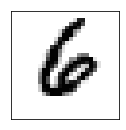

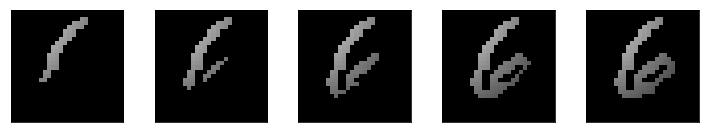

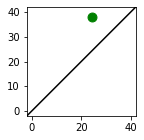

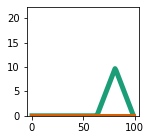

In [32]:
# Auxliary cell to visualize the persistent homology pipeline for an image 
# (Figure 1 in turkevs2021noise, top).
example = 13
subfig_height = 2
subfig_width = 2

# Image.
fig, axes = plt.subplots(1, 1, figsize = (subfig_width, subfig_height)) 
plot_image(data_images[example], vmin = min_data, vmax = max_data, axes = axes)
fig.savefig("FIGURES/pipeline_image")

# Filtration (radial).
filt_func_vals_percentages = np.asarray([0.5, 0.55, 0.6, 0.65, 0.7])
num_fig_cols = len(filt_func_vals_percentages)
fig, axes = plt.subplots(1, num_fig_cols, figsize = (num_fig_cols * subfig_width, subfig_height)) 
fig.tight_layout(pad = 0.05)
filt_func_vals = np.copy(data_filt_trnsf["radial", "no noise"][example])
filt_func_vals = filt_func_vals.reshape((num_x_pixels, num_y_pixels)) 
max_filt_func_val = max_data_filt["radial"]
for p, perc in enumerate(filt_func_vals_percentages):
    cubical_complex = np.zeros((num_x_pixels, num_y_pixels)) + max_filt_func_val
    filt_val_upper_limit = perc * max_filt_func_val
    for i in range(num_x_pixels):
        for j in range(num_y_pixels):
            if(filt_func_vals[i, j] < filt_val_upper_limit):
                cubical_complex[i, j] = filt_func_vals[i, j]      
    plot_image(cubical_complex, vmin = 0, vmax = max_data_filt["radial"], axes = axes[p])
fig.savefig("FIGURES/pipeline_image_filtration")

# PD.
PD = np.copy(data_sign_homdim_filt_trnsf["PD", "1-dim", "radial", "no noise"][example])
fig, axes = plt.subplots(1, 1, figsize = (subfig_width, subfig_height)) 
plot_PD(PD, xymax = max_death_PDs_homdim_filt["1-dim", "radial"], axes = axes)
fig.savefig("FIGURES/pipeline_image_PD")

# PL.
PL = np.copy(data_sign_homdim_filt_trnsf["PL", "1-dim", "radial", "no noise"][example])
fig, axes = plt.subplots(1, 1, figsize = (subfig_width, subfig_height)) 
plot_PL(PL, num_lndscs = PL_num, lndsc_resolution = PL_resolution, ymax = max_data_sign_homdim_filt["PL", "1-dim", "radial"], axes = axes)
fig.savefig("FIGURES/pipeline_image_PL")

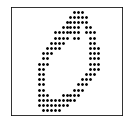

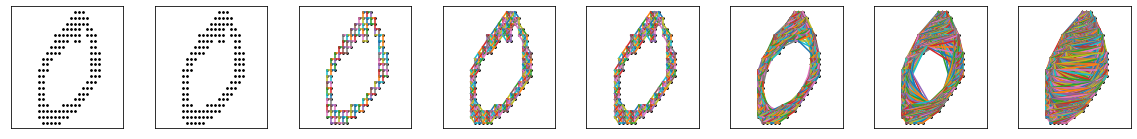

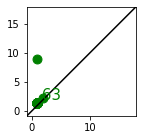

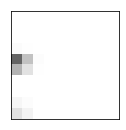

In [34]:
# Auxliary cell to visualize the persistent homology pipeline for a point cloud 
# (Figure 1 in turkevs2021noise, bottom).
example = 1 # 0
subfig_height = 2
subfig_width = 2

# Point cloud.
point_cloud = build_point_cloud(data[example], 0.5)
fig, axes = plt.subplots(1, 1, figsize = (subfig_width, subfig_height)) 
axes.scatter(point_cloud[:, 0], point_cloud[:, 1], c = "black", s = 3)
axes.set_xlim(0, num_x_pixels)
axes.set_xlim(0, num_y_pixels)
axes.set_xticks([])
axes.set_yticks([])
axes.set_xticklabels([])
axes.set_yticklabels([])
fig.savefig("FIGURES/pipeline_point_cloud")

# Filtration (Rips).
filt_func_vals = point_cloud
filt_func_vals_percentages = np.asarray([0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3])
num_fig_cols = len(filt_func_vals_percentages)
fig, axes = plt.subplots(1, num_fig_cols, figsize = (num_fig_cols * subfig_width, subfig_height)) 
fig.tight_layout(pad = 0.05)
for p, perc in enumerate(filt_func_vals_percentages):
    axes[p].scatter(filt_func_vals[:, 0], filt_func_vals[:, 1], c = "black", s = 3) 
    axes[p].set_xlim(0, num_x_pixels)
    axes[p].set_xlim(0, num_y_pixels)
    axes[p].set_xticks([])
    axes[p].set_yticks([])
    axes[p].set_xticklabels([])
    axes[p].set_yticklabels([])
    max_filt_func_val = np.sqrt(num_x_pixels**2 + num_y_pixels**2) # maximum possible edge lenght for rips
    filt_val_upper_limit = perc * max_filt_func_val
    simplicial_complex = gd.RipsComplex(points = filt_func_vals, max_edge_length = np.inf)
    simplex_tree = simplicial_complex.create_simplex_tree(max_dimension = 2)         
    for simplex_filt in simplex_tree.get_skeleton(1):
        simplex = simplex_filt[0]
        filt = simplex_filt[1]
        if len(simplex) == 2 and filt <= filt_val_upper_limit:
            vertex_1_num = simplex[0]
            vertex_2_num = simplex[1]
            vertex_1_x_y_coords = filt_func_vals[vertex_1_num]
            vertex_2_x_y_coords = filt_func_vals[vertex_2_num]
            edge_x_vals = [vertex_1_x_y_coords[0], vertex_2_x_y_coords[0]]
            edge_y_vals = [vertex_1_x_y_coords[1], vertex_2_x_y_coords[1]]
            axes[p].plot(edge_x_vals, edge_y_vals)  
fig.savefig("FIGURES/pipeline_point_cloud_filtration")

# PD.
PD = np.copy(data_sign_homdim_filt_trnsf["PD", "1-dim", "Rips", "no noise"][example])
fig, axes = plt.subplots(1, 1, figsize = (subfig_width, subfig_height)) 
plot_PD(PD, xymax = max_death_PDs_homdim_filt["1-dim", "Rips"], axes = axes)
fig.savefig("FIGURES/pipeline_point_cloud_PD")

# PI.
PI = np.copy(data_sign_homdim_filt_trnsf["PI", "1-dim", "Rips", "no noise"][example])
fig, axes = plt.subplots(1, 1, figsize = (subfig_width, subfig_height))     
plot_PI(PI, PI_resolution, vmin = 0, vmax = 0.35 * max_data_sign_homdim_filt["PI", "1-dim", "Rips"], axes = axes)
fig.savefig("FIGURES/pipeline_point_cloud_PI")

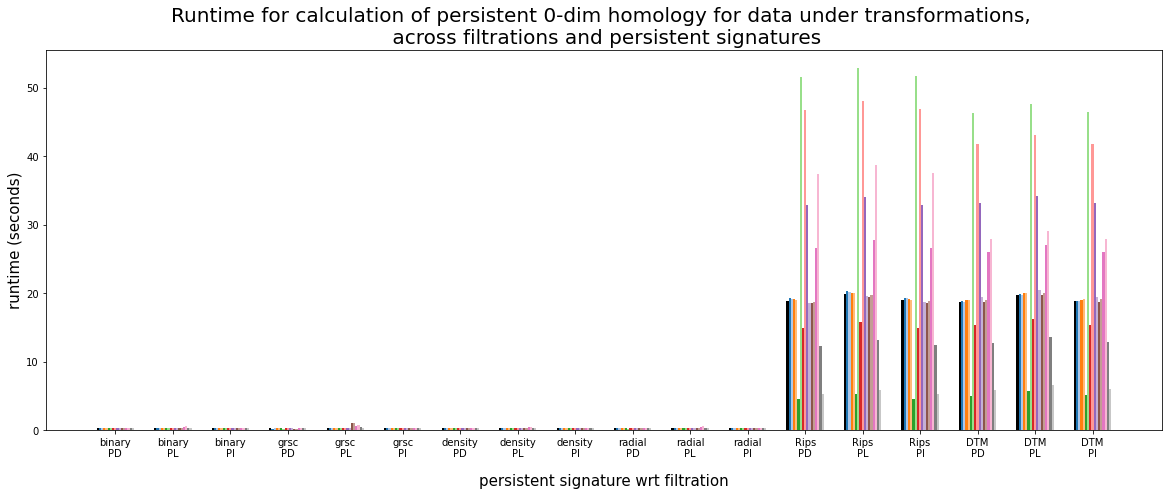

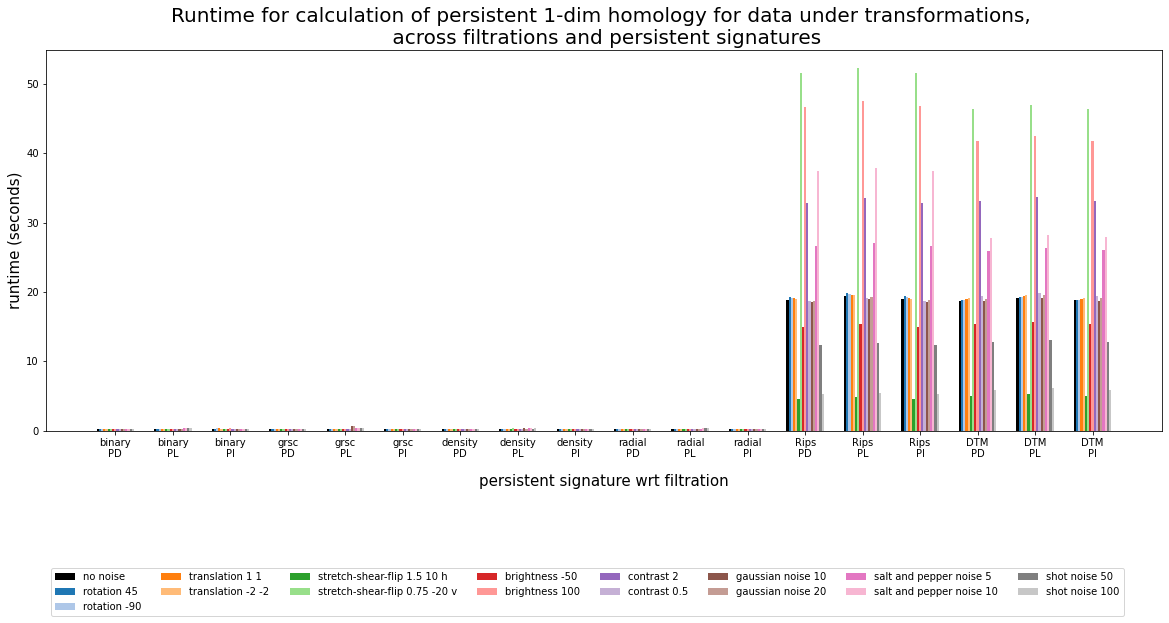

In [35]:
# How long does it take to construct persistent homology information?

# Figure 1-2 x-axis list of labels.
filts_signs = [filt + "\n" + sign for filt in filts for sign in signs]

# Figure 1: homdim0.
# Figure 1 y-axis, per different transformations (colors, or legend items), dictionary of lists.
runtime_data_homdim0_trnsfs = {}
for trnsf in trnsfs:
    runtime_data_homdim0_trnsfs[trnsf] = [np.around(runtime_data_sign_homdim_filt_trnsf[sign, "0-dim", filt, trnsf], 2)
                                          for filt in filts
                                          for sign in signs]  
fig, axes = plot_bar_containers(filts_signs, runtime_data_homdim0_trnsfs, trnsfs)
axes.set_xlabel("persistent signature wrt filtration", fontsize = 15, labelpad = 15)
axes.set_ylabel("runtime (seconds)", fontsize = 15)
axes.set_title("Runtime for calculation of persistent 0-dim homology for data under transformations, \n across filtrations and persistent signatures", fontsize = 20)

# Figure 2: homdim1.
# Figure 2 y-axis, per different transformations (colors, or legend items), dictionary of lists.
runtime_data_homdim1_trnsfs = {}
for trnsf in trnsfs:
    runtime_data_homdim1_trnsfs[trnsf] = [np.around(runtime_data_sign_homdim_filt_trnsf[sign, "1-dim", filt, trnsf], 2)
                                          for filt in filts
                                          for sign in signs]  
fig, axes = plot_bar_containers(filts_signs, runtime_data_homdim1_trnsfs, trnsfs)
axes.set_xlabel("persistent signature wrt filtration", fontsize = 15, labelpad = 15)
axes.set_ylabel("runtime (seconds)", fontsize = 15)
axes.set_title("Runtime for calculation of persistent 1-dim homology for data under transformations, \n across filtrations and persistent signatures", fontsize = 20)

# Figure 2 legend.
legend = axes.legend(trnsfs, loc = "lower left", bbox_to_anchor=(0, -0.5), ncol = 8, fontsize = 10)
for t, line in enumerate(legend.get_lines()):
    line.set_linewidth(4.0)    
plt.show()

## 2) Noise robustness  

In this section, we use the two dictionaries calculated in 5.1), data_filt_trnsf and data_sign_homdim_filt_trnsf, to gain some insights to the first research question identified in the manuscript:
> (RQ1) In what way, and to which degree, is the persistent homology information sensitive to noise, calculated with respect to different filtrations and persistent signatures?

To do so, we first visualize an example image under different transformations, represented with its filtration function values or persistent homology information. Next, we evaluate the distances between a non-noisy and noisy image, when the image is represented with its filtration function values or persistent homology information, stored in dictionaries: 
- $\color{red}{\text{dists_filt_trnsf_data_data}}$
- $\color{red}{\text{dists_sign_homdim_filt_trnsf_data_data}}$

which have as elements, e.g.,:
- dists_filt_trnsf_data_data[greyscale, rotation 1] = num_data_points x 1 array, l_p distances between the non-noisy and rotated images, represented with its filtration function values
- dists_sign_homdim_filt_trnsf_data_data[PD, 0-dim, density, rotation 1] = num_data_points x 1 array, W_p distances between the non-noosy and rotated images, represented with with its 0-dim PD (list of persistence intervals) wrt cubical density filtration
- dists_sign_homdim_filt_trnsf_data_data[PL, 0-dim, density, rotation 1] = num_data_points x 1 array, l_p distances between the non-nosi and rotated images, represented with with its 0-dim persistent landscape (a vector) wrt cubical density filtration

A table summary of these distances gives some insights into how much does a noisy image differ from the non-noisy image.

In [36]:
# Load the variables.
trnsfs = ["no noise", 
          "rotation 45", "rotation -90", "translation 1 1", "translation -2 -2", "stretch-shear-flip 1.5 10 h", "stretch-shear-flip 0.75 -20 v",
          "brightness -50", "brightness 100", "contrast 2", "contrast 0.5",
          "gaussian noise 10", "gaussian noise 20", "salt and pepper noise 5", "salt and pepper noise 10", "shot noise 50", "shot noise 100"]
filts = ["binary", "grsc", "density", "radial", "Rips", "DTM"]
homdims = ["0-dim", "1-dim"]
signs = ["PD", "PL", "PI"]

with open("VARIABLES/data_trnsf.pkl", "rb") as f:
    data_trnsf = pickle.load(f)
with open("VARIABLES/data_filt_trnsf.pkl", "rb") as f:
    data_filt_trnsf = pickle.load(f)
with open("VARIABLES/data_sign_homdim_filt_trnsf.pkl", "rb") as f:
    data_sign_homdim_filt_trnsf = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'VARIABLES/data_trnsf.pkl'

An example image, under transformations (in columns):


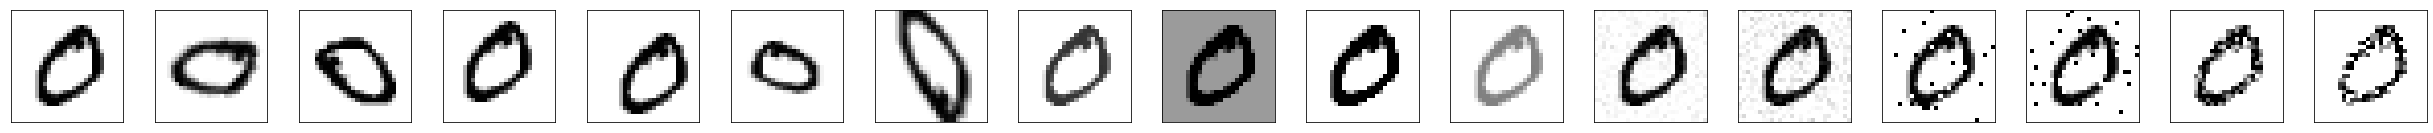

The example image, represented with its binary filtration function values, under transformations (in columns):


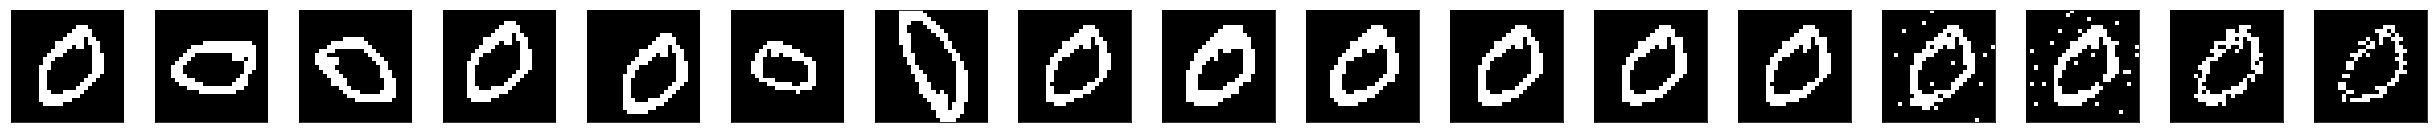

The example image, represented with its 0-dim persistence diagrams wrt binary filtration, under transformations (in columns):


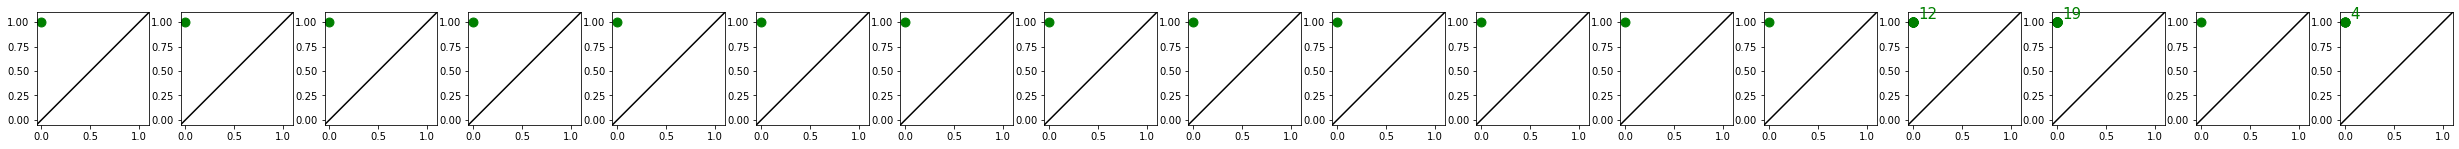

The example image, represented with its 0-dim persistence landscapes wrt binary filtration, under transformations (in columns):


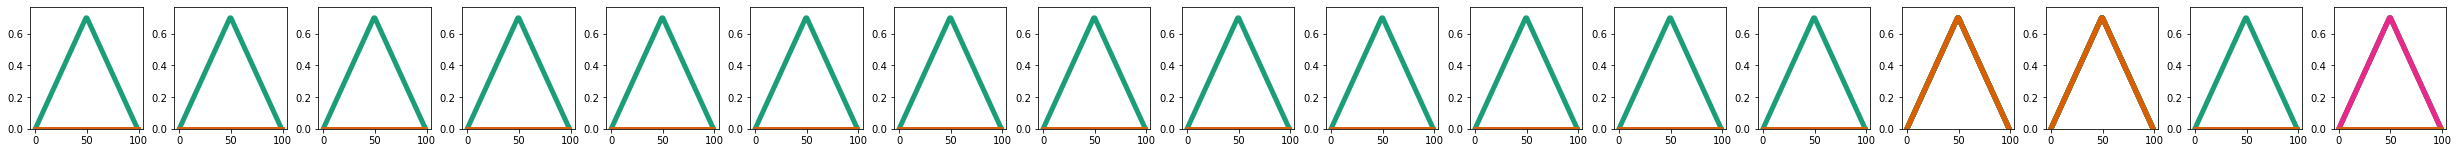

The example image, represented with  0-dim persistence images wrt binary filtration, under transformations (in columns):


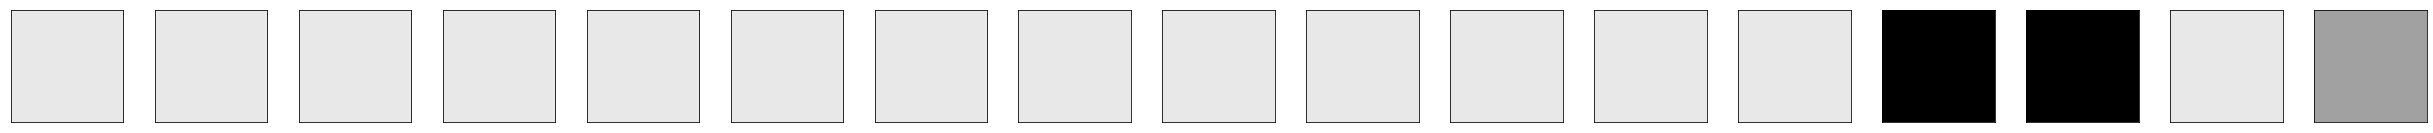

The example image, represented with its grsc filtration function values, under transformations (in columns):


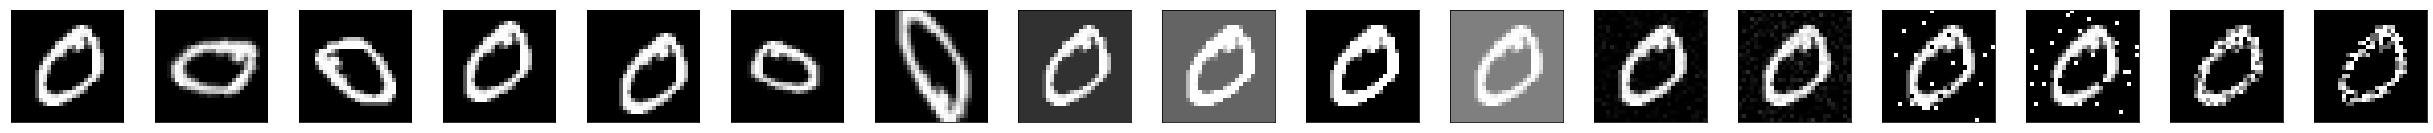

The example image, represented with its 0-dim persistence diagrams wrt grsc filtration, under transformations (in columns):


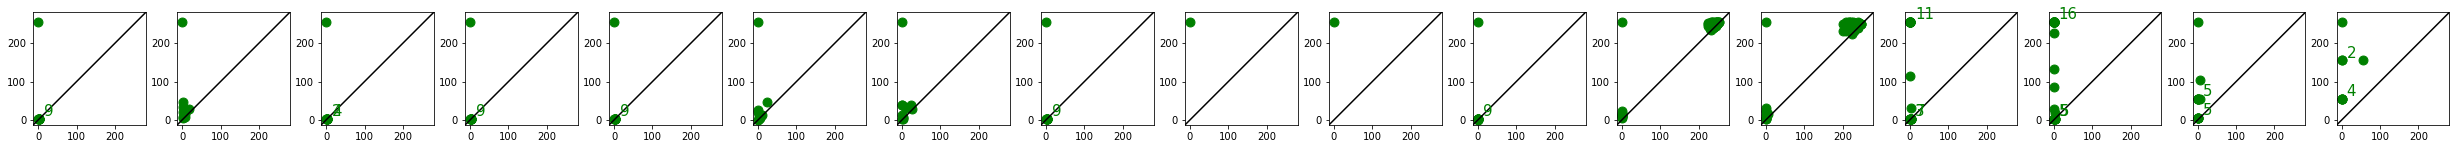

The example image, represented with its 0-dim persistence landscapes wrt grsc filtration, under transformations (in columns):


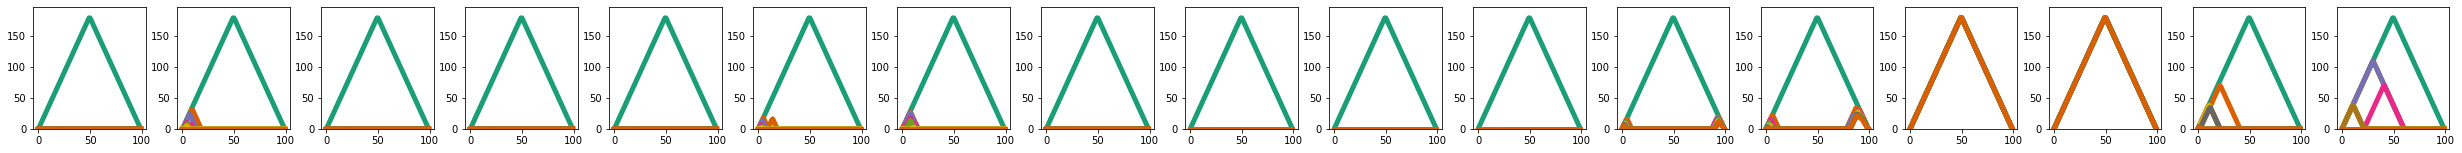

The example image, represented with  0-dim persistence images wrt grsc filtration, under transformations (in columns):


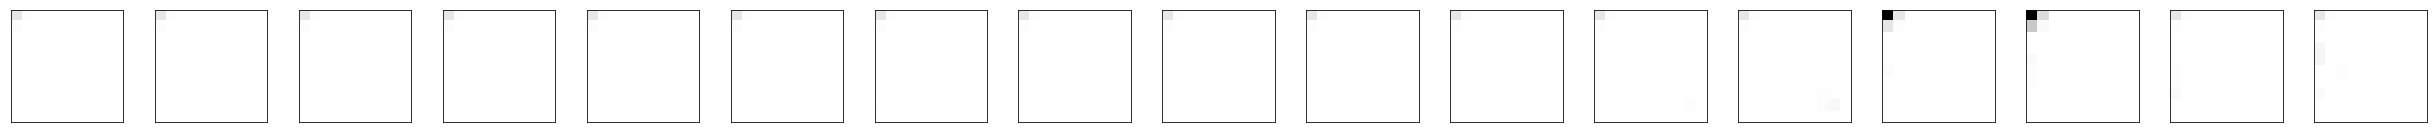

The example image, represented with its density filtration function values, under transformations (in columns):


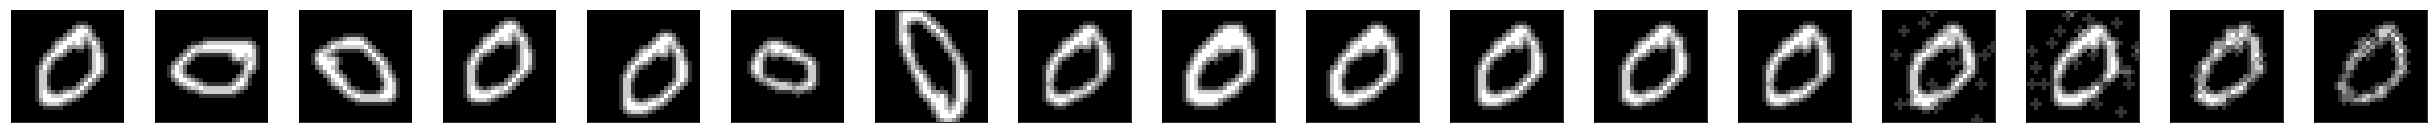

The example image, represented with its 0-dim persistence diagrams wrt density filtration, under transformations (in columns):


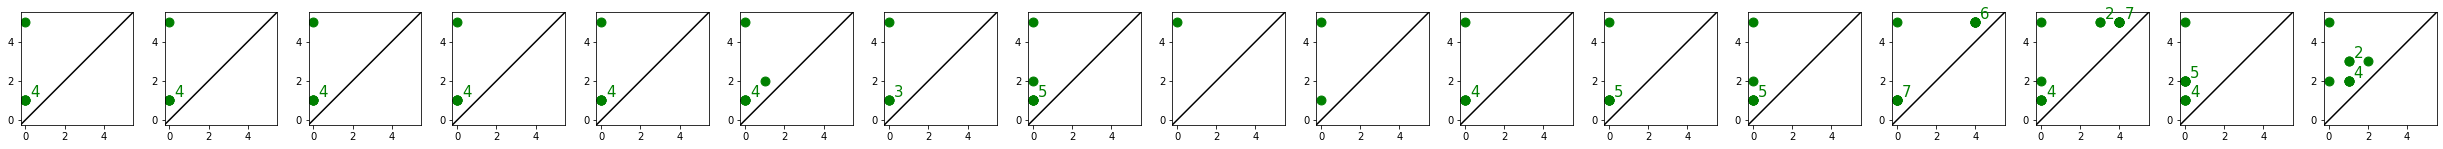

The example image, represented with its 0-dim persistence landscapes wrt density filtration, under transformations (in columns):


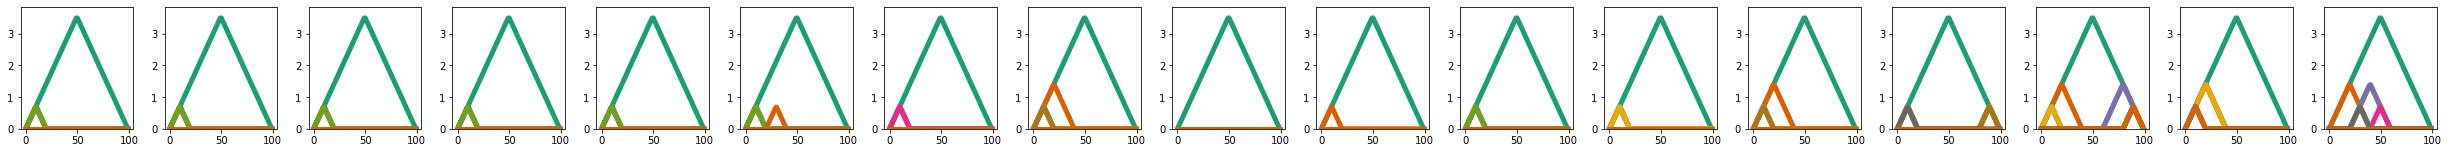

The example image, represented with  0-dim persistence images wrt density filtration, under transformations (in columns):


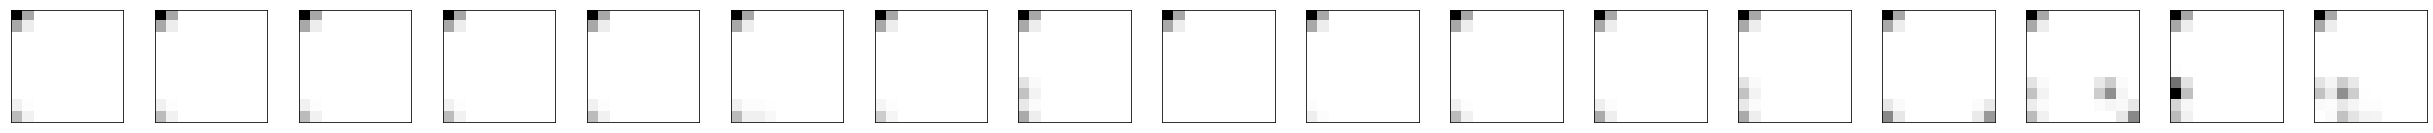

The example image, represented with its radial filtration function values, under transformations (in columns):


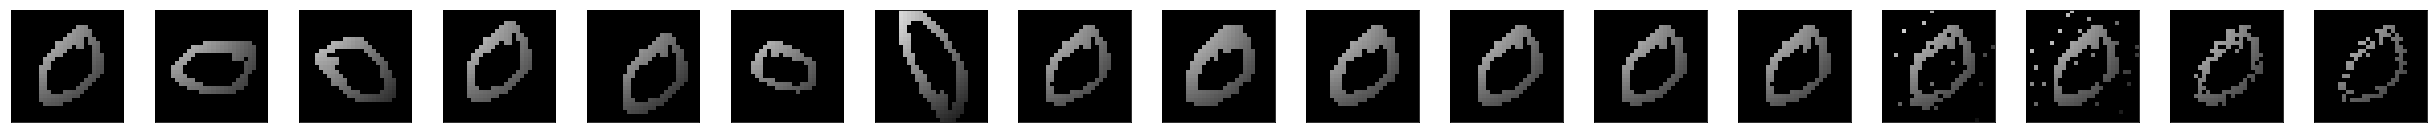

The example image, represented with its 0-dim persistence diagrams wrt radial filtration, under transformations (in columns):


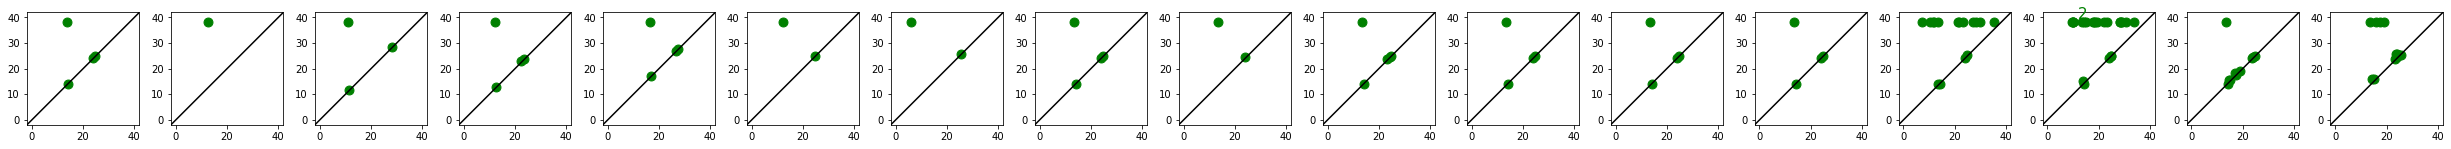

The example image, represented with its 0-dim persistence landscapes wrt radial filtration, under transformations (in columns):


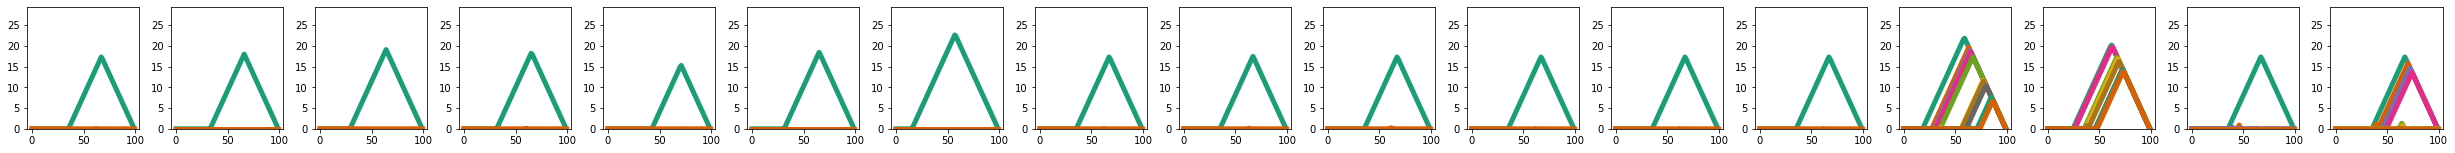

The example image, represented with  0-dim persistence images wrt radial filtration, under transformations (in columns):


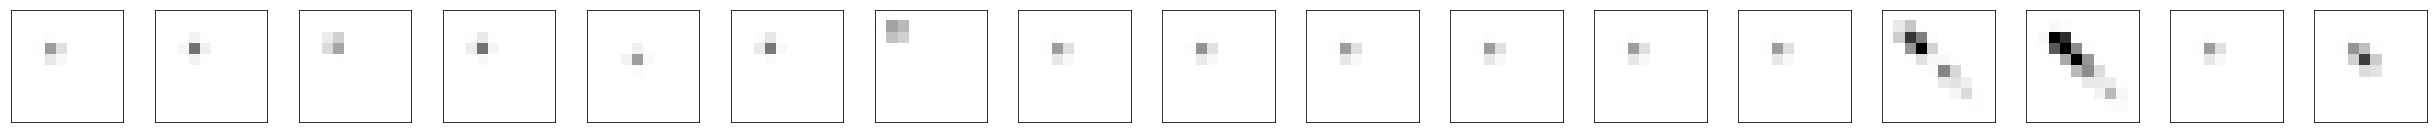

The example image, represented with its Rips filtration function values, under transformations (in columns):


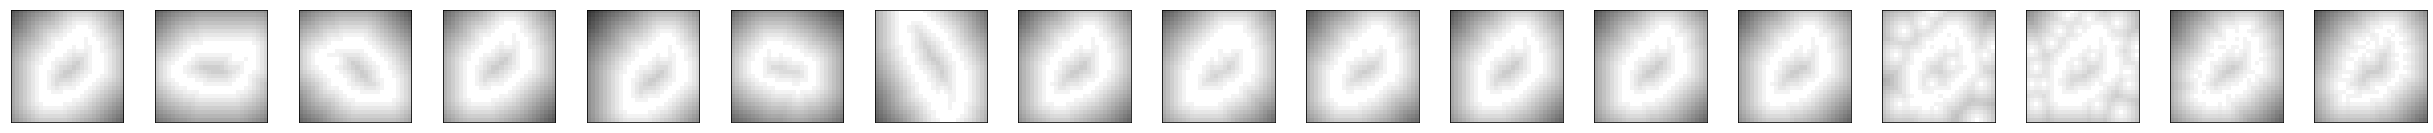

The example image, represented with its 0-dim persistence diagrams wrt Rips filtration, under transformations (in columns):


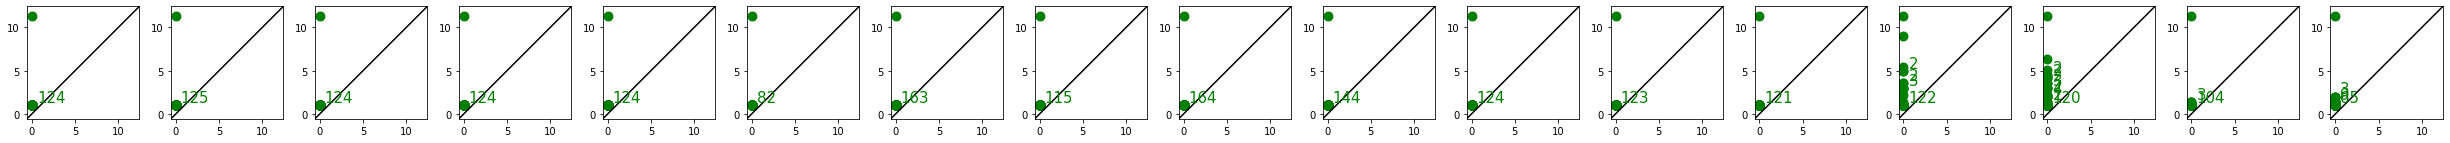

The example image, represented with its 0-dim persistence landscapes wrt Rips filtration, under transformations (in columns):


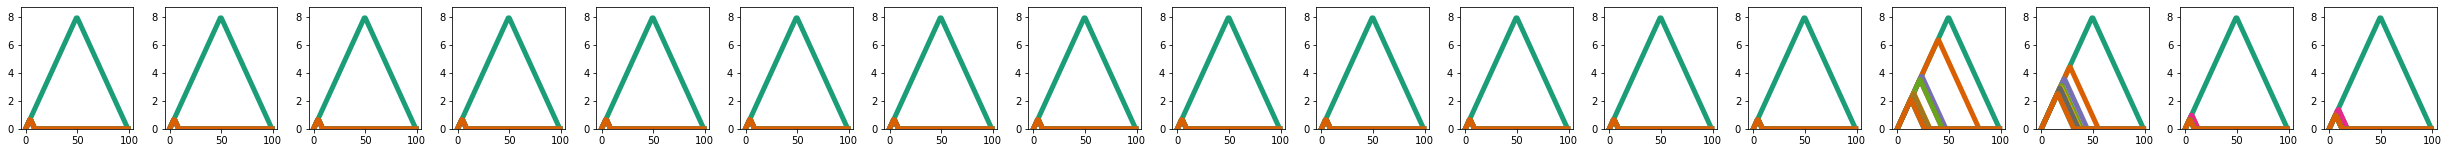

The example image, represented with  0-dim persistence images wrt Rips filtration, under transformations (in columns):


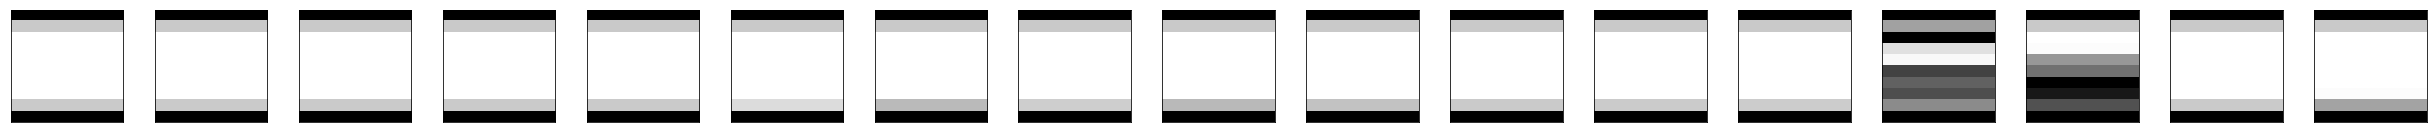

The example image, represented with its DTM filtration function values, under transformations (in columns):


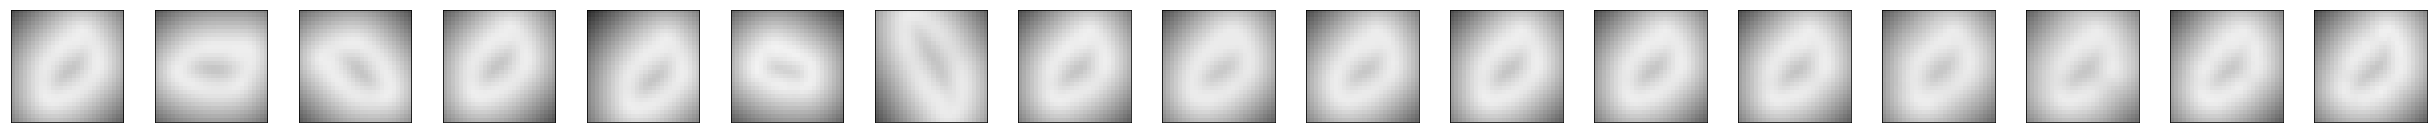

The example image, represented with its 0-dim persistence diagrams wrt DTM filtration, under transformations (in columns):


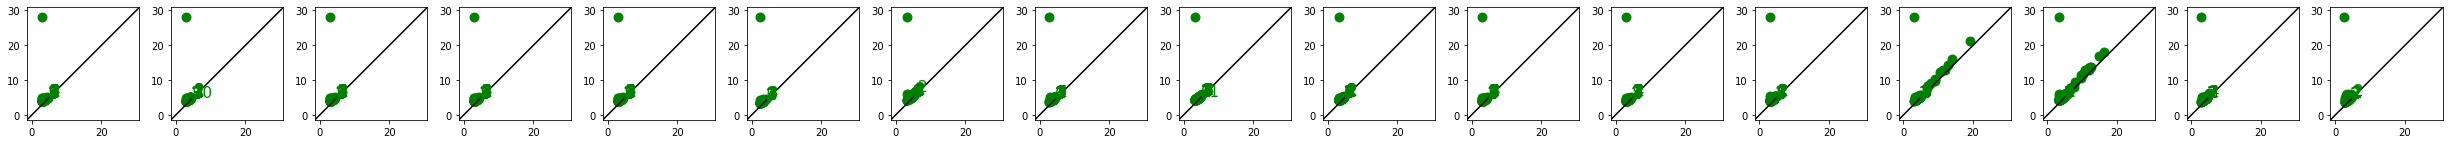

The example image, represented with its 0-dim persistence landscapes wrt DTM filtration, under transformations (in columns):


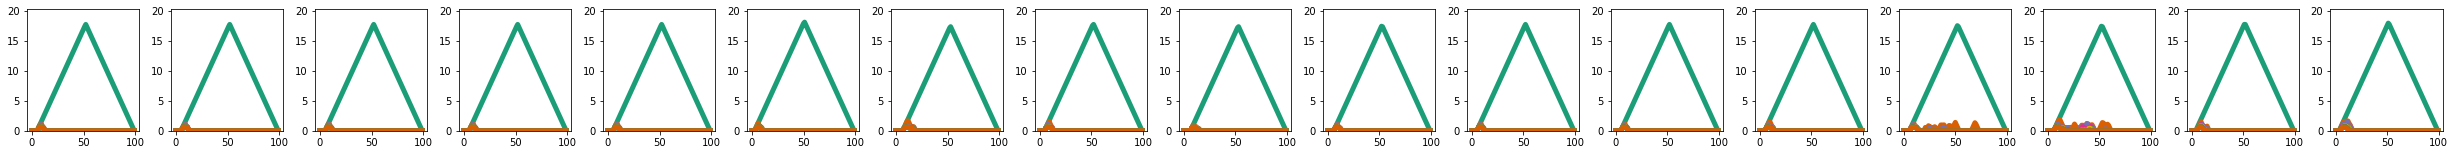

The example image, represented with  0-dim persistence images wrt DTM filtration, under transformations (in columns):


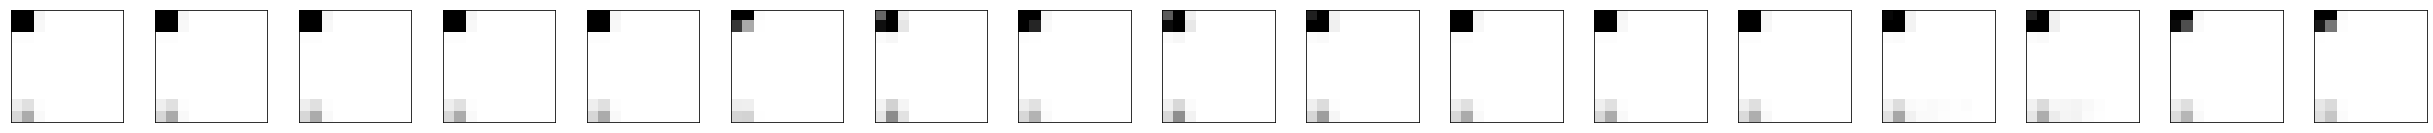

The example image, represented with its binary filtration function values, under transformations (in columns):


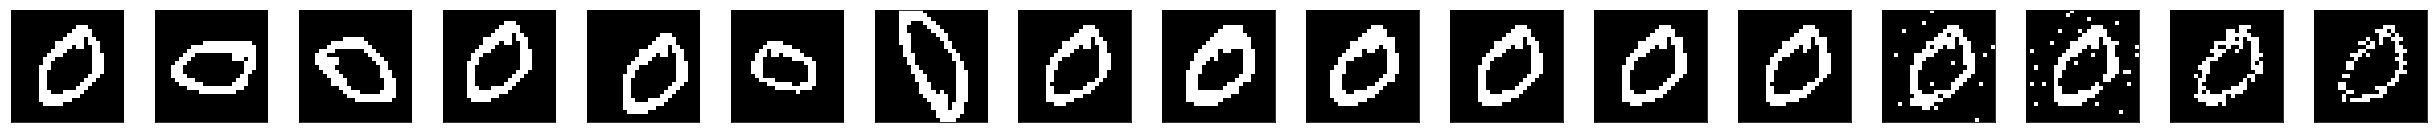

The example image, represented with its 1-dim persistence diagrams wrt binary filtration, under transformations (in columns):


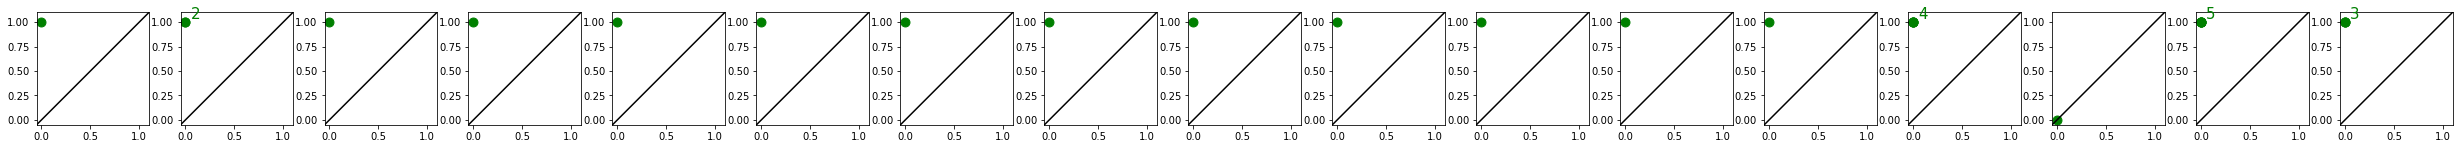

The example image, represented with its 1-dim persistence landscapes wrt binary filtration, under transformations (in columns):


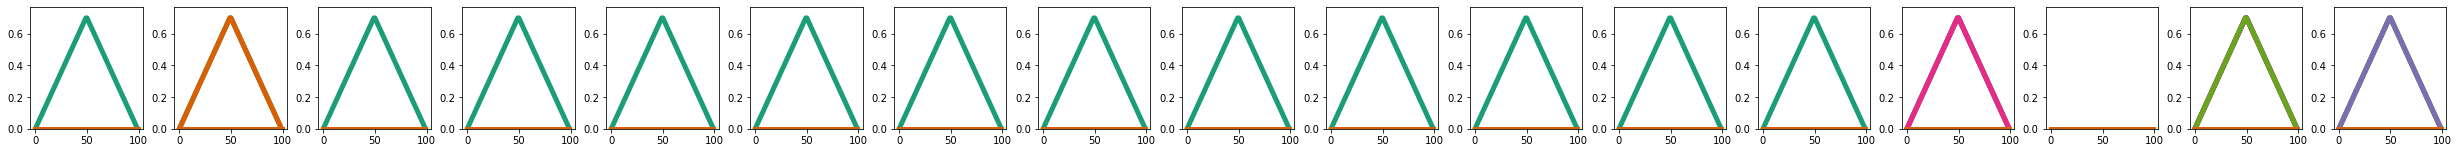

The example image, represented with  1-dim persistence images wrt binary filtration, under transformations (in columns):


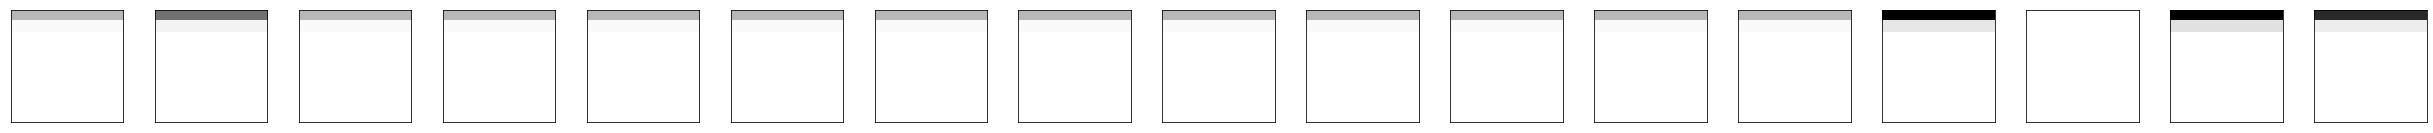

The example image, represented with its grsc filtration function values, under transformations (in columns):


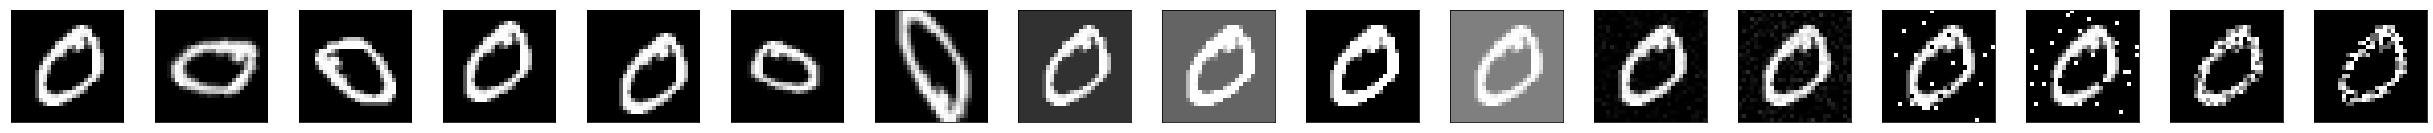

The example image, represented with its 1-dim persistence diagrams wrt grsc filtration, under transformations (in columns):


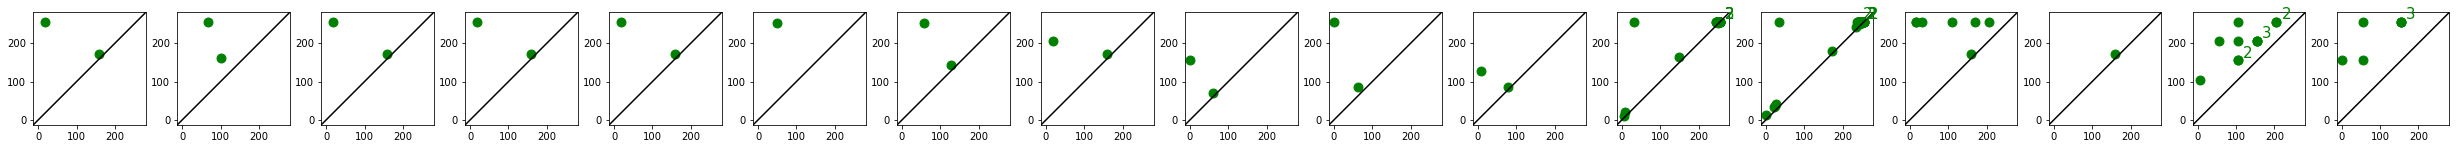

The example image, represented with its 1-dim persistence landscapes wrt grsc filtration, under transformations (in columns):


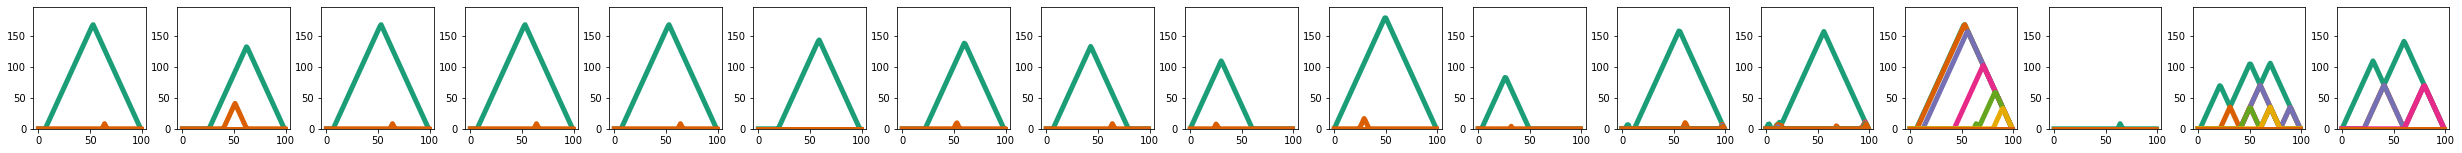

The example image, represented with  1-dim persistence images wrt grsc filtration, under transformations (in columns):


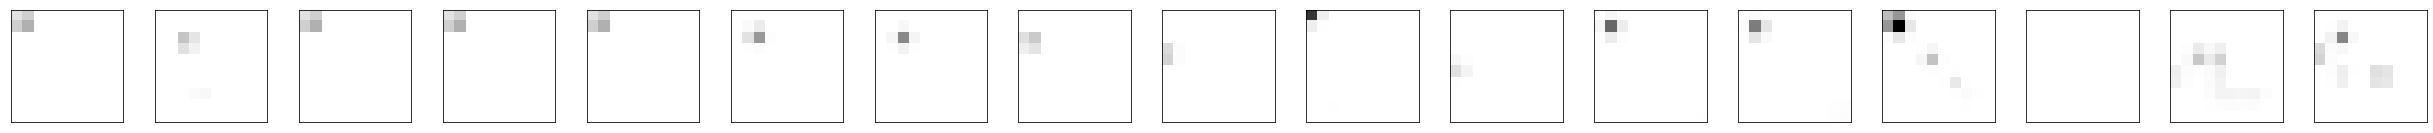

The example image, represented with its density filtration function values, under transformations (in columns):


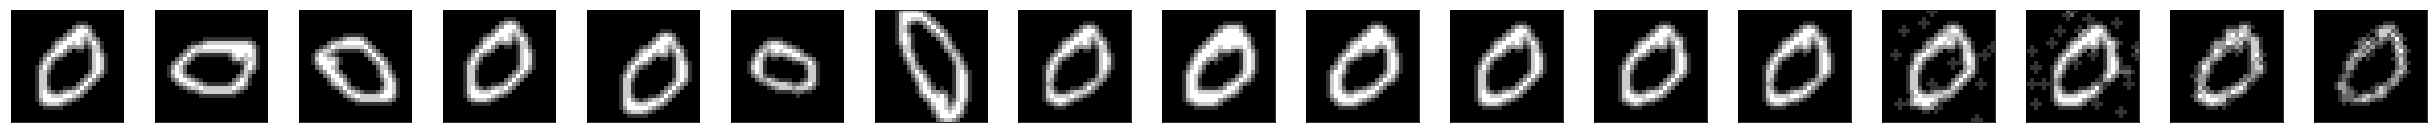

The example image, represented with its 1-dim persistence diagrams wrt density filtration, under transformations (in columns):


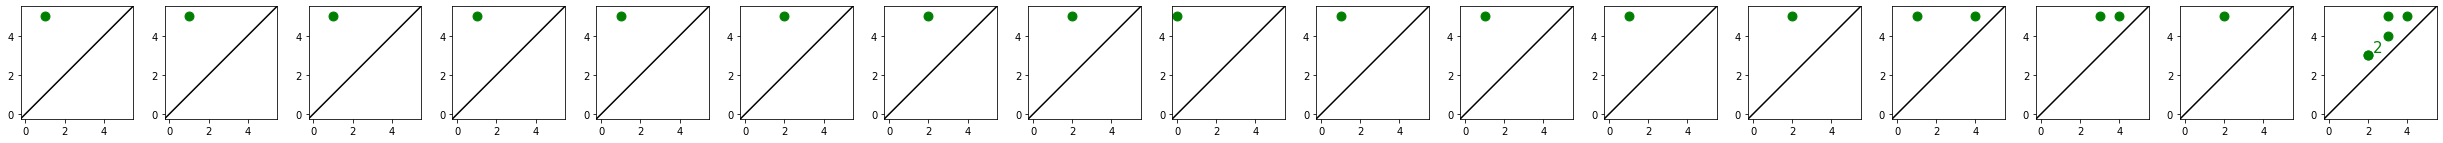

The example image, represented with its 1-dim persistence landscapes wrt density filtration, under transformations (in columns):


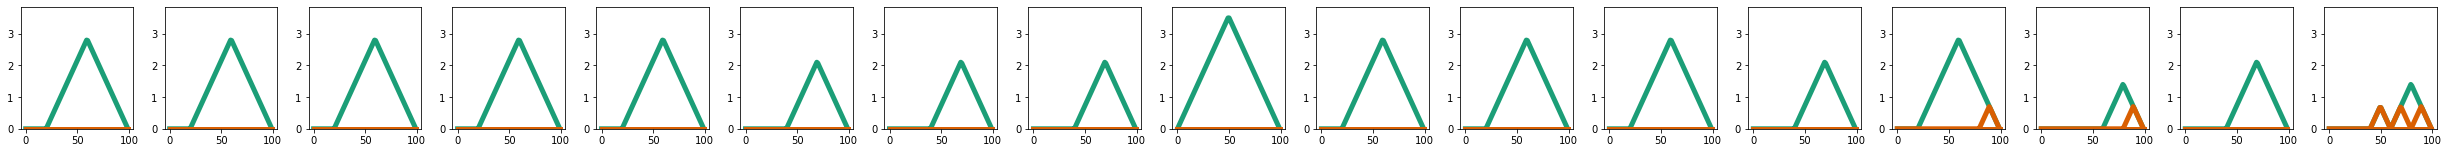

The example image, represented with  1-dim persistence images wrt density filtration, under transformations (in columns):


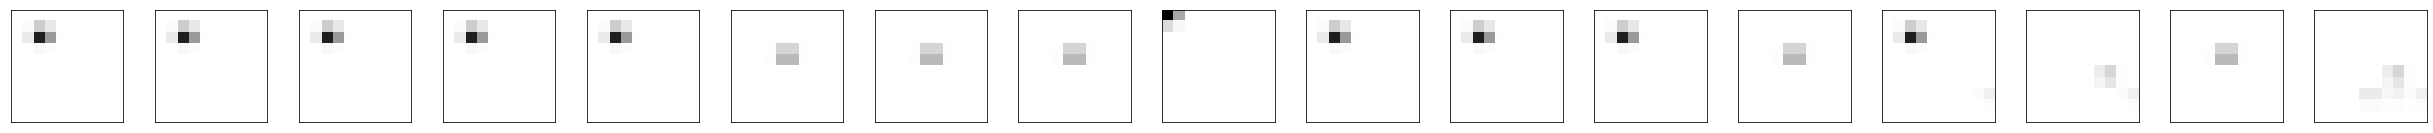

The example image, represented with its radial filtration function values, under transformations (in columns):


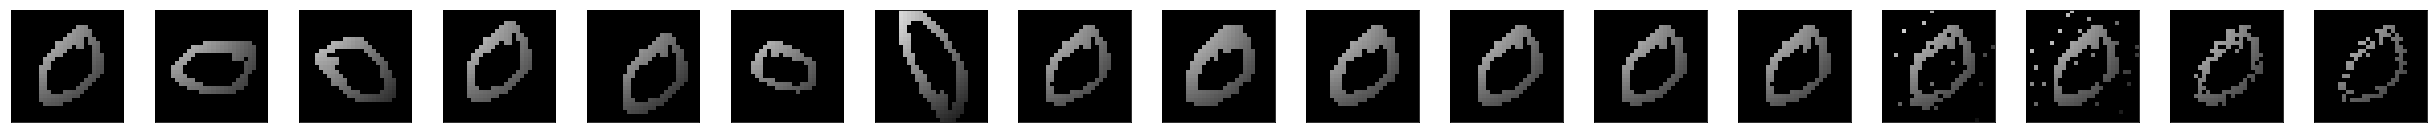

The example image, represented with its 1-dim persistence diagrams wrt radial filtration, under transformations (in columns):


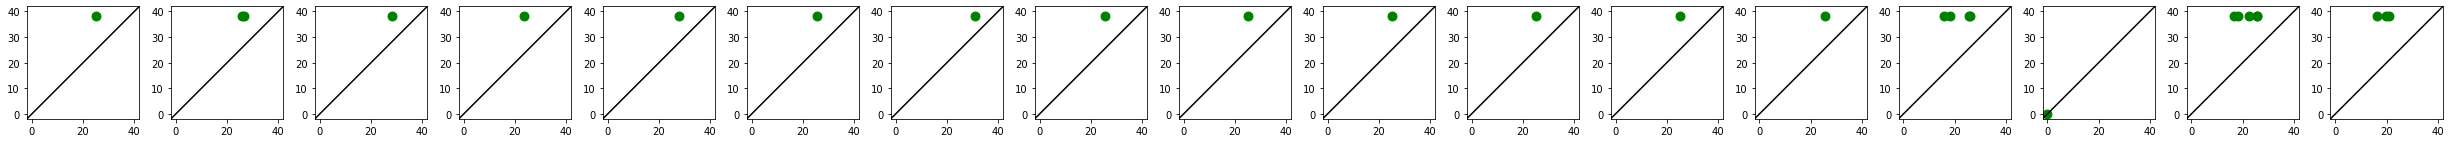

The example image, represented with its 1-dim persistence landscapes wrt radial filtration, under transformations (in columns):


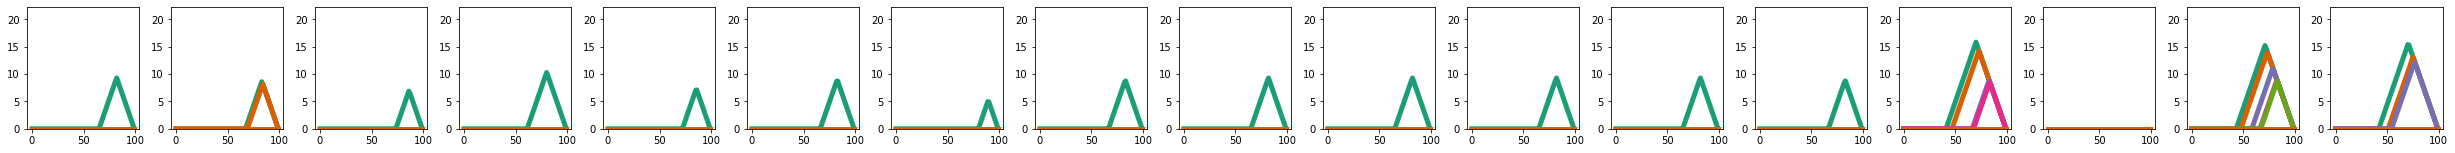

The example image, represented with  1-dim persistence images wrt radial filtration, under transformations (in columns):


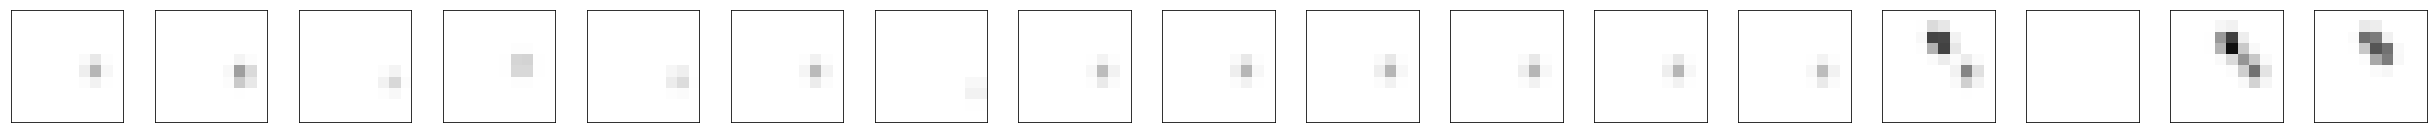

The example image, represented with its Rips filtration function values, under transformations (in columns):


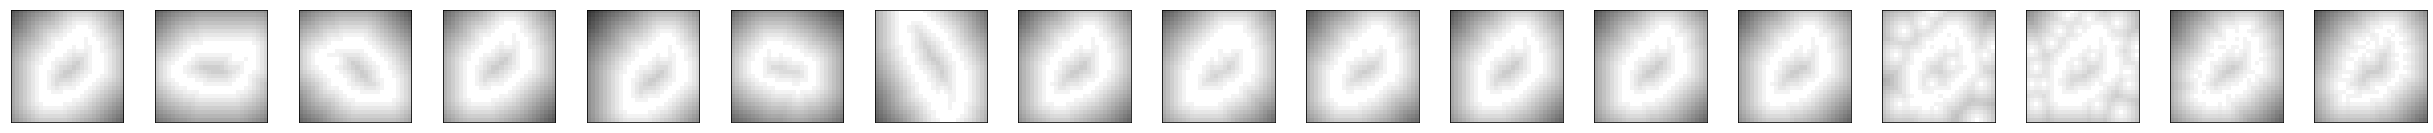

The example image, represented with its 1-dim persistence diagrams wrt Rips filtration, under transformations (in columns):


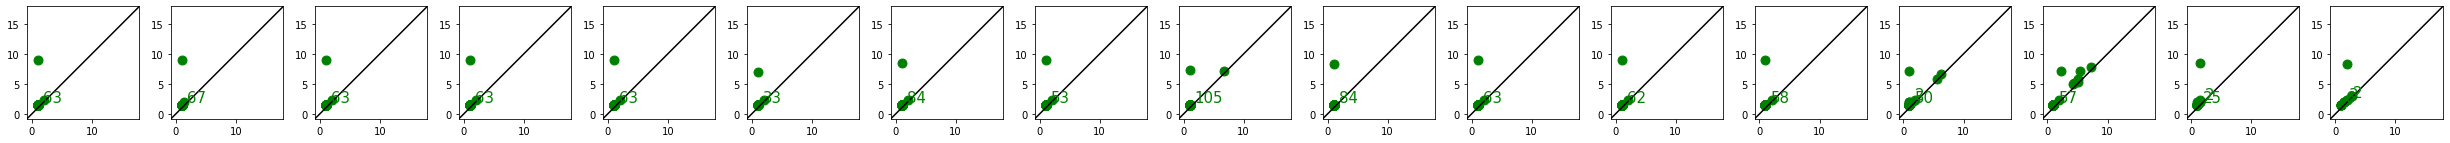

The example image, represented with its 1-dim persistence landscapes wrt Rips filtration, under transformations (in columns):


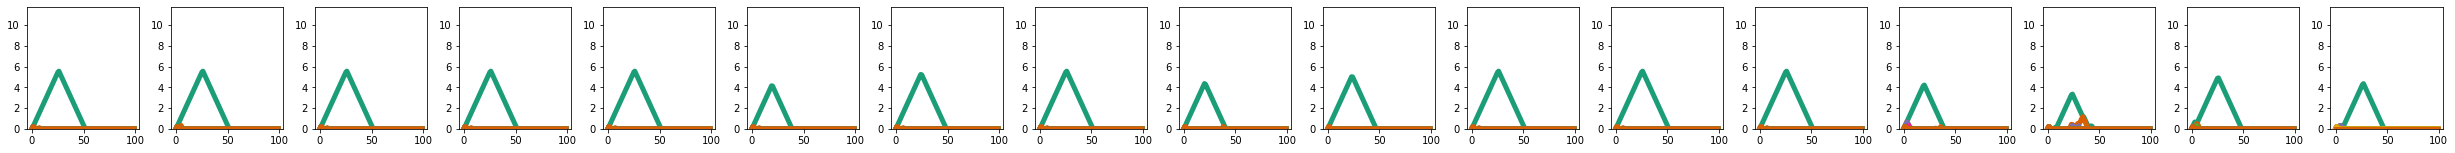

The example image, represented with  1-dim persistence images wrt Rips filtration, under transformations (in columns):


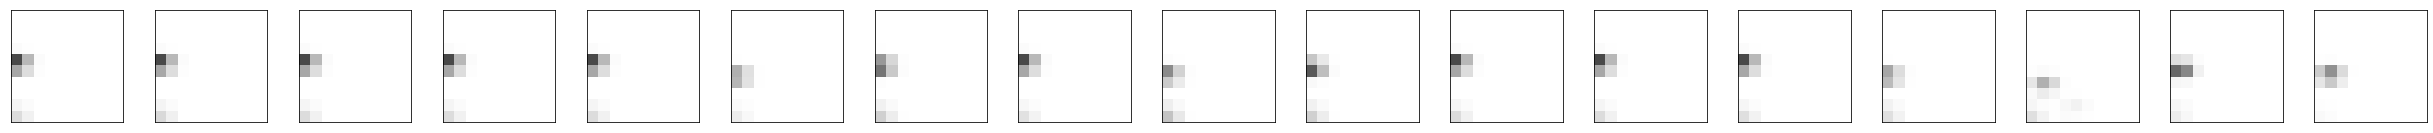

The example image, represented with its DTM filtration function values, under transformations (in columns):


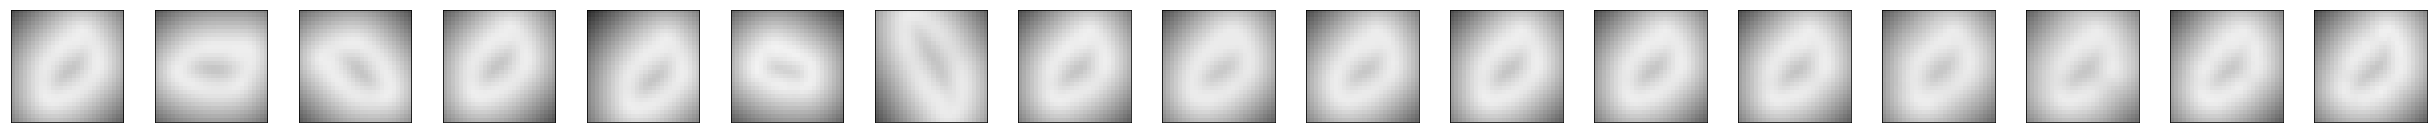

The example image, represented with its 1-dim persistence diagrams wrt DTM filtration, under transformations (in columns):


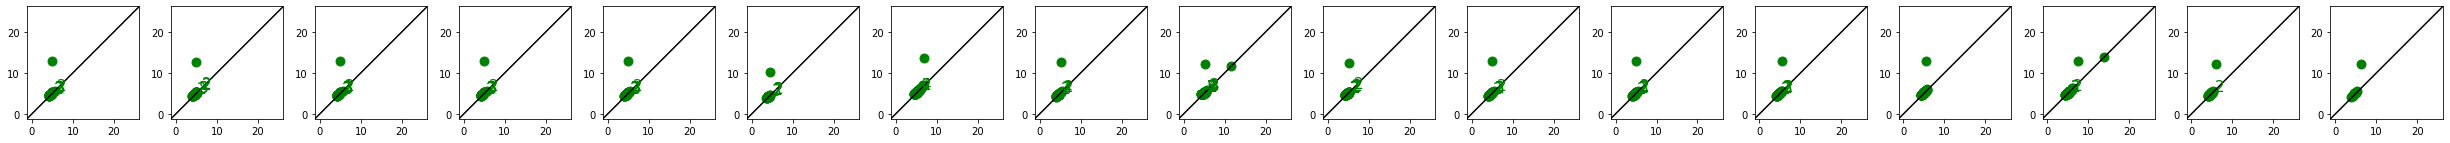

The example image, represented with its 1-dim persistence landscapes wrt DTM filtration, under transformations (in columns):


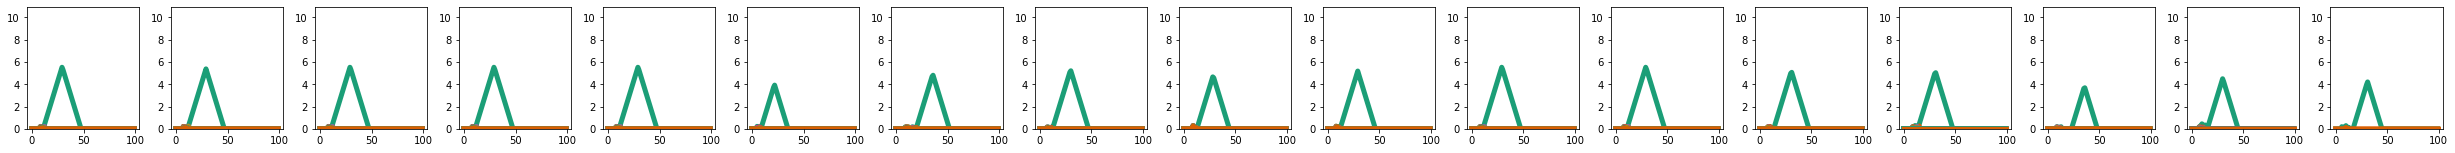

The example image, represented with  1-dim persistence images wrt DTM filtration, under transformations (in columns):


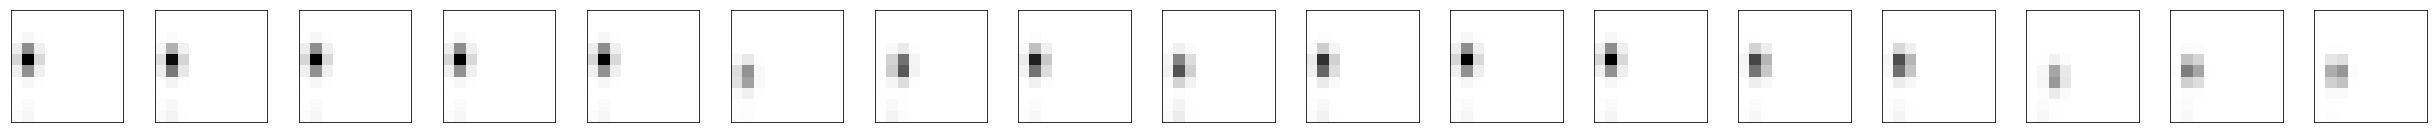

In [37]:
# What does noise do to an image, represented with its filtration function values, 
# and with its persistent homology information?
# (Figure 2 and Figure 3 in turkevs2021noise)

example = 1

# Image.
print("An example image, under transformations (in columns):")
num_fig_rows = 1 
num_fig_cols = len(trnsfs)
subfig_height = 2
subfig_width = 2
fig, axes = plt.subplots(num_fig_rows, num_fig_cols, figsize = (num_fig_cols * subfig_width, num_fig_rows * subfig_height)) 
fig.tight_layout(pad = 0.05)           
for t, trnsf in enumerate(trnsfs):
    image = np.copy(data_trnsf[trnsf][example].reshape((28, 28)))
    plot_image(image, vmin = 0, vmax = max_data, axes = axes[t])    
fig.savefig("FIGURES/noise_robustness_example_image")
plt.show()   

    
for h, homdim in enumerate(homdims):
    for f, filt in enumerate(filts):     

        # Filtration function values.
        print("The example image, represented with its", filt, "filtration function values, under transformations (in columns):")
        num_fig_rows = 1 
        num_fig_cols = len(trnsfs)
        subfig_height = 2
        subfig_width = 2
        fig, axes = plt.subplots(num_fig_rows, num_fig_cols, figsize = (num_fig_cols * subfig_width, num_fig_rows * subfig_height)) 
        fig.tight_layout(pad = 0.05)  
        for t, trnsf in enumerate(trnsfs):
            filt_func_vals = np.copy(data_filt_trnsf[filt, trnsf][example])
            filt_func_vals = filt_func_vals.reshape((num_x_pixels, num_y_pixels))
            plot_image(filt_func_vals, vmin = 0, vmax = max_data_filt[filt], axes = axes[t])  
        fig.savefig("FIGURES/noise_robustness_example_" + filt)
        plt.show() 
        
        # PDs.
        print("The example image, represented with its", homdim, "persistence diagrams wrt", filt, "filtration, under transformations (in columns):")
        num_fig_rows = 1 
        num_fig_cols = len(trnsfs)
        subfig_height = 2
        subfig_width = 2
        fig, axes = plt.subplots(num_fig_rows, num_fig_cols, figsize = (num_fig_cols * subfig_width, num_fig_rows * subfig_height)) 
        fig.tight_layout(pad = 0.05)  
        for t, trnsf in enumerate(trnsfs):   
            PD = np.copy(data_sign_homdim_filt_trnsf["PD", homdim, filt, trnsf][example])            
            plot_PD(PD, xymax = max_death_PDs_homdim_filt[homdim, filt], axes = axes[t])
        fig.savefig("FIGURES/noise_robustness_example_" + filt + "_" + homdim + "_PD")
        plt.show() 
 
        # PLs.
        print("The example image, represented with its", homdim, "persistence landscapes wrt", filt, "filtration, under transformations (in columns):")
        num_fig_rows = 1 
        num_fig_cols = len(trnsfs)
        subfig_height = 2
        subfig_width = 2
        fig, axes = plt.subplots(num_fig_rows, num_fig_cols, figsize = (num_fig_cols * subfig_width, num_fig_rows * subfig_height)) 
        fig.tight_layout(pad = 0.05)  
        for t, trnsf in enumerate(trnsfs):   
            PL = np.copy(data_sign_homdim_filt_trnsf["PL", homdim, filt, trnsf][example])            
            plot_PL(PL, num_lndscs = PL_num, lndsc_resolution = PL_resolution, ymax = max_data_sign_homdim_filt["PL", homdim, filt], axes = axes[t])
        fig.savefig("FIGURES/noise_robustness_example_" + filt + "_" + homdim + "_PL")
        plt.show() 
       
        # PIs.
        print("The example image, represented with ", homdim, "persistence images wrt", filt, "filtration, under transformations (in columns):")
        num_fig_rows = 1 
        num_fig_cols = len(trnsfs)
        subfig_height = 2
        subfig_width = 2
        fig, axes = plt.subplots(num_fig_rows, num_fig_cols, figsize = (num_fig_cols * subfig_width, num_fig_rows * subfig_height)) 
        fig.tight_layout(pad = 0.05)  
        for t, trnsf in enumerate(trnsfs):   
            PI = np.copy(data_sign_homdim_filt_trnsf["PI", homdim, filt, trnsf][example])
            plot_PI(PI, PI_resolution, vmin = 0, vmax = 0.3 * max_data_sign_homdim_filt["PI", homdim, filt], axes = axes[t])            
        fig.savefig("FIGURES/noise_robustness_example_" + filt + "_" + homdim + "_PI")
        plt.show() 

The example image under no noise represented with its greyscale value, filtration function or 1-dim PD, PL, PI: 


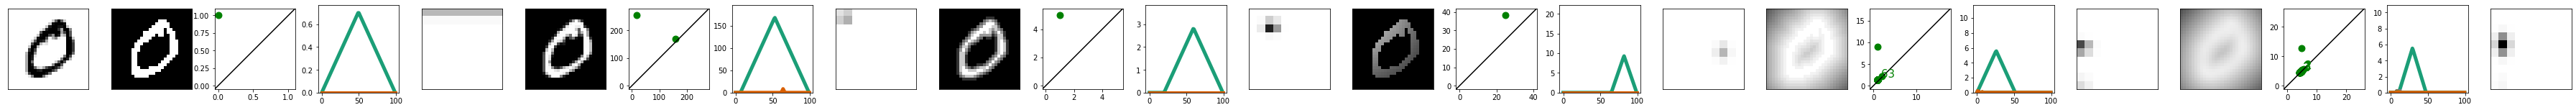

The example image under rotation 45 represented with its greyscale value, filtration function or 1-dim PD, PL, PI: 


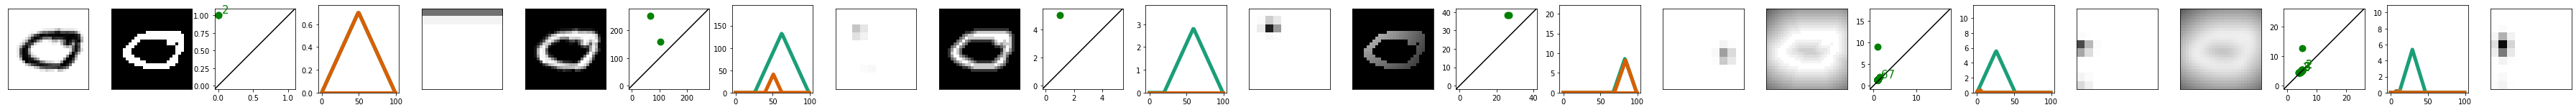

The example image under rotation -90 represented with its greyscale value, filtration function or 1-dim PD, PL, PI: 


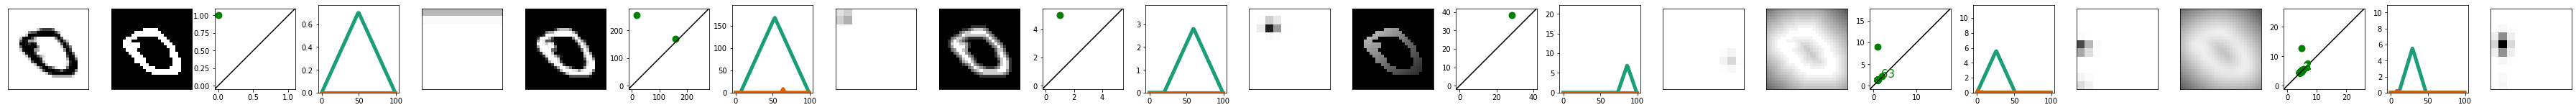

The example image under translation 1 1 represented with its greyscale value, filtration function or 1-dim PD, PL, PI: 


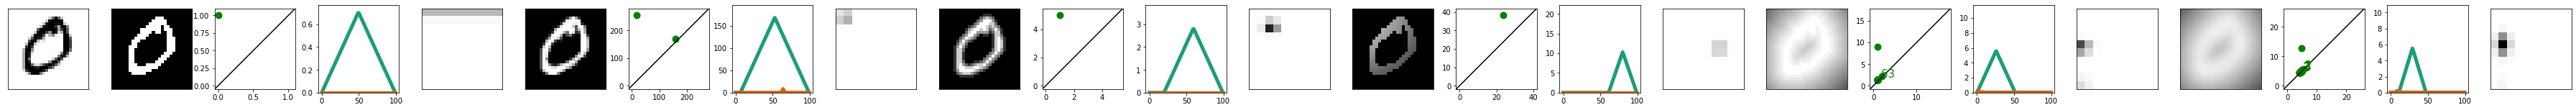

The example image under translation -2 -2 represented with its greyscale value, filtration function or 1-dim PD, PL, PI: 


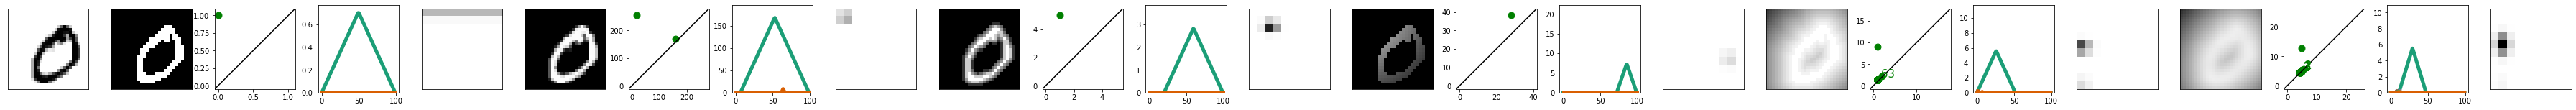

The example image under stretch-shear-flip 1.5 10 h represented with its greyscale value, filtration function or 1-dim PD, PL, PI: 


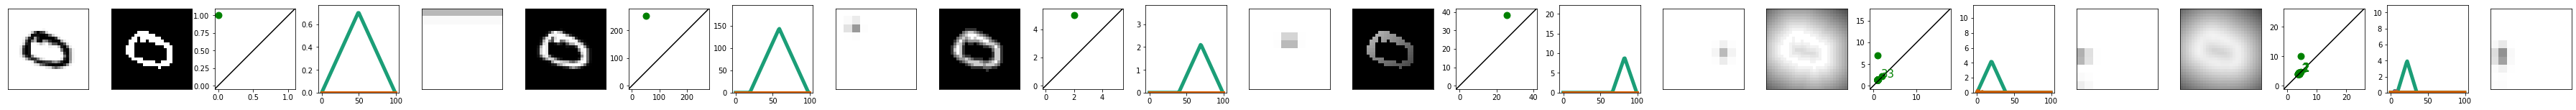

The example image under stretch-shear-flip 0.75 -20 v represented with its greyscale value, filtration function or 1-dim PD, PL, PI: 


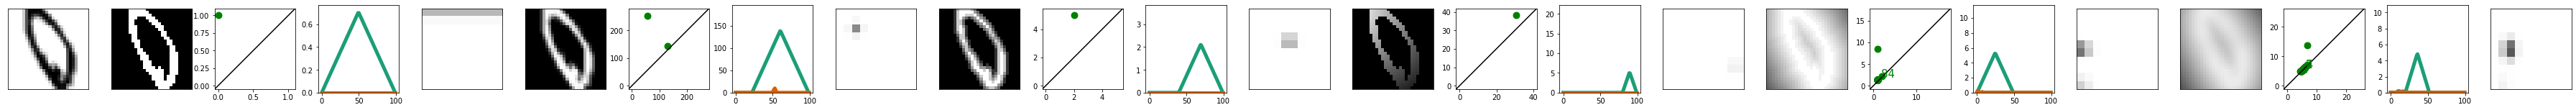

The example image under brightness -50 represented with its greyscale value, filtration function or 1-dim PD, PL, PI: 


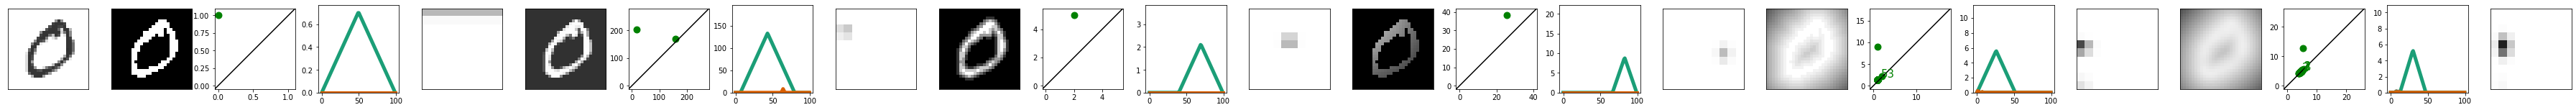

The example image under brightness 100 represented with its greyscale value, filtration function or 1-dim PD, PL, PI: 


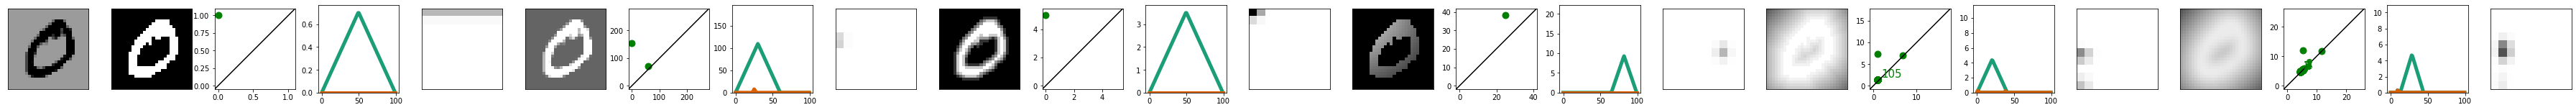

The example image under contrast 2 represented with its greyscale value, filtration function or 1-dim PD, PL, PI: 


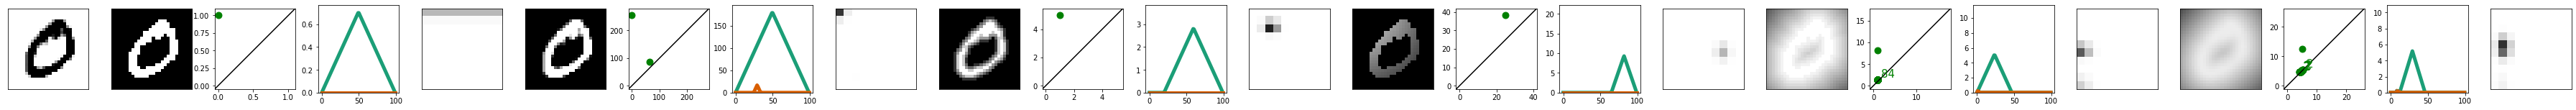

The example image under contrast 0.5 represented with its greyscale value, filtration function or 1-dim PD, PL, PI: 


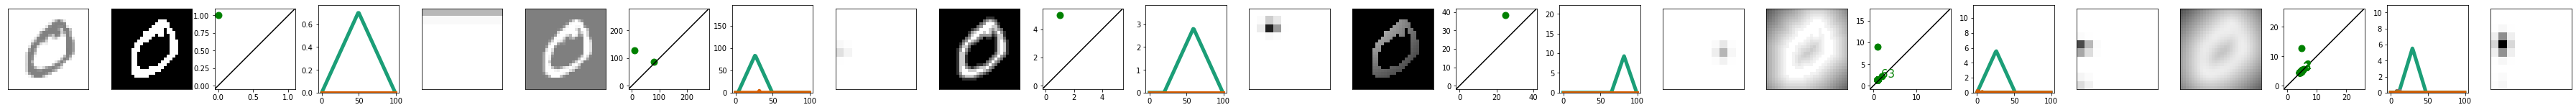

The example image under gaussian noise 10 represented with its greyscale value, filtration function or 1-dim PD, PL, PI: 


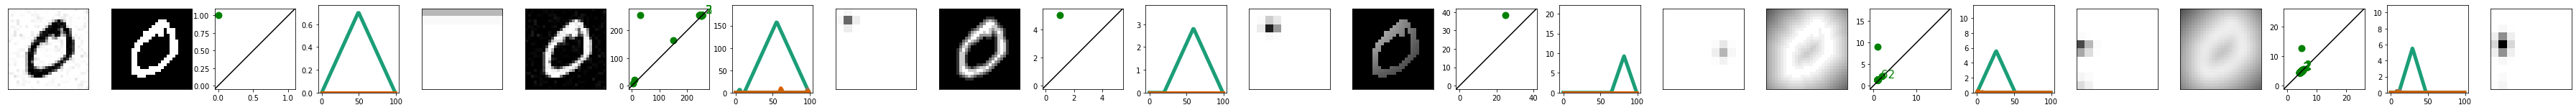

The example image under gaussian noise 20 represented with its greyscale value, filtration function or 1-dim PD, PL, PI: 


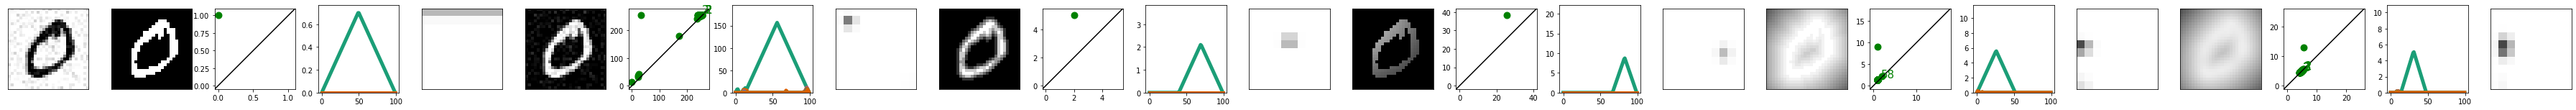

The example image under salt and pepper noise 5 represented with its greyscale value, filtration function or 1-dim PD, PL, PI: 


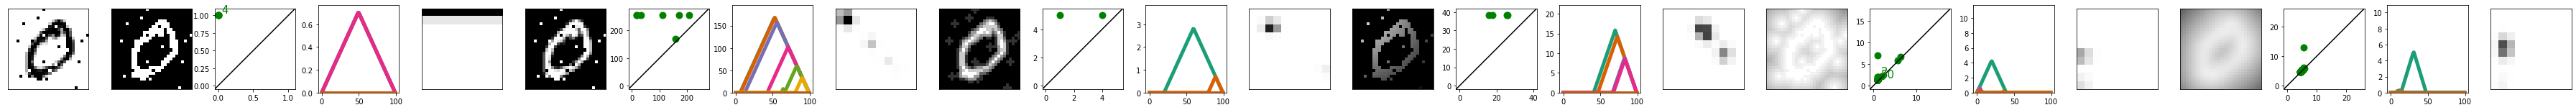

The example image under salt and pepper noise 10 represented with its greyscale value, filtration function or 1-dim PD, PL, PI: 


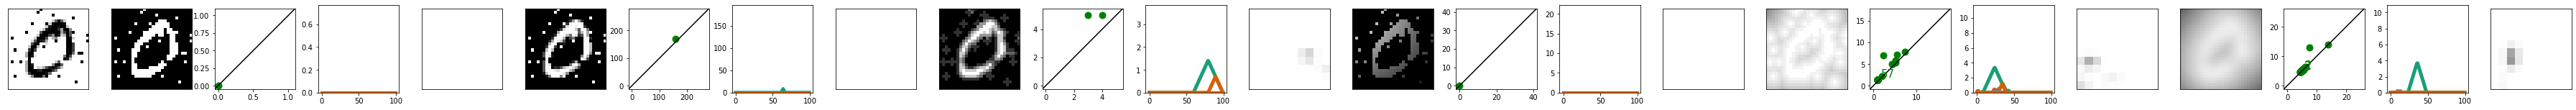

The example image under shot noise 50 represented with its greyscale value, filtration function or 1-dim PD, PL, PI: 


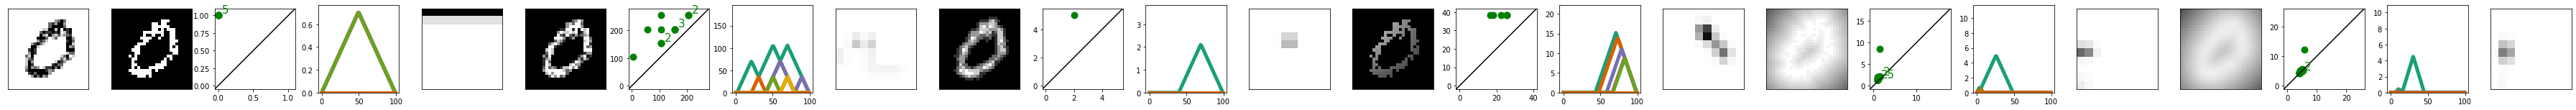

The example image under shot noise 100 represented with its greyscale value, filtration function or 1-dim PD, PL, PI: 


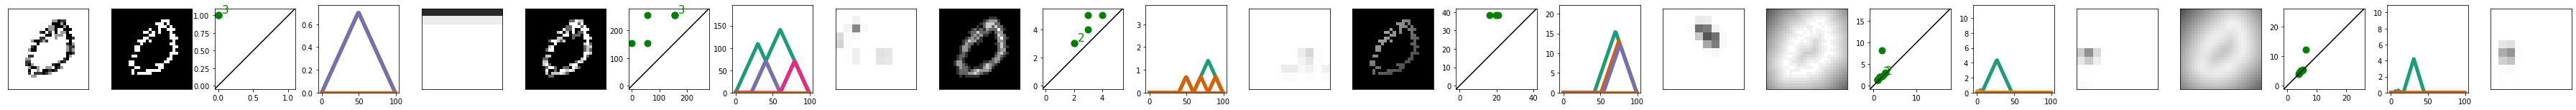

In [38]:
# What does noise do to an image, represented with its filtration function values, 
# and with its persistent homology information?
# (turkevs2021noise poster homdim1 figure)

example = 1

for t, trnsf in enumerate(trnsfs):    
    print("The example image under", trnsf, "represented with its greyscale value, filtration function or 1-dim PD, PL, PI: ")
    num_fig_rows = 1 
    num_fig_cols = 1 + len(filts)*(1 + 1*3)
    subfig_height = 2
    subfig_width = 2
    fig, axes = plt.subplots(num_fig_rows, num_fig_cols, figsize = (num_fig_cols * subfig_width, num_fig_rows * subfig_height)) 
    fig.tight_layout(pad = 0.05)           
    
    # Image.
    image = np.copy(data_trnsf[trnsf][example].reshape((28, 28)))
    plot_image(image, vmin = 0, vmax = max_data, axes = axes[0])    
   
    for f, filt in enumerate(filts): 
        
        # Filtration function.
        filt_func_vals = np.copy(data_filt_trnsf[filt, trnsf][example])
        filt_func_vals = filt_func_vals.reshape((num_x_pixels, num_y_pixels))
        plot_image(filt_func_vals, vmin = 0, vmax = max_data_filt[filt], axes = axes[1 + f*(1 + 1*3)]) 
        
        homdim = "1-dim"
        h = 0
        
        # PD.
        PD = np.copy(data_sign_homdim_filt_trnsf["PD", homdim, filt, trnsf][example])            
        plot_PD(PD, xymax = max_death_PDs_homdim_filt[homdim, filt], axes = axes[1 + f*(1 + 1*3) + 1 + h*3])
     
        # PL.
        PL = np.copy(data_sign_homdim_filt_trnsf["PL", homdim, filt, trnsf][example])            
        plot_PL(PL, num_lndscs = PL_num, lndsc_resolution = PL_resolution, ymax = max_data_sign_homdim_filt["PL", homdim, filt], axes = axes[1 + f*(1 + 1*3) + 1 + h*3 + 1])
            
        # PI. 
        PI = np.copy(data_sign_homdim_filt_trnsf["PI", homdim, filt, trnsf][example])
        plot_PI(PI, PI_resolution, vmin = 0, vmax = 0.3 * max_data_sign_homdim_filt["PI", homdim, filt], axes = axes[1 + f*(1 + 1*3) + 1 + h*3 + 2])            
        
    fig.savefig("FIGURES/noise_robustness_1-dim_PH_example_noise_type_%d" % t)
    plt.show() 

Change in 0-dim PH wrt density filtration, under rotation 45 , for an example image: 

[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 5.]]
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 5.]]


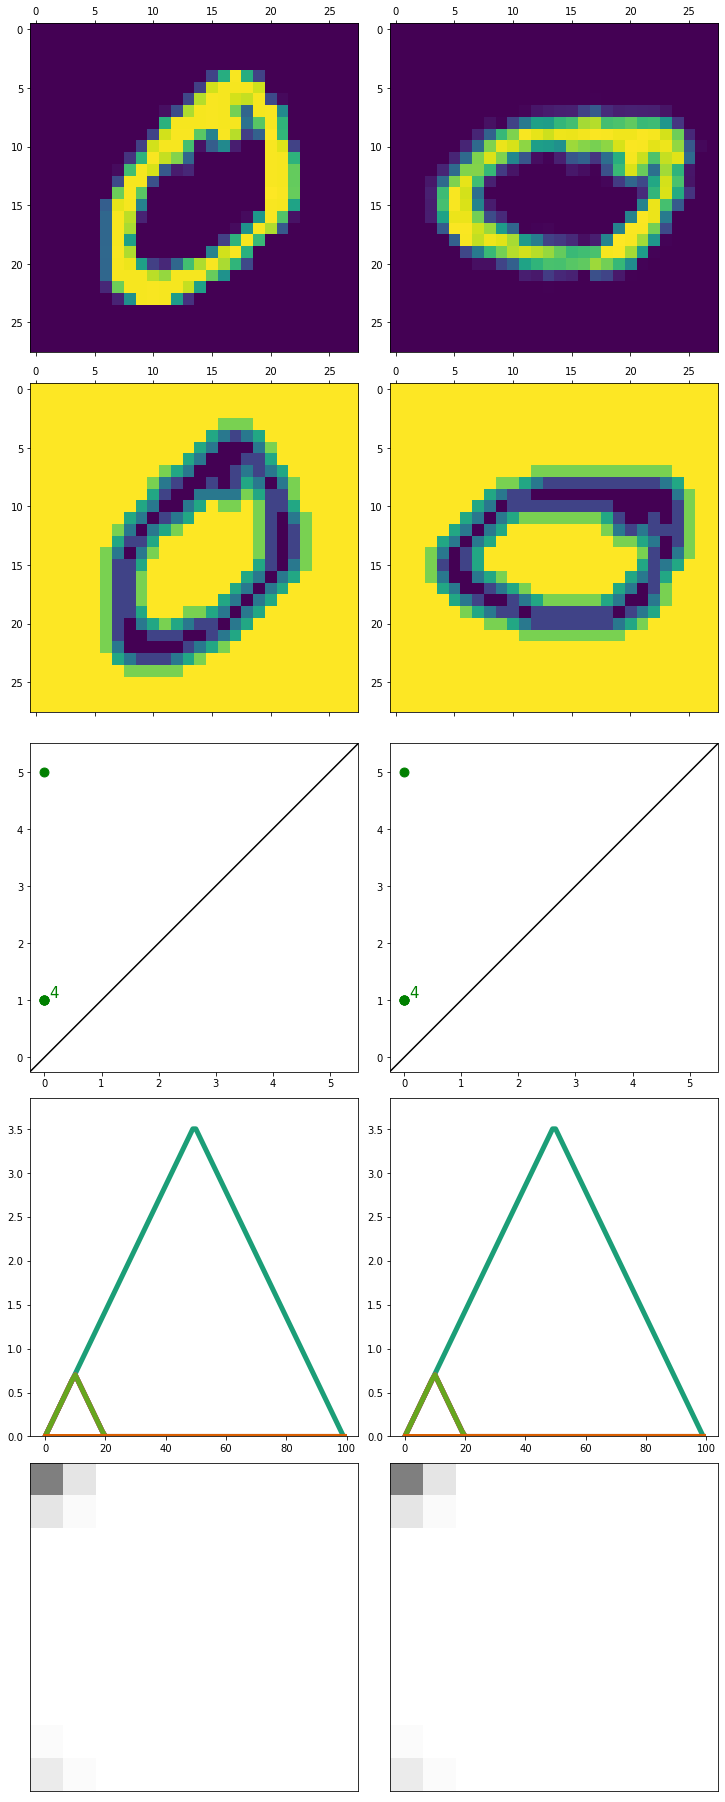

In [39]:
# TODAY

# Auxiliary cell to better understand the change in PH under some transformation, on an example image.
# (same as cell above, but for a given filtration, homological dimension and transformation).
example = 1
filt_temp = "density"
homdim_temp = "0-dim"
trnsf_temp = "rotation 45"

print("Change in", homdim_temp, "PH wrt", filt_temp, "filtration, under", trnsf_temp, ", for an example image: \n")
num_fig_rows = 5
num_fig_cols = 2
subfig_height = 5
subfig_width = 5
fig, axes = plt.subplots(num_fig_rows, num_fig_cols, figsize = (num_fig_cols * subfig_width, num_fig_rows * subfig_height)) 
fig.tight_layout(pad = 0.05) 
axes[0, 0].matshow(data_trnsf["no noise"][example].reshape((num_x_pixels, num_y_pixels)))
axes[0, 1].matshow(data_trnsf[trnsf_temp][example].reshape((num_x_pixels, num_y_pixels)))
axes[1, 0].matshow(data_filt_trnsf[filt_temp, "no noise"][example].reshape((num_x_pixels, num_y_pixels)))
axes[1, 1].matshow(data_filt_trnsf[filt_temp, trnsf_temp][example].reshape((num_x_pixels, num_y_pixels)))
plot_PD(data_sign_homdim_filt_trnsf["PD", homdim_temp, filt_temp, "no noise"][example], 
        xymax = max_death_PDs_homdim_filt[homdim_temp, filt_temp], axes = axes[2, 0])
plot_PD(data_sign_homdim_filt_trnsf["PD", homdim_temp, filt_temp, trnsf_temp][example], 
        xymax = max_death_PDs_homdim_filt[homdim_temp, filt_temp], axes = axes[2, 1])
plot_PL(data_sign_homdim_filt_trnsf["PL", homdim_temp, filt_temp, "no noise"][example], 
        num_lndscs = PL_num, lndsc_resolution = PL_resolution, 
        ymax = max_data_sign_homdim_filt["PL", homdim_temp, filt_temp], axes = axes[3, 0])
plot_PL(data_sign_homdim_filt_trnsf["PL", homdim_temp, filt_temp, trnsf_temp][example], 
        num_lndscs = PL_num, lndsc_resolution = PL_resolution, 
        ymax = max_data_sign_homdim_filt["PL", homdim_temp, filt_temp], axes = axes[3, 1])
plot_PI(data_sign_homdim_filt_trnsf["PI", homdim_temp, filt_temp, "no noise"][example], 
        PI_resolution, vmin = 0, vmax = 1 * max_data_sign_homdim_filt["PI", homdim_temp, filt_temp], axes = axes[4, 0])    
plot_PI(data_sign_homdim_filt_trnsf["PI", homdim_temp, filt_temp, trnsf_temp][example], 
        PI_resolution, vmin = 0, vmax = 1 * max_data_sign_homdim_filt["PI", homdim_temp, filt_temp], axes = axes[4, 1])    

print(data_sign_homdim_filt_trnsf["PD", homdim_temp, filt_temp, "no noise"][example])
print(data_sign_homdim_filt_trnsf["PD", homdim_temp, filt_temp, trnsf_temp][example])

In [40]:
# Calculate the l_p distance between each data point and its transformed data point, 
# when images are represented with their filtration function values.
dists_filt_trnsf_data_data = {}
runtime_dists_filt_trnsf_data_data = {}

# Auxiliary function to enable parallel computing of distances.
def compute_dists_filt_trnsf_data_data(filt, trnsf, data_1, data_2):    
    t0 = time.time()        
    dists = l_p_distances(data_1, data_2, p = 2)
    dists_dict = {}
    dists_dict[filt, trnsf] = dists 
    t1 = time.time()
    runtime = t1 - t0
    runtime_dict = {}
    runtime_dict[filt, trnsf] = runtime
    return dists_dict, runtime_dict

print("Parallel calculation of distances between non-noisy and noisy data points across transformations, when images are represented with their filtration functions ...")
t0 = time.time()
dists_and_runtime_dicts = Parallel(n_jobs = -1)(
    delayed(compute_dists_filt_trnsf_data_data)(filt, trnsf, data_filt_trnsf[filt, "no noise"], data_filt_trnsf[filt, trnsf])
    for filt in filts
    for trnsf in trnsfs)
t1 = time.time()
runtime = t1 - t0
for dists_dict, runtime_dict in dists_and_runtime_dicts:
    dists_filt_trnsf_data_data.update(dists_dict)
    runtime_dists_filt_trnsf_data_data.update(runtime_dict)
with open("VARIABLES/dists_filt_trnsf_data_data.pkl", "wb") as f:
    pickle.dump(dists_filt_trnsf_data_data, f)    
with open("VARIABLES/runtime_dists_trnsf_data_data.pkl", "wb") as f:
    pickle.dump(runtime_dists_filt_trnsf_data_data, f)  
print("Runtime = %.3f s" % runtime)

Parallel calculation of distances between non-noisy and noisy data points across transformations, when images are represented with their filtration functions ...
Runtime = 0.653 s


In [41]:
# Calculate the W_p distance between each data point and its transformed data point, 
# when images are represented with their persistent homology information.
dists_sign_homdim_filt_trnsf_data_data = {}
runtime_dists_sign_homdim_filt_trnsf_data_data = {}

def compute_dists_sign_homdim_filt_trnsf_data_data(sign, homdim, filt, trnsf, data_1, data_2):    
    t0 = time.time()        
    if(sign == "PD"):
        dists = wasserstein_p_q_distances(data_1, data_2, p = 2, q = np.inf)
    else: 
        dists = l_p_distances(data_1, data_2, p = 2)
    dists_dict = {}
    dists_dict[sign, homdim, filt, trnsf] = dists 
    t1 = time.time()
    runtime = t1 - t0
    runtime_dict = {}
    runtime_dict[sign, homdim, filt, trnsf] = runtime
    return dists_dict, runtime_dict

# Auxiliary function to enable parallel computing of distances.
print("Parallel calculation of distances between non-noisy and noisy data points across signs, homdims, filts, trnsfs, when images are represented with persistent homology information...")
t0 = time.time()
dists_and_runtime_dicts = Parallel(n_jobs = -1)(
    delayed(compute_dists_sign_homdim_filt_trnsf_data_data)(sign, homdim, filt, trnsf, 
                                                            data_sign_homdim_filt_trnsf[sign, homdim, filt, "no noise"],
                                                            data_sign_homdim_filt_trnsf[sign, homdim, filt, trnsf])
    for sign in signs
    for homdim in homdims
    for filt in filts
    for trnsf in trnsfs)
t1 = time.time()
runtime = t1 - t0
for dists_dict, runtime_dict in dists_and_runtime_dicts:
    dists_sign_homdim_filt_trnsf_data_data.update(dists_dict)
    runtime_dists_sign_homdim_filt_trnsf_data_data.update(runtime_dict) 
with open("VARIABLES/dists_sign_homdim_filt_trnsf_data_data.pkl", "wb") as f:
    pickle.dump(dists_sign_homdim_filt_trnsf_data_data, f)    
with open("VARIABLES/runtime_dists_sign_homdim_filt_trnsf_data_data.pkl", "wb") as f:
    pickle.dump(runtime_dists_sign_homdim_filt_trnsf_data_data, f)
print("Runtime = %.3f s" % runtime)

Parallel calculation of distances between non-noisy and noisy data points across signs, homdims, filts, trnsfs, when images are represented with persistent homology information...
Runtime = 2.710 s


In [46]:
# How different is the noisy image from the non-noisy image, when images are represented with filtration function values,
# and with persistent homology information?
# (Table 2 in turkevs2021noise)

trnsfs_noisy = ["rotation 45", "rotation -90", "translation 1 1", "translation -2 -2", "stretch-shear-flip 1.5 10 h", "stretch-shear-flip 0.75 -20 v",
                "brightness -50", "brightness 100", "contrast 2", "contrast 0.5",
                "gaussian noise 10", "gaussian noise 20", "salt and pepper noise 5", "salt and pepper noise 10", "shot noise 50", "shot noise 100"]
avg_dist_filt_trnsf_data_data = {}
avg_dist_sign_homdim_filt_trnsf_data_data = {}

# LaTeX table body.
print("The average distance between non-noisy and noisy image, represented with a filtration function, or PH, across transformations (in columns): \n")
for filt in filts:
    print("\\multirow{", 1+num_homdims*num_signs, "}{2cm}{", filt, "} & - & -", end = " ")
    for trnsf in trnsfs_noisy:
        avg_dist_filt_trnsf_data_data[filt, trnsf] = np.mean(dists_filt_trnsf_data_data[filt, trnsf])
        if np.around(avg_dist_filt_trnsf_data_data[filt, trnsf], 2) == 0:
            print("& \\textbf{", np.around(avg_dist_filt_trnsf_data_data[filt, trnsf], 2), "}", end = " ")
        else:
            print("&", np.around(avg_dist_filt_trnsf_data_data[filt, trnsf], 2), end = " ")
    print("\\\\")
    for h, homdim in enumerate(homdims):
        print("\\cline{2-", 1+1+1+len(trnsfs_noisy), "}")
        print("& \\multirow{", num_signs, "}{*}{", h, "}")
        for sign in signs:
            if sign == "PD":
                print("&", sign, end = " ")
            else: 
                print("&& $", sign, "$", end = " ")
            for trnsf in trnsfs_noisy:
                avg_dist_sign_homdim_filt_trnsf_data_data[sign, homdim, filt, trnsf] = np.mean(dists_sign_homdim_filt_trnsf_data_data[sign, homdim, filt, trnsf])
                if np.around(avg_dist_sign_homdim_filt_trnsf_data_data[sign, homdim, filt, trnsf], 2) == 0:
                    print("& \\textbf{", "{:.2f}".format(avg_dist_sign_homdim_filt_trnsf_data_data[sign, homdim, filt, trnsf]), "}", end = " ")
                else:
                    print("&", "{:.2f}".format(avg_dist_sign_homdim_filt_trnsf_data_data[sign, homdim, filt, trnsf]), end = " ")
            print("\\\\")
    print("\n\\midrule \n")       

The average distance between non-noisy and noisy image, represented with a filtration function, or PH, across transformations (in columns): 

\multirow{ 7 }{2cm}{ binary } & - & - & 11.17 & 11.74 & 9.02 & 11.65 & 10.35 & 11.99 & 2.74 & 5.66 & 4.26 & \textbf{ 0.0 } & 1.5 & 2.24 & 4.4 & 6.2 & 4.96 & 6.33 \\
\cline{2- 19 }
& \multirow{ 3 }{*}{ 0 }
& PD & 0.01 & \textbf{ 0.00 } & \textbf{ 0.00 } & \textbf{ 0.00 } & 0.02 & 0.01 & 0.03 & 0.03 & 0.04 & \textbf{ 0.00 } & \textbf{ 0.00 } & 0.01 & 1.80 & 2.44 & 0.21 & 0.64 \\
&& $ PL $ & 0.12 & \textbf{ 0.00 } & \textbf{ 0.00 } & \textbf{ 0.00 } & 0.17 & 0.12 & 0.23 & 0.23 & 0.34 & \textbf{ 0.00 } & \textbf{ 0.00 } & 0.12 & 12.09 & 12.15 & 1.75 & 5.20 \\
&& $ PI $ & 18.19 & \textbf{ 0.00 } & \textbf{ 0.00 } & \textbf{ 0.00 } & 27.28 & 18.19 & 36.38 & 36.38 & 63.66 & \textbf{ 0.00 } & \textbf{ 0.00 } & 18.19 & 8385.19 & 15251.59 & 345.59 & 1446.04 \\
\cline{2- 19 }
& \multirow{ 3 }{*}{ 1 }
& PD & 0.04 & \textbf{ 0.00 } & \textbf{ 0.00 } & \textbf

In [ ]:
# Auxiliary cell to visualize the information in the cell above, together with the variance between the distances across images in the dataset:
# How different is the noisy image from the non-noisy image, when images are represented with filtration function values,
# and with persistent homology information?
# (Table 2 in turkevs2021noise boxplots)

print("The range of distances between non-noisy and noisy image, represented with a filtration function, or PH, across transformations (in columns): \n")
num_fig_rows = num_filts * (1 + num_homdims * num_signs)
num_fig_cols = len(trnsfs_noisy)
subfig_height = 2
subfig_width = 2
fig, axes = plt.subplots(num_fig_rows, num_fig_cols, figsize = (num_fig_cols * subfig_width, num_fig_rows * subfig_height)) 
fig.tight_layout(pad = 5)   
for t, trnsf in enumerate(trnsfs_noisy):
    for f, filt in enumerate(filts):
        axes[f*(1+num_homdims*num_signs), t].boxplot(dists_filt_trnsf_data_data[filt, trnsf])
        axes[f*(1+num_homdims*num_signs), t].set_title(filt + "\n" + trnsf, fontsize = 10)  
        for h, homdim in enumerate(homdims):
            for s, sign in enumerate(signs):
                axes[f*(1+num_homdims*num_signs) + h*num_signs + s + 1, t].boxplot(dists_sign_homdim_filt_trnsf_data_data[sign, homdim, filt, trnsf])
                axes[f*(1+num_homdims*num_signs) + h*num_signs + s + 1, t].set_title(homdim + " " + sign + "\n" + filt + "\n" + trnsf, fontsize = 10) 

## 3) Noise robustness and discriminative power


This section relies on the two dictionaries calculated in section 5.1) data_filt_trnsf and data_sign_homdim_filt_trnsf, to answer the second research question identified in the paper:

> (RQ2) How discriminative is the persistent homology information with respect to different filtrations and persistence signatures, when data does or does not contain noise?

To do so, we evaluate the accuracy of SVM trained on non-noisy and tested on noisy data, when an image is represented with its filtration function, or with its persistent homology:
- $\color{red}{\text{svm_acc_data_filt_trnsf}}$
- $\color{red}{\text{svm_acc_data_sign_homdim_filt_trnsf}}.$

These variables are then used to plot two figures (for 0-dim and 1-dim PH) that show the SVM accuracy. However, to evaluate the noise robustness of persistent homology, we are rather interested in the drop of SVM accuracy when the test data is noisy compared to non-noisy images, and we therefore also provide a table summary of the SVM drop in accuracy.

In [ ]:
# Load the variables.
trnsfs = ["no noise", 
          "rotation 45", "rotation -90", "translation 1 1", "translation -2 -2", "stretch-shear-flip 1.5 10 h", "stretch-shear-flip 0.75 -20 v",
          "brightness -50", "brightness 100", "contrast 2", "contrast 0.5",
          "gaussian noise 10", "gaussian noise 20", "salt and pepper noise 5", "salt and pepper noise 10", "shot noise 50", "shot noise 100"]
filts = ["binary", "grsc", "density", "radial", "Rips", "DTM"]
homdims = ["0-dim", "1-dim"]
signs = ["PD", "PL", "PI"]

with open("VARIABLES/data_trnsf.pkl", "rb") as f:
    data_trnsf = pickle.load(f)
with open("VARIABLES/data_filt_trnsf.pkl", "rb") as f:
    data_filt_trnsf = pickle.load(f)
with open("VARIABLES/data_sign_homdim_filt_trnsf.pkl", "rb") as f:
    data_sign_homdim_filt_trnsf = pickle.load(f)

In [47]:
# Split the data into a training and test (sub)set.
train_size = 0.7
num_train_data_points = int(train_size * num_data_points)

data_filt_trnsf_train = {}
data_filt_trnsf_test = {}
data_sign_homdim_filt_trnsf_train = {}
data_sign_homdim_filt_trnsf_test = {}

permutation = np.random.permutation(num_data_points)
train_indices = permutation[:num_train_data_points]
test_indices = permutation[num_train_data_points:]

for trnsf in trnsfs:          
    for filt in filts:        
        data_filt_trnsf_train[filt, trnsf] = np.array(data_filt_trnsf[filt, trnsf])[train_indices]  
        data_filt_trnsf_test[filt, trnsf] = np.array(data_filt_trnsf[filt, trnsf])[test_indices]               
        for homdim in homdims:                    
            for sign in signs:
                data_sign_homdim_filt_trnsf_train[sign, homdim, filt, trnsf] = np.array(data_sign_homdim_filt_trnsf[sign, homdim, filt, trnsf])[train_indices]  
                data_sign_homdim_filt_trnsf_test[sign, homdim, filt, trnsf] = np.array(data_sign_homdim_filt_trnsf[sign, homdim, filt, trnsf])[test_indices]  
        
labels_train = np.array(labels)[train_indices]
labels_test = np.array(labels)[test_indices]

print("Number of training data points = ", len(labels_train))
print("Number of test data points = ", len(labels_test))

Number of training data points =  49
Number of test data points =  21


<ipython-input-47-3a03268f9ecb>:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  data_sign_homdim_filt_trnsf_train[sign, homdim, filt, trnsf] = np.array(data_sign_homdim_filt_trnsf[sign, homdim, filt, trnsf])[train_indices]
<ipython-input-47-3a03268f9ecb>:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  data_sign_homdim_filt_trnsf_test[sign, homdim, filt, trnsf] = np.array(data_sign_homdim_filt_trnsf[sign, homdim, filt, trnsf])[test_indices]


In [59]:
# Build the SVM pipeline. 
# Persistence diagrams are multi-sets and not vectors, and we thus consider SVM with a "kernel"
# obtained from Wasserstein_p or l_p distances between PDs, PLs or PIs.

class distance_matrix(BaseEstimator, TransformerMixin): 
    def fit(self, X, y=None, **fit_params):
        self.X_train_ = X
        return self    
    def transform(self, X, y = None):        
        num_data_points = len(X)
        num_train_data_points = len(self.X_train_)
        distance_matrix = np.zeros((num_data_points, num_train_data_points))
        if type(X[0][0]) == np.float64: 
            for i in range(num_data_points):
                for j in range(num_train_data_points):
                    distance_matrix[i, j] = np.linalg.norm(X[i] - self.X_train_[j], ord = 2)
        else: # Element of a PD is not a number, but a persistence interval (1x2 numpy array, birth and death value).
            for i in range(num_data_points):
                for j in range(num_train_data_points):
                    distance_matrix[i, j] = gudhi.wasserstein.wasserstein_distance(X[i], self.X_train_[j], 
                                                                                   order = 2, internal_p = np.inf) 
        return distance_matrix
    
class kernel_rbf(BaseEstimator, TransformerMixin):     
    def __init__(self, gamma = 1.00):
        self.gamma = gamma       
    def fit(self, X, y=None, **fit_params):
        return self
    def transform(self, X, y = None):  
        return np.exp(-self.gamma * X**2) 
    

# Pipeline with SVM custom kernel, and SVM, in order to enable to simultaneously tune the kernel and SVM parameters.
pipeline = Pipeline(
    steps = [
        ('distance_matrix', distance_matrix()),
        ('kernel_rbf', kernel_rbf()),
        ('svm', SVC())
        ])

  
# !!! Choice of SVM parameter values.
gamma_range = np.logspace(-7, -2, 5) # np.logspace(-9, 4, 14) 
C_range = np.logspace(-1, 2, 4) # np.logspace(-2, 10, 13) #   
parameters_grid = dict([
    ('kernel_rbf__gamma', gamma_range),
    ('svm__kernel', ['precomputed']),
    ('svm__C', C_range)
]) 
print("SVM parameters: ")
print("gamma_range = ", gamma_range)
print("C_range = ", C_range)

SVM parameters: 
gamma_range =  [1.00000000e-07 1.77827941e-06 3.16227766e-05 5.62341325e-04
 1.00000000e-02]
C_range =  [  0.1   1.   10.  100. ]


In [61]:
# Compute the accuracy of SVM trained on non-noisy images, and tested on non-noisy and noisy images,
# when an image is represented with its filtration function values.
svm_classifier_data_filt = {} # stored so that confusion matrices can directly be plotted later
runtime_svm_tune_parameters_data_filt = {}
# We also store the SVM coefficients to see what is learned for each class, 
# when images are represented with their filtration functions.
# The SVM coefficients are learned from the training data, which is always non-noisy in our experimental set-up 
# (whereas the test data can be subject to noise), so that the following variable does not depend on the transformation of data.
# svm_coeffs_data_filt = {}
svm_acc_data_filt_trnsf = {}


# Auxiliary function to enable parallel tuning of SVM parameters, across filtrations.
def SVM_tune_parameters_and_fit_best(filt, data_train, labels_train): 
    print("Tuning SVM hyper-parameters C and gamma with GridSearchCV() on non-noisy data, ")
    print("when images are represented with their " + filt + " filtration function:")
    t0 = time.time()   
    grid_search = GridSearchCV(pipeline, parameters_grid, n_jobs = -1)      
    grid_search = grid_search.fit(data_train, labels_train)     
    t1 = time.time()
    print("Runtime for this step =", t1-t0)  
    print("Best parameters:", grid_search.best_params_)
    cv_accuracies = grid_search.cv_results_['mean_test_score']
    print("Number of parameter combinations = ", len(cv_accuracies))
    print("cv_accuracies = ", np.around(cv_accuracies, 2))
    print("Best accuracy = ", np.max(cv_accuracies))
    print()
    svm_classifier_dict = {}
    svm_classifier_dict[filt] = clone(grid_search.best_estimator_) 
    svm_classifier_dict[filt] = svm_classifier_dict[filt].fit(data_train, labels_train)
    # svm_coeffs_data_filt[filt] = svm_classifier_data_filt[filt].coef_
    runtime_svm_tune_parameters_dict = {}
    runtime_svm_tune_parameters_dict[filt] = t1-t0   
    return svm_classifier_dict, runtime_svm_tune_parameters_dict

print("Parallel tuning of SVM parameters when images are represented with their filtration function values, across filtrations ... \n")
t0 = time.time()
svm_classifier_runtime_dicts = Parallel(n_jobs = 1)(
    delayed(SVM_tune_parameters_and_fit_best)(filt, data_filt_trnsf_train[filt, "no noise"], labels_train)
            for filt in filts)
for svm_classifier_dict, runtime_svm_tune_parameters_dict in svm_classifier_runtime_dicts:
    svm_classifier_data_filt.update(svm_classifier_dict)
    runtime_svm_tune_parameters_data_filt.update(runtime_svm_tune_parameters_dict)
with open("VARIABLES/svm_classifier_data_filt.pkl", "wb") as f:
    pickle.dump(svm_classifier_data_filt, f)    
with open("VARIABLES/runtime_svm_tune_parameters_data_filt.pkl", "wb") as f:
    pickle.dump(runtime_svm_tune_parameters_data_filt, f)    
# with open("VARIABLES/svm_coeffs_data_filt.pkl", "wb") as f:
#     pickle.dump(svm_coeffs_data_filt, f)   


# Auxiliary function to enable parallel calculation of SVM accuracies, across filtrations.
def compute_accuracy(estimator, filt, trnsf, data_test, labels_test):          
    svm_acc_dict = {}
    svm_acc_dict[filt, trnsf] = estimator.score(data_test, labels_test) 
    # labels_predicted = svm_classifier_dict[filt].predict(data_test)
    # print("labels_predicted = ", labels_predicted)
    # print("labels_test =      ", labels_test, "\n")    
    return svm_acc_dict

print("Parallel testing of SVM with the best parameters on the non-noisy and noisy test data, across filtrations and transformations... \n")
svm_acc_dicts = Parallel(n_jobs = -1)(
    delayed(compute_accuracy)(svm_classifier_data_filt[filt], filt, trnsf, data_filt_trnsf_test[filt, trnsf], labels_test)
    for filt in filts
    for trnsf in trnsfs)
for svm_acc_dict in svm_acc_dicts:
    svm_acc_data_filt_trnsf.update(svm_acc_dict)  
with open("VARIABLES/svm_acc_data_filt_trnsf.pkl", "wb") as f:
    pickle.dump(svm_acc_data_filt_trnsf, f)
t1 = time.time()
runtime = t1 - t0
print("Total runtime = %.3f s" % runtime)

# Rather than considering both Parallel(n_jobs = -1) and GridSearchCV(n_jobs = -1), it might be better 
# to consider Parallel(n_jobs = 1) and GridSearchCV(n_jobs = -1), e.g., for some subset of the MNIST dataset:
# Parallel(n_jobs = -1) and GridSearchCV(n_jobs = -1), computation time of this cell = 668
# Parallel(n_jobs = 1) and GridSearchCV(n_jobs = -1), computation time of this cell = 165 seconds

Parallel tuning of SVM parameters when images are represented with their filtration function values, across filtrations ... 

Tuning SVM hyper-parameters C and gamma with GridSearchCV() on non-noisy data, 
when images are represented with their binary filtration function:


/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


Runtime for this step = 0.6879398822784424
Best parameters: {'kernel_rbf__gamma': 0.0005623413251903491, 'svm__C': 100.0, 'svm__kernel': 'precomputed'}
Number of parameter combinations =  20
cv_accuracies =  [0.21 0.21 0.21 0.21 0.21 0.21 0.21 0.21 0.21 0.21 0.21 0.33 0.21 0.21
 0.45 0.59 0.19 0.43 0.57 0.57]
Best accuracy =  0.5933333333333333

Tuning SVM hyper-parameters C and gamma with GridSearchCV() on non-noisy data, 
when images are represented with their grsc filtration function:


/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


Runtime for this step = 0.6787519454956055
Best parameters: {'kernel_rbf__gamma': 1e-07, 'svm__C': 10.0, 'svm__kernel': 'precomputed'}
Number of parameter combinations =  20
cv_accuracies =  [0.21 0.35 0.57 0.57 0.19 0.19 0.23 0.23 0.19 0.17 0.17 0.17 0.16 0.16
 0.16 0.16 0.16 0.16 0.16 0.16]
Best accuracy =  0.5733333333333334

Tuning SVM hyper-parameters C and gamma with GridSearchCV() on non-noisy data, 
when images are represented with their density filtration function:


/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


Runtime for this step = 0.6887404918670654
Best parameters: {'kernel_rbf__gamma': 3.1622776601683795e-05, 'svm__C': 100.0, 'svm__kernel': 'precomputed'}
Number of parameter combinations =  20
cv_accuracies =  [0.21 0.21 0.21 0.21 0.21 0.21 0.21 0.35 0.21 0.21 0.45 0.63 0.21 0.49
 0.61 0.61 0.17 0.19 0.19 0.19]
Best accuracy =  0.6333333333333333

Tuning SVM hyper-parameters C and gamma with GridSearchCV() on non-noisy data, 
when images are represented with their radial filtration function:


/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


Runtime for this step = 0.6939685344696045
Best parameters: {'kernel_rbf__gamma': 1.778279410038923e-06, 'svm__C': 100.0, 'svm__kernel': 'precomputed'}
Number of parameter combinations =  20
cv_accuracies =  [0.19 0.19 0.19 0.31 0.19 0.19 0.43 0.61 0.19 0.43 0.55 0.55 0.17 0.17
 0.17 0.17 0.19 0.19 0.19 0.19]
Best accuracy =  0.6133333333333334

Tuning SVM hyper-parameters C and gamma with GridSearchCV() on non-noisy data, 
when images are represented with their Rips filtration function:


/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


Runtime for this step = 0.685725212097168
Best parameters: {'kernel_rbf__gamma': 0.0005623413251903491, 'svm__C': 1.0, 'svm__kernel': 'precomputed'}
Number of parameter combinations =  20
cv_accuracies =  [0.21 0.21 0.21 0.21 0.21 0.21 0.21 0.45 0.21 0.21 0.47 0.57 0.19 0.58
 0.56 0.56 0.14 0.14 0.14 0.14]
Best accuracy =  0.5755555555555556

Tuning SVM hyper-parameters C and gamma with GridSearchCV() on non-noisy data, 
when images are represented with their DTM filtration function:


/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


Runtime for this step = 0.6748800277709961
Best parameters: {'kernel_rbf__gamma': 0.0005623413251903491, 'svm__C': 10.0, 'svm__kernel': 'precomputed'}
Number of parameter combinations =  20
cv_accuracies =  [0.21 0.21 0.21 0.21 0.21 0.21 0.21 0.47 0.21 0.21 0.45 0.53 0.19 0.52
 0.58 0.58 0.14 0.14 0.14 0.14]
Best accuracy =  0.5755555555555555

Total runtime = 4.297 s
Parallel testing of SVM with the best parameters on the non-noisy and noisy test data, across filtrations and transformations... 

Total runtime = 0.467 s


In [62]:
# Compute the accuracy of SVM trained on non-noisy images, and tested on noisy images,
# when an image is represented with its persistent homology information.
svm_classifier_data_sign_homdim_filt = {} # stored so that conf matrices can be plotted later
runtime_svm_tune_parameters_data_sign_homdim_filt = {}
# The SVM coefficients are learned from the training data, which is always non-noisy in our 
# experimental set-up (whereas the test data can be subject to noise), so that the following variable does not 
# depend on the transformation of data.
svm_coeffs_data_sign_homdim_filt = {}
svm_acc_data_sign_homdim_filt_trnsf = {}


# Auxiliary function to enable parallel tuning of SVM parameters, 
# across persistence signatures, homological dimensions and filtrations.
def SVM_tune_parameters_and_fit_best(sign, homdim, filt, data_train, labels_train):
    print("Tuning SVM hyper-parameters C and gamma with GridSearchCV() on non-noisy data, ")
    print("when images are represented with their " + homdim + " " + sign + " wrt " + filt + " filtration:")
    t0 = time.time()     
    grid_search = GridSearchCV(pipeline, parameters_grid, n_jobs = -1)      
    grid_search = grid_search.fit(data_train, labels_train)       
    t1 = time.time()
    print("Runtime for this step =", t1-t0)
    print("Best parameters:", grid_search.best_params_)
    cv_accuracies = grid_search.cv_results_['mean_test_score']
    print("Number of parameter combinations = ", len(cv_accuracies))
    print("cv_accuracies = ", np.around(cv_accuracies, 2))
    print("Best accuracy = ", np.max(cv_accuracies))    
    print()
    svm_classifier_dict = {}
    svm_classifier_dict[sign, homdim, filt] = clone(grid_search.best_estimator_) 
    svm_classifier_dict[sign, homdim, filt] = svm_classifier_dict[sign, homdim, filt].fit(data_train, labels_train) 
    # svm_coeffs_data_sign_homdim_filt[sign, homdim, filt] = svm_classifier_data_sign_homdim_filt[sign, homdim, filt].coef_
    runtime_svm_tune_parameters_dict = {}
    runtime_svm_tune_parameters_dict[sign, homdim, filt] = t1-t0    
    return svm_classifier_dict, runtime_svm_tune_parameters_dict

print("Parallel tuning of SVM parameters when images are represented with their persistent homology information, across persistence signatures, homological dimensions and filtrations... \n")
t0 = time.time()
svm_classifier_runtime_dicts = Parallel(n_jobs = 1)(
    delayed(SVM_tune_parameters_and_fit_best)(sign, homdim, filt, data_sign_homdim_filt_trnsf_train[sign, homdim, filt, "no noise"], labels_train)
    for sign in signs
    for homdim in homdims
    for filt in filts)
for svm_classifier_dict, runtime_svm_tune_parameters_dict in svm_classifier_runtime_dicts:
    svm_classifier_data_sign_homdim_filt.update(svm_classifier_dict)
    runtime_svm_tune_parameters_data_sign_homdim_filt.update(runtime_svm_tune_parameters_dict) 
with open("VARIABLES/svm_classifier_data_sign_homdim_filt.pkl", "wb") as f:
    pickle.dump(svm_classifier_data_sign_homdim_filt, f)    
with open("VARIABLES/runtime_svm_tune_parameters_data_sign_homdim_filt.pkl", "wb") as f:
    pickle.dump(runtime_svm_tune_parameters_data_sign_homdim_filt, f)    
# with open("VARIABLES/svm_coeffs_data_sign_homdim_filt.pkl", "wb") as f:
#     pickle.dump(svm_coeffs_data_sign_homdim_filt, f)    


# Auxiliary function to enable parallel calculation of SVM accuracies, 
# across persistence signatures, homological dimensions and filtrations.
def compute_accuracy(estimator, sign, homdim, filt, trnsf, data_test, labels_test):        
    svm_acc_dict = {}
    svm_acc_dict[sign, homdim, filt, trnsf] = estimator.score(data_test, labels_test)   
    return svm_acc_dict    

print("Parallel testing of SVM with the best parameters on the non-noisy and noisy test data, across persistence signatures, homological dimensions and filtrations... \n")
svm_acc_dicts = Parallel(n_jobs = -1)(
    delayed(compute_accuracy)(svm_classifier_data_sign_homdim_filt[sign, homdim, filt], sign, homdim, filt, trnsf,
                              data_sign_homdim_filt_trnsf_test[sign, homdim, filt, trnsf], labels_test)
    for sign in signs
    for homdim in homdims
    for filt in filts
    for trnsf in trnsfs)
for svm_acc_dict in svm_acc_dicts:
    svm_acc_data_sign_homdim_filt_trnsf.update(svm_acc_dict)
with open("VARIABLES/svm_acc_data_sign_homdim_filt_trnsf.pkl", "wb") as f:
    pickle.dump(svm_acc_data_sign_homdim_filt_trnsf, f)
    
t1 = time.time()
runtime = t1 - t0
print("Total runtime = %.3f s" % runtime)

Parallel tuning of SVM parameters when images are represented with their persistent homology information, across persistence signatures, homological dimensions and filtrations... 

Tuning SVM hyper-parameters C and gamma with GridSearchCV() on non-noisy data, 
when images are represented with their 0-dim PD wrt binary filtration:


/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


Runtime for this step = 5.570041179656982
Best parameters: {'kernel_rbf__gamma': 1e-07, 'svm__C': 1.0, 'svm__kernel': 'precomputed'}
Number of parameter combinations =  20
cv_accuracies =  [0.1  0.16 0.16 0.16 0.1  0.16 0.16 0.16 0.1  0.16 0.16 0.16 0.1  0.16
 0.16 0.16 0.1  0.16 0.16 0.16]
Best accuracy =  0.16444444444444445

Tuning SVM hyper-parameters C and gamma with GridSearchCV() on non-noisy data, 
when images are represented with their 0-dim PD wrt grsc filtration:


/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


Runtime for this step = 6.197036027908325
Best parameters: {'kernel_rbf__gamma': 3.1622776601683795e-05, 'svm__C': 10.0, 'svm__kernel': 'precomputed'}
Number of parameter combinations =  20
cv_accuracies =  [0.19 0.19 0.19 0.19 0.19 0.19 0.19 0.19 0.19 0.19 0.21 0.14 0.19 0.21
 0.1  0.12 0.06 0.06 0.12 0.12]
Best accuracy =  0.2066666666666667

Tuning SVM hyper-parameters C and gamma with GridSearchCV() on non-noisy data, 
when images are represented with their 0-dim PD wrt density filtration:


/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


Runtime for this step = 5.9668426513671875
Best parameters: {'kernel_rbf__gamma': 0.01, 'svm__C': 100.0, 'svm__kernel': 'precomputed'}
Number of parameter combinations =  20
cv_accuracies =  [0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15
 0.15 0.15 0.15 0.15 0.15 0.24]
Best accuracy =  0.24444444444444446

Tuning SVM hyper-parameters C and gamma with GridSearchCV() on non-noisy data, 
when images are represented with their 0-dim PD wrt radial filtration:


/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


Runtime for this step = 6.023876905441284
Best parameters: {'kernel_rbf__gamma': 0.0005623413251903491, 'svm__C': 100.0, 'svm__kernel': 'precomputed'}
Number of parameter combinations =  20
cv_accuracies =  [0.21 0.21 0.21 0.21 0.21 0.21 0.21 0.21 0.21 0.21 0.21 0.21 0.21 0.21
 0.23 0.25 0.21 0.23 0.23 0.23]
Best accuracy =  0.2511111111111111

Tuning SVM hyper-parameters C and gamma with GridSearchCV() on non-noisy data, 
when images are represented with their 0-dim PD wrt Rips filtration:


/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


Runtime for this step = 36.839852809906006
Best parameters: {'kernel_rbf__gamma': 0.0005623413251903491, 'svm__C': 100.0, 'svm__kernel': 'precomputed'}
Number of parameter combinations =  20
cv_accuracies =  [0.18 0.18 0.18 0.18 0.18 0.18 0.18 0.18 0.18 0.18 0.18 0.18 0.18 0.18
 0.18 0.2  0.18 0.18 0.2  0.12]
Best accuracy =  0.20444444444444443

Tuning SVM hyper-parameters C and gamma with GridSearchCV() on non-noisy data, 
when images are represented with their 0-dim PD wrt DTM filtration:


/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


Runtime for this step = 57.07785892486572
Best parameters: {'kernel_rbf__gamma': 0.01, 'svm__C': 100.0, 'svm__kernel': 'precomputed'}
Number of parameter combinations =  20
cv_accuracies =  [0.16 0.16 0.16 0.16 0.16 0.16 0.16 0.16 0.16 0.16 0.16 0.16 0.16 0.16
 0.16 0.24 0.16 0.22 0.22 0.3 ]
Best accuracy =  0.3044444444444444

Tuning SVM hyper-parameters C and gamma with GridSearchCV() on non-noisy data, 
when images are represented with their 1-dim PD wrt binary filtration:


/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


Runtime for this step = 5.853370189666748
Best parameters: {'kernel_rbf__gamma': 0.01, 'svm__C': 100.0, 'svm__kernel': 'precomputed'}
Number of parameter combinations =  20
cv_accuracies =  [0.12 0.12 0.12 0.12 0.19 0.19 0.19 0.19 0.19 0.19 0.19 0.19 0.19 0.19
 0.19 0.19 0.19 0.19 0.19 0.27]
Best accuracy =  0.26666666666666666

Tuning SVM hyper-parameters C and gamma with GridSearchCV() on non-noisy data, 
when images are represented with their 1-dim PD wrt grsc filtration:


/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


Runtime for this step = 5.8652024269104
Best parameters: {'kernel_rbf__gamma': 3.1622776601683795e-05, 'svm__C': 100.0, 'svm__kernel': 'precomputed'}
Number of parameter combinations =  20
cv_accuracies =  [0.19 0.19 0.19 0.23 0.19 0.19 0.25 0.3  0.19 0.31 0.28 0.32 0.19 0.26
 0.26 0.28 0.16 0.2  0.2  0.18]
Best accuracy =  0.3244444444444444

Tuning SVM hyper-parameters C and gamma with GridSearchCV() on non-noisy data, 
when images are represented with their 1-dim PD wrt density filtration:


/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


Runtime for this step = 5.871266603469849
Best parameters: {'kernel_rbf__gamma': 0.01, 'svm__C': 100.0, 'svm__kernel': 'precomputed'}
Number of parameter combinations =  20
cv_accuracies =  [0.17 0.17 0.17 0.17 0.17 0.17 0.17 0.17 0.17 0.17 0.17 0.17 0.17 0.17
 0.17 0.25 0.17 0.17 0.29 0.33]
Best accuracy =  0.3266666666666666

Tuning SVM hyper-parameters C and gamma with GridSearchCV() on non-noisy data, 
when images are represented with their 1-dim PD wrt radial filtration:


/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


Runtime for this step = 5.729309797286987
Best parameters: {'kernel_rbf__gamma': 0.0005623413251903491, 'svm__C': 100.0, 'svm__kernel': 'precomputed'}
Number of parameter combinations =  20
cv_accuracies =  [0.21 0.21 0.21 0.21 0.21 0.21 0.21 0.21 0.21 0.21 0.21 0.23 0.21 0.21
 0.31 0.39 0.21 0.31 0.39 0.35]
Best accuracy =  0.38666666666666666

Tuning SVM hyper-parameters C and gamma with GridSearchCV() on non-noisy data, 
when images are represented with their 1-dim PD wrt Rips filtration:


/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


Runtime for this step = 15.131855726242065
Best parameters: {'kernel_rbf__gamma': 0.01, 'svm__C': 100.0, 'svm__kernel': 'precomputed'}
Number of parameter combinations =  20
cv_accuracies =  [0.19 0.19 0.19 0.19 0.19 0.19 0.19 0.19 0.19 0.19 0.19 0.19 0.19 0.19
 0.19 0.25 0.19 0.19 0.31 0.33]
Best accuracy =  0.32666666666666666

Tuning SVM hyper-parameters C and gamma with GridSearchCV() on non-noisy data, 
when images are represented with their 1-dim PD wrt DTM filtration:


/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


Runtime for this step = 16.620078802108765
Best parameters: {'kernel_rbf__gamma': 0.01, 'svm__C': 100.0, 'svm__kernel': 'precomputed'}
Number of parameter combinations =  20
cv_accuracies =  [0.19 0.19 0.19 0.19 0.19 0.19 0.19 0.19 0.19 0.19 0.19 0.19 0.19 0.19
 0.19 0.25 0.19 0.19 0.29 0.33]
Best accuracy =  0.32666666666666666

Tuning SVM hyper-parameters C and gamma with GridSearchCV() on non-noisy data, 
when images are represented with their 0-dim PL wrt binary filtration:


/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


Runtime for this step = 0.6977882385253906
Best parameters: {'kernel_rbf__gamma': 1e-07, 'svm__C': 1.0, 'svm__kernel': 'precomputed'}
Number of parameter combinations =  20
cv_accuracies =  [0.1  0.16 0.16 0.16 0.1  0.16 0.16 0.16 0.1  0.16 0.16 0.16 0.1  0.16
 0.16 0.16 0.1  0.16 0.16 0.16]
Best accuracy =  0.16444444444444445

Tuning SVM hyper-parameters C and gamma with GridSearchCV() on non-noisy data, 
when images are represented with their 0-dim PL wrt grsc filtration:


/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


Runtime for this step = 0.7231078147888184
Best parameters: {'kernel_rbf__gamma': 3.1622776601683795e-05, 'svm__C': 1.0, 'svm__kernel': 'precomputed'}
Number of parameter combinations =  20
cv_accuracies =  [0.16 0.16 0.16 0.18 0.16 0.16 0.18 0.16 0.19 0.21 0.12 0.14 0.08 0.06
 0.14 0.08 0.12 0.1  0.17 0.17]
Best accuracy =  0.2066666666666667

Tuning SVM hyper-parameters C and gamma with GridSearchCV() on non-noisy data, 
when images are represented with their 0-dim PL wrt density filtration:


/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


Runtime for this step = 0.708324670791626
Best parameters: {'kernel_rbf__gamma': 0.01, 'svm__C': 10.0, 'svm__kernel': 'precomputed'}
Number of parameter combinations =  20
cv_accuracies =  [0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1
 0.1  0.18 0.12 0.12 0.2  0.14]
Best accuracy =  0.20444444444444443

Tuning SVM hyper-parameters C and gamma with GridSearchCV() on non-noisy data, 
when images are represented with their 0-dim PL wrt radial filtration:


/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


Runtime for this step = 0.7085890769958496
Best parameters: {'kernel_rbf__gamma': 3.1622776601683795e-05, 'svm__C': 10.0, 'svm__kernel': 'precomputed'}
Number of parameter combinations =  20
cv_accuracies =  [0.21 0.21 0.21 0.21 0.21 0.21 0.21 0.23 0.21 0.21 0.25 0.23 0.21 0.25
 0.21 0.16 0.17 0.16 0.1  0.1 ]
Best accuracy =  0.24888888888888888

Tuning SVM hyper-parameters C and gamma with GridSearchCV() on non-noisy data, 
when images are represented with their 0-dim PL wrt Rips filtration:


/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


Runtime for this step = 0.7006256580352783
Best parameters: {'kernel_rbf__gamma': 1e-07, 'svm__C': 1.0, 'svm__kernel': 'precomputed'}
Number of parameter combinations =  20
cv_accuracies =  [0.14 0.18 0.18 0.16 0.14 0.18 0.16 0.18 0.12 0.18 0.18 0.18 0.14 0.18
 0.16 0.18 0.12 0.16 0.16 0.16]
Best accuracy =  0.18444444444444444

Tuning SVM hyper-parameters C and gamma with GridSearchCV() on non-noisy data, 
when images are represented with their 0-dim PL wrt DTM filtration:


/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


Runtime for this step = 0.6967666149139404
Best parameters: {'kernel_rbf__gamma': 0.0005623413251903491, 'svm__C': 100.0, 'svm__kernel': 'precomputed'}
Number of parameter combinations =  20
cv_accuracies =  [0.18 0.18 0.18 0.18 0.18 0.18 0.18 0.18 0.18 0.18 0.18 0.18 0.18 0.18
 0.24 0.28 0.18 0.27 0.25 0.23]
Best accuracy =  0.2844444444444444

Tuning SVM hyper-parameters C and gamma with GridSearchCV() on non-noisy data, 
when images are represented with their 1-dim PL wrt binary filtration:


/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


Runtime for this step = 0.6692812442779541
Best parameters: {'kernel_rbf__gamma': 0.0005623413251903491, 'svm__C': 100.0, 'svm__kernel': 'precomputed'}
Number of parameter combinations =  20
cv_accuracies =  [0.19 0.19 0.19 0.19 0.19 0.19 0.19 0.19 0.19 0.19 0.19 0.19 0.19 0.19
 0.19 0.29 0.19 0.23 0.29 0.29]
Best accuracy =  0.2866666666666667

Tuning SVM hyper-parameters C and gamma with GridSearchCV() on non-noisy data, 
when images are represented with their 1-dim PL wrt grsc filtration:


/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


Runtime for this step = 0.6938040256500244
Best parameters: {'kernel_rbf__gamma': 1.778279410038923e-06, 'svm__C': 100.0, 'svm__kernel': 'precomputed'}
Number of parameter combinations =  20
cv_accuracies =  [0.19 0.19 0.31 0.3  0.19 0.31 0.32 0.34 0.19 0.27 0.29 0.18 0.19 0.29
 0.18 0.18 0.16 0.2  0.18 0.18]
Best accuracy =  0.34444444444444444

Tuning SVM hyper-parameters C and gamma with GridSearchCV() on non-noisy data, 
when images are represented with their 1-dim PL wrt density filtration:


/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


Runtime for this step = 0.721210241317749
Best parameters: {'kernel_rbf__gamma': 0.0005623413251903491, 'svm__C': 100.0, 'svm__kernel': 'precomputed'}
Number of parameter combinations =  20
cv_accuracies =  [0.17 0.17 0.17 0.17 0.17 0.17 0.17 0.17 0.17 0.17 0.17 0.27 0.17 0.17
 0.27 0.29 0.17 0.27 0.24 0.26]
Best accuracy =  0.2866666666666667

Tuning SVM hyper-parameters C and gamma with GridSearchCV() on non-noisy data, 
when images are represented with their 1-dim PL wrt radial filtration:


/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


Runtime for this step = 0.7120425701141357
Best parameters: {'kernel_rbf__gamma': 3.1622776601683795e-05, 'svm__C': 100.0, 'svm__kernel': 'precomputed'}
Number of parameter combinations =  20
cv_accuracies =  [0.21 0.21 0.21 0.21 0.21 0.21 0.21 0.29 0.21 0.21 0.31 0.39 0.21 0.33
 0.37 0.33 0.19 0.31 0.29 0.29]
Best accuracy =  0.38666666666666666

Tuning SVM hyper-parameters C and gamma with GridSearchCV() on non-noisy data, 
when images are represented with their 1-dim PL wrt Rips filtration:


/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


Runtime for this step = 0.6926727294921875
Best parameters: {'kernel_rbf__gamma': 0.01, 'svm__C': 100.0, 'svm__kernel': 'precomputed'}
Number of parameter combinations =  20
cv_accuracies =  [0.17 0.17 0.17 0.17 0.17 0.17 0.17 0.17 0.17 0.17 0.17 0.21 0.17 0.17
 0.23 0.31 0.17 0.23 0.31 0.35]
Best accuracy =  0.3466666666666667

Tuning SVM hyper-parameters C and gamma with GridSearchCV() on non-noisy data, 
when images are represented with their 1-dim PL wrt DTM filtration:


/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


Runtime for this step = 0.6970641613006592
Best parameters: {'kernel_rbf__gamma': 0.01, 'svm__C': 100.0, 'svm__kernel': 'precomputed'}
Number of parameter combinations =  20
cv_accuracies =  [0.17 0.17 0.17 0.17 0.17 0.17 0.17 0.17 0.17 0.17 0.17 0.23 0.17 0.17
 0.21 0.35 0.17 0.27 0.33 0.37]
Best accuracy =  0.36666666666666664

Tuning SVM hyper-parameters C and gamma with GridSearchCV() on non-noisy data, 
when images are represented with their 0-dim PI wrt binary filtration:


/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


Runtime for this step = 0.5842852592468262
Best parameters: {'kernel_rbf__gamma': 1e-07, 'svm__C': 1.0, 'svm__kernel': 'precomputed'}
Number of parameter combinations =  20
cv_accuracies =  [0.1  0.16 0.16 0.16 0.1  0.16 0.16 0.16 0.1  0.16 0.16 0.16 0.1  0.16
 0.16 0.16 0.1  0.16 0.16 0.16]
Best accuracy =  0.16444444444444445

Tuning SVM hyper-parameters C and gamma with GridSearchCV() on non-noisy data, 
when images are represented with their 0-dim PI wrt grsc filtration:


/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


Runtime for this step = 0.5872318744659424
Best parameters: {'kernel_rbf__gamma': 1e-07, 'svm__C': 0.1, 'svm__kernel': 'precomputed'}
Number of parameter combinations =  20
cv_accuracies =  [0.19 0.19 0.19 0.19 0.19 0.19 0.19 0.19 0.19 0.19 0.19 0.19 0.19 0.19
 0.19 0.17 0.19 0.19 0.17 0.1 ]
Best accuracy =  0.18666666666666668

Tuning SVM hyper-parameters C and gamma with GridSearchCV() on non-noisy data, 
when images are represented with their 0-dim PI wrt density filtration:


/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


Runtime for this step = 0.5821971893310547
Best parameters: {'kernel_rbf__gamma': 0.0005623413251903491, 'svm__C': 100.0, 'svm__kernel': 'precomputed'}
Number of parameter combinations =  20
cv_accuracies =  [0.13 0.13 0.13 0.13 0.13 0.13 0.13 0.13 0.13 0.13 0.13 0.12 0.13 0.13
 0.12 0.18 0.1  0.14 0.16 0.14]
Best accuracy =  0.18222222222222223

Tuning SVM hyper-parameters C and gamma with GridSearchCV() on non-noisy data, 
when images are represented with their 0-dim PI wrt radial filtration:


/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


Runtime for this step = 0.5769991874694824
Best parameters: {'kernel_rbf__gamma': 1.778279410038923e-06, 'svm__C': 100.0, 'svm__kernel': 'precomputed'}
Number of parameter combinations =  20
cv_accuracies =  [0.23 0.23 0.23 0.23 0.23 0.23 0.23 0.25 0.23 0.23 0.25 0.23 0.23 0.25
 0.2  0.14 0.17 0.12 0.1  0.1 ]
Best accuracy =  0.24666666666666665

Tuning SVM hyper-parameters C and gamma with GridSearchCV() on non-noisy data, 
when images are represented with their 0-dim PI wrt Rips filtration:


/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


Runtime for this step = 0.6009788513183594
Best parameters: {'kernel_rbf__gamma': 0.0005623413251903491, 'svm__C': 1.0, 'svm__kernel': 'precomputed'}
Number of parameter combinations =  20
cv_accuracies =  [0.16 0.16 0.16 0.16 0.16 0.16 0.16 0.2  0.18 0.18 0.18 0.2  0.18 0.22
 0.16 0.14 0.16 0.14 0.12 0.18]
Best accuracy =  0.22444444444444445

Tuning SVM hyper-parameters C and gamma with GridSearchCV() on non-noisy data, 
when images are represented with their 0-dim PI wrt DTM filtration:


/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


Runtime for this step = 0.6010773181915283
Best parameters: {'kernel_rbf__gamma': 3.1622776601683795e-05, 'svm__C': 100.0, 'svm__kernel': 'precomputed'}
Number of parameter combinations =  20
cv_accuracies =  [0.18 0.18 0.18 0.18 0.18 0.18 0.18 0.18 0.18 0.18 0.16 0.29 0.18 0.16
 0.27 0.27 0.2  0.27 0.25 0.22]
Best accuracy =  0.2866666666666666

Tuning SVM hyper-parameters C and gamma with GridSearchCV() on non-noisy data, 
when images are represented with their 1-dim PI wrt binary filtration:


/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


Runtime for this step = 0.6115689277648926
Best parameters: {'kernel_rbf__gamma': 1.778279410038923e-06, 'svm__C': 100.0, 'svm__kernel': 'precomputed'}
Number of parameter combinations =  20
cv_accuracies =  [0.19 0.19 0.19 0.29 0.19 0.19 0.29 0.31 0.19 0.29 0.29 0.29 0.19 0.29
 0.29 0.29 0.19 0.29 0.29 0.29]
Best accuracy =  0.30666666666666664

Tuning SVM hyper-parameters C and gamma with GridSearchCV() on non-noisy data, 
when images are represented with their 1-dim PI wrt grsc filtration:


/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


Runtime for this step = 0.5911169052124023
Best parameters: {'kernel_rbf__gamma': 1.778279410038923e-06, 'svm__C': 100.0, 'svm__kernel': 'precomputed'}
Number of parameter combinations =  20
cv_accuracies =  [0.21 0.21 0.21 0.21 0.21 0.21 0.21 0.29 0.21 0.21 0.26 0.28 0.21 0.28
 0.28 0.24 0.19 0.29 0.26 0.26]
Best accuracy =  0.2866666666666667

Tuning SVM hyper-parameters C and gamma with GridSearchCV() on non-noisy data, 
when images are represented with their 1-dim PI wrt density filtration:


/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


Runtime for this step = 0.5943601131439209
Best parameters: {'kernel_rbf__gamma': 3.1622776601683795e-05, 'svm__C': 100.0, 'svm__kernel': 'precomputed'}
Number of parameter combinations =  20
cv_accuracies =  [0.12 0.12 0.12 0.12 0.12 0.12 0.12 0.18 0.12 0.12 0.18 0.26 0.12 0.24
 0.26 0.24 0.17 0.26 0.26 0.26]
Best accuracy =  0.26222222222222225

Tuning SVM hyper-parameters C and gamma with GridSearchCV() on non-noisy data, 
when images are represented with their 1-dim PI wrt radial filtration:


/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


Runtime for this step = 0.5967509746551514
Best parameters: {'kernel_rbf__gamma': 0.01, 'svm__C': 1.0, 'svm__kernel': 'precomputed'}
Number of parameter combinations =  20
cv_accuracies =  [0.19 0.19 0.19 0.19 0.19 0.19 0.19 0.19 0.19 0.19 0.19 0.25 0.19 0.19
 0.31 0.31 0.21 0.33 0.31 0.31]
Best accuracy =  0.3266666666666667

Tuning SVM hyper-parameters C and gamma with GridSearchCV() on non-noisy data, 
when images are represented with their 1-dim PI wrt Rips filtration:


/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


Runtime for this step = 0.5998094081878662
Best parameters: {'kernel_rbf__gamma': 0.01, 'svm__C': 100.0, 'svm__kernel': 'precomputed'}
Number of parameter combinations =  20
cv_accuracies =  [0.19 0.19 0.19 0.19 0.19 0.19 0.19 0.19 0.19 0.19 0.19 0.23 0.19 0.19
 0.23 0.25 0.19 0.23 0.25 0.29]
Best accuracy =  0.2866666666666667

Tuning SVM hyper-parameters C and gamma with GridSearchCV() on non-noisy data, 
when images are represented with their 1-dim PI wrt DTM filtration:


/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


Runtime for this step = 0.5983688831329346
Best parameters: {'kernel_rbf__gamma': 0.01, 'svm__C': 100.0, 'svm__kernel': 'precomputed'}
Number of parameter combinations =  20
cv_accuracies =  [0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15
 0.15 0.19 0.15 0.15 0.19 0.29]
Best accuracy =  0.2866666666666667

Parallel testing of SVM with the best parameters on the non-noisy and noisy test data, across persistence signatures, homological dimensions and filtrations... 

Total runtime = 216.516 s


<ipython-input-63-a82faa306b51>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_xticklabels(filts_and_signs) # fontsize = 12, rotation = 45, horizontalalignment = "right", verticalalignment = "top")
<ipython-input-63-a82faa306b51>:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_xticklabels(filts_and_signs) # fontsize = 12, rotation = 45, horizontalalignment = "right", verticalalignment = "top")


Text(0, 0.5, 'runtime')

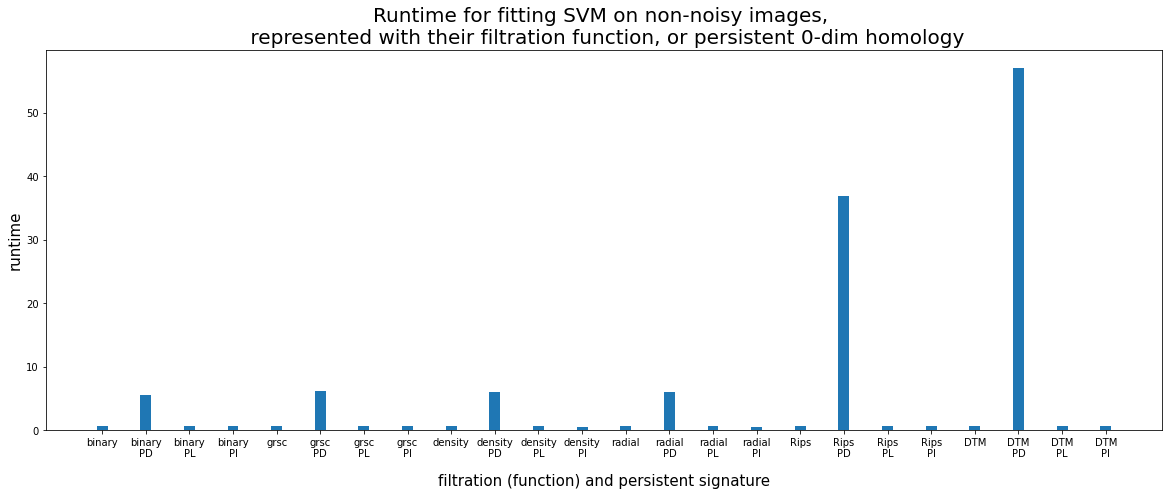

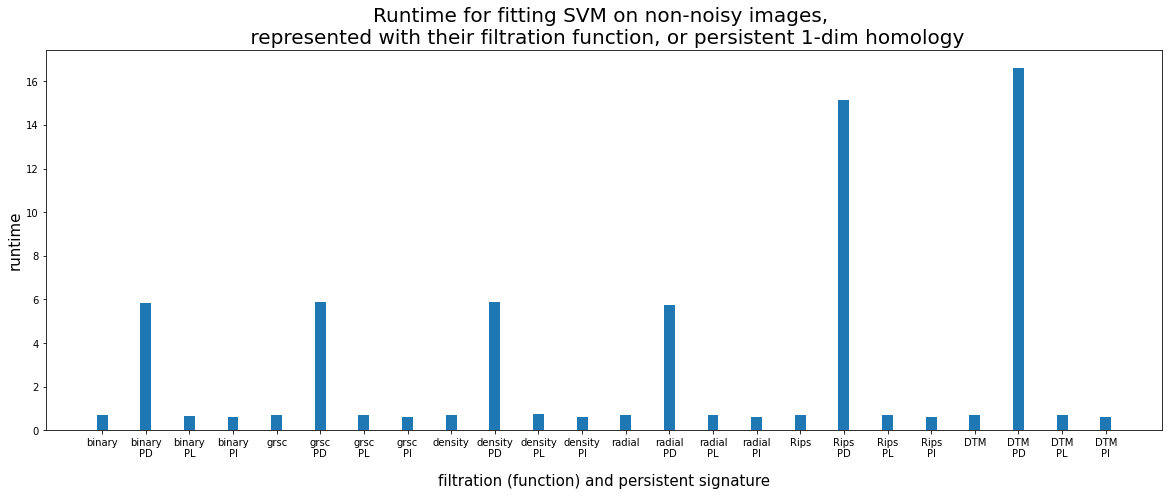

In [63]:
# How long does it take to fit SVM on non-noisy data, when images are represented with 
# their filtration functions or persistent homology information?

# Figure 1-2 x-axis.
filts_and_signs = [filt +  "\n" + sign 
                   for filt in filts
                   for sign in [" "] + signs]

# Figure 1: homdim0.
# Figure 1 y-axis, dictionary with elements as list of runtimes for fitting SVM on different representations of the non-noisy dataset.
runtime_svm_tune_parameters_data_homdim0 = [[runtime_svm_tune_parameters_data_filt[filt]] + [runtime_svm_tune_parameters_data_sign_homdim_filt[sign, "0-dim", filt]
                                                                                             for sign in signs] 
                                            for filt in filts]       
runtime_svm_tune_parameters_data_homdim0 = [j for i in runtime_svm_tune_parameters_data_homdim0
                                            for j in i]    
fig, axis = plt.subplots(figsize = (20, 7))
axis.bar(filts_and_signs, runtime_svm_tune_parameters_data_homdim0, width = 0.25)
axis.set_xticklabels(filts_and_signs) # fontsize = 12, rotation = 45, horizontalalignment = "right", verticalalignment = "top")
axis.set_title("Runtime for fitting SVM on non-noisy images, \n represented with their filtration function, or persistent 0-dim homology", fontsize = 20)
axis.set_xlabel("filtration (function) and persistent signature", fontsize = 15, labelpad = 15)
axis.set_ylabel("runtime", fontsize = 15)

# Figure 2: homdim1.
# Figure 2 y-axis, dictionary with elements as list of runtimes for fitting SVM on different representations of the non-noisy dataset.
runtime_svm_tune_parameters_data_homdim1 = [[runtime_svm_tune_parameters_data_filt[filt]] + [runtime_svm_tune_parameters_data_sign_homdim_filt[sign, "1-dim", filt]
                                                                                             for sign in signs] 
                                                             for filt in filts]       
runtime_svm_tune_parameters_data_homdim1 = [j for i in runtime_svm_tune_parameters_data_homdim1
                                            for j in i]  
fig, axis = plt.subplots(figsize = (20, 7))
axis.bar(filts_and_signs, runtime_svm_tune_parameters_data_homdim1, width = 0.25)
axis.set_xticklabels(filts_and_signs) # fontsize = 12, rotation = 45, horizontalalignment = "right", verticalalignment = "top")
axis.set_title("Runtime for fitting SVM on non-noisy images, \n represented with their filtration function, or persistent 1-dim homology", fontsize = 20)
axis.set_xlabel("filtration (function) and persistent signature", fontsize = 15, labelpad = 15)
axis.set_ylabel("runtime", fontsize = 15)

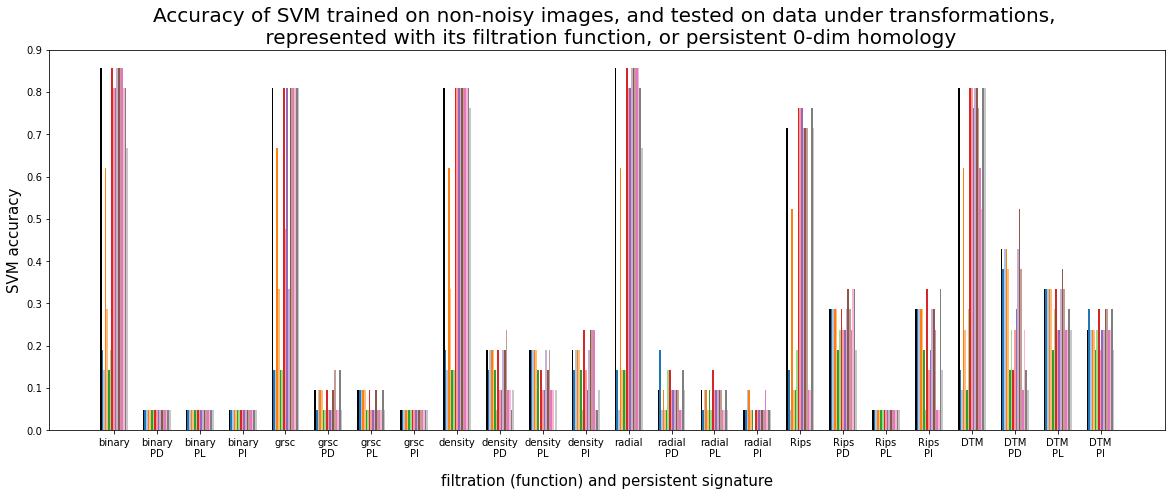

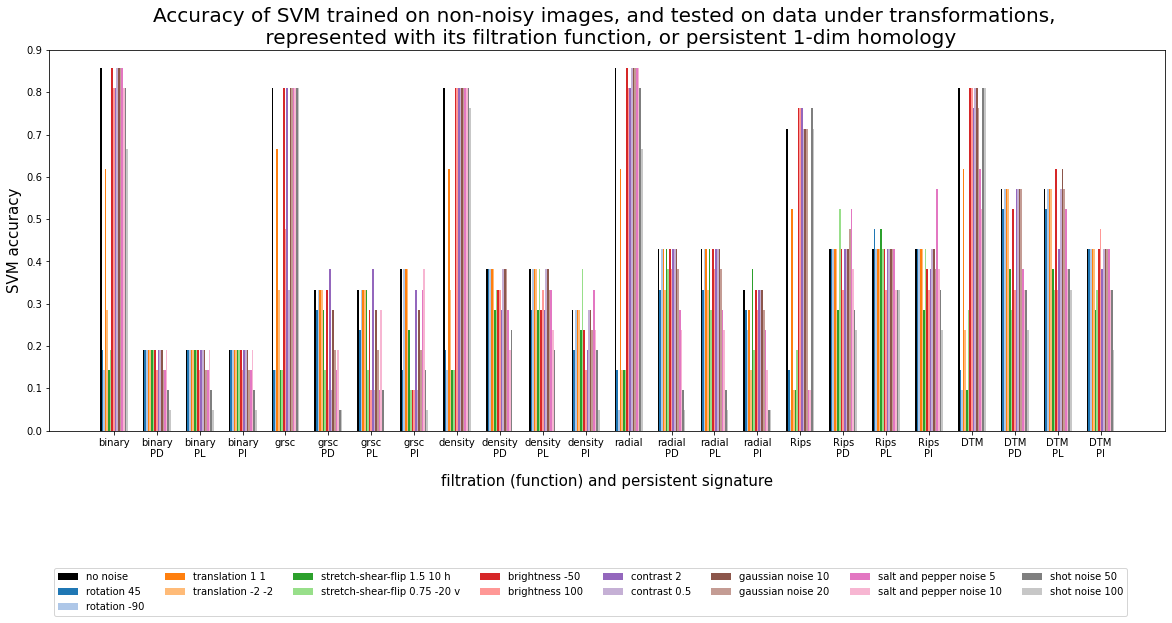

In [64]:
# How well does SVM trained on non-noisy data classifies the noisy dataset, when images are represented
# with their filtration function values, and persistent homology information?

# Figure 1: homdim0.
# Figure 1 y-axis, per different transformations (colors, or legend items), dictionary of lists.
svm_acc_data_homdim0_nonoise_trnsfs = {}
for trnsf in trnsfs:
    svm_acc_data_homdim0_nonoise_trnsfs[trnsf] = [[svm_acc_data_filt_trnsf[filt, trnsf]] + [svm_acc_data_sign_homdim_filt_trnsf[sign, "0-dim", filt, trnsf]
                                                                                            for sign in signs]
                                                  for filt in filts] 
    svm_acc_data_homdim0_nonoise_trnsfs[trnsf] = [j for i in svm_acc_data_homdim0_nonoise_trnsfs[trnsf]
                                                  for j in i]      
fig, axis = plot_bar_containers(filts_and_signs, svm_acc_data_homdim0_nonoise_trnsfs, trnsfs)
axis.set_xlabel("filtration (function) and persistent signature", fontsize = 15, labelpad = 15)
axis.set_ylabel("SVM accuracy", fontsize = 15)
axis.set_title("Accuracy of SVM trained on non-noisy images, and tested on data under transformations, \n represented with its filtration function, or 0-dim persistent homology", fontsize = 20)

# Figure 2: homdim1.
# Figure 2 y-axis, per different transformations (colors, or legend items), dictionary of lists.
svm_acc_data_homdim1_nonoise_trnsfs = {}
for trnsf in trnsfs:
    svm_acc_data_homdim1_nonoise_trnsfs[trnsf] = [[svm_acc_data_filt_trnsf[filt, trnsf]] + [svm_acc_data_sign_homdim_filt_trnsf[sign, "1-dim", filt, trnsf]
                                                                                            for sign in signs]
                                                   for filt in filts] 
    svm_acc_data_homdim1_nonoise_trnsfs[trnsf] = [j for i in svm_acc_data_homdim1_nonoise_trnsfs[trnsf]
                                                  for j in i]      
fig, axis = plot_bar_containers(filts_and_signs, svm_acc_data_homdim1_nonoise_trnsfs, trnsfs)
axis.set_xlabel("filtration (function) and persistent signature", fontsize = 15, labelpad = 15)
axis.set_ylabel("SVM accuracy", fontsize = 15)
axis.set_title("Accuracy of SVM trained on non-noisy images, and tested on data under transformations, \n represented with its filtration function, or 1-dim persistent homology", fontsize = 20)

# Figure 2 legend.
legend = axis.legend(trnsfs, loc = "lower left", bbox_to_anchor=(0, -0.5), ncol = 8, fontsize = 10)
for t, line in enumerate(legend.get_lines()):
    line.set_linewidth(4.0)
plt.show()

In [69]:
# Print SVM drop in accuracy LaTeX table.
# (turkevs2021 Table with results)

# Load the variables.
trnsfs_noisy = ["rotation 45", "rotation -90", "translation 1 1", "translation -2 -2", "stretch-shear-flip 1.5 10 h", "stretch-shear-flip 0.75 -20 v",
                "brightness -50", "brightness 100", "contrast 2", "contrast 0.5",
                "gaussian noise 10", "gaussian noise 20", "salt and pepper noise 5", "salt and pepper noise 10", "shot noise 50", "shot noise 100"]
with open("VARIABLES/svm_acc_data_filt_trnsf.pkl", "rb") as f:
    svm_acc_data_filt_trnsf = pickle.load(f)
with open("VARIABLES/svm_acc_data_sign_homdim_filt_trnsf.pkl", "rb") as f:
    svm_acc_data_sign_homdim_filt_trnsf = pickle.load(f)
num_homdims = 2
num_signs = 3


# Print LaTeX table with SVM drop in accuracy.
print("Drop in accuracy of SVM trained on non-noisy images, and tested on data under transformations, represented with its filtration function, or persistent homology: \n")
for filt in filts:
    print("\\multirow{", 1+num_homdims*num_signs, "}{2cm}{", filt, "} & - & -", end = " ")
    for trnsf in trnsfs_noisy:
        svm_acc_drop = ( svm_acc_data_filt_trnsf[filt, "no noise"] - svm_acc_data_filt_trnsf[filt, trnsf] ) / svm_acc_data_filt_trnsf[filt, "no noise"]
        if svm_acc_drop < 0:
            svm_acc_drop = 0            
        print("& {\color{red!", np.around(100 * svm_acc_drop, 2), "!blue} \\scalebox{", np.around(svm_acc_data_filt_trnsf[filt, "no noise"], 2), "}{\\rule{0.5cm}{0.5cm}}}", end = " ")
    print("\\\\")
    for h, homdim in enumerate(homdims):
        print("\\cline{2-", 1+1+1+len(trnsfs_noisy), "}")
        print("& \\multirow{", num_signs, "}{*}{", h, "}")
        for sign in signs:
            if sign == "PD":
                print("& $", sign, "$", end = " ")
            else:
                print("&& $", sign, "$", end = " ")
            for trnsf in trnsfs_noisy:
                svm_acc_drop = ( svm_acc_data_sign_homdim_filt_trnsf[sign, homdim, filt, "no noise"] - svm_acc_data_sign_homdim_filt_trnsf[sign, homdim, filt, trnsf] ) / svm_acc_data_sign_homdim_filt_trnsf[sign, homdim, filt, "no noise"]
                if svm_acc_drop < 0:
                    svm_acc_drop = 0                 
                print("& {\color{red!", "{:.2f}".format(100 * svm_acc_drop), "!blue} \\scalebox{", np.around(svm_acc_data_sign_homdim_filt_trnsf[sign, homdim, filt, "no noise"], 2), "}{\\rule{0.5cm}{0.5cm}}}", end = " ")
            print("\\\\")
    print("\n\\midrule \n")

Drop in accuracy of SVM trained on non-noisy images, and tested on data under transformations, represented with its filtration function, or persistent homology: 

\multirow{ 7 }{2cm}{ binary } & - & - & {\color{red! 77.78 !blue} \scalebox{ 0.86 }{\rule{0.5cm}{0.5cm}}} & {\color{red! 83.33 !blue} \scalebox{ 0.86 }{\rule{0.5cm}{0.5cm}}} & {\color{red! 27.78 !blue} \scalebox{ 0.86 }{\rule{0.5cm}{0.5cm}}} & {\color{red! 66.67 !blue} \scalebox{ 0.86 }{\rule{0.5cm}{0.5cm}}} & {\color{red! 83.33 !blue} \scalebox{ 0.86 }{\rule{0.5cm}{0.5cm}}} & {\color{red! 77.78 !blue} \scalebox{ 0.86 }{\rule{0.5cm}{0.5cm}}} & {\color{red! 0.0 !blue} \scalebox{ 0.86 }{\rule{0.5cm}{0.5cm}}} & {\color{red! 5.56 !blue} \scalebox{ 0.86 }{\rule{0.5cm}{0.5cm}}} & {\color{red! 5.56 !blue} \scalebox{ 0.86 }{\rule{0.5cm}{0.5cm}}} & {\color{red! 0.0 !blue} \scalebox{ 0.86 }{\rule{0.5cm}{0.5cm}}} & {\color{red! 0.0 !blue} \scalebox{ 0.86 }{\rule{0.5cm}{0.5cm}}} & {\color{red! 0.0 !blue} \scalebox{ 0.86 }{\rule{0.5cm}{0.

In [71]:
# Print SVM drop in accuracy LaTeX table.
# (turkevs2021 poster homdim1 Table with results).

# Print LaTeX table with SVM drop in accuracy.
print("Drop in accuracy of SVM trained on non-noisy images, and tested on data under transformations, \n represented with its filtration function, or 1-dim persistent homology: \n")
for trnsf in trnsfs_noisy:
    print(trnsf) #, "&", end = " ")
    for filt in filts:
        svm_acc_drop = ( svm_acc_data_filt_trnsf[filt, "no noise"] - svm_acc_data_filt_trnsf[filt, trnsf] ) / svm_acc_data_filt_trnsf[filt, "no noise"]
        if svm_acc_drop < 0:
            svm_acc_drop = 0            
        print("& \\raisebox{0.05cm}{\color{red!", np.around(100 * svm_acc_drop, 2), "!blue} \\scalebox{", np.around(svm_acc_data_filt_trnsf[filt, "no noise"], 2), "}{\\rule{0.5cm}{0.5cm}}}", end = " ")
        h = 0
        homdim = "1-dim"
        for sign in signs:
            svm_acc_drop = ( svm_acc_data_sign_homdim_filt_trnsf[sign, homdim, filt, "no noise"] - svm_acc_data_sign_homdim_filt_trnsf[sign, homdim, filt, trnsf] ) / svm_acc_data_sign_homdim_filt_trnsf[sign, homdim, filt, "no noise"]
            if svm_acc_drop < 0:
                svm_acc_drop = 0                 
            print("& \\raisebox{0.05cm}{\color{red!", "{:.2f}".format(100 * svm_acc_drop), "!blue} \\scalebox{", np.around(svm_acc_data_sign_homdim_filt_trnsf[sign, homdim, filt, "no noise"], 2), "}{\\rule{0.5cm}{0.5cm}}}", end = " ")
    print("\\\\")
    print()

Drop in accuracy of SVM trained on non-noisy images, and tested on data under transformations, 
 represented with its filtration function, or 1-dim persistent homology: 

rotation 45
& \raisebox{0.05cm}{\color{red! 77.78 !blue} \scalebox{ 0.86 }{\rule{0.5cm}{0.5cm}}} & \raisebox{0.05cm}{\color{red! 0.00 !blue} \scalebox{ 0.19 }{\rule{0.5cm}{0.5cm}}} & \raisebox{0.05cm}{\color{red! 0.00 !blue} \scalebox{ 0.19 }{\rule{0.5cm}{0.5cm}}} & \raisebox{0.05cm}{\color{red! 0.00 !blue} \scalebox{ 0.19 }{\rule{0.5cm}{0.5cm}}} & \raisebox{0.05cm}{\color{red! 82.35 !blue} \scalebox{ 0.81 }{\rule{0.5cm}{0.5cm}}} & \raisebox{0.05cm}{\color{red! 14.29 !blue} \scalebox{ 0.33 }{\rule{0.5cm}{0.5cm}}} & \raisebox{0.05cm}{\color{red! 28.57 !blue} \scalebox{ 0.33 }{\rule{0.5cm}{0.5cm}}} & \raisebox{0.05cm}{\color{red! 62.50 !blue} \scalebox{ 0.38 }{\rule{0.5cm}{0.5cm}}} & \raisebox{0.05cm}{\color{red! 76.47 !blue} \scalebox{ 0.81 }{\rule{0.5cm}{0.5cm}}} & \raisebox{0.05cm}{\color{red! 0.00 !blue} \scalebox{ 

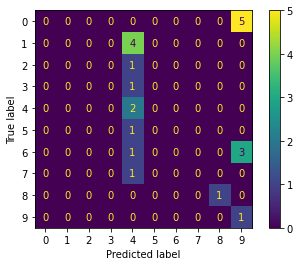

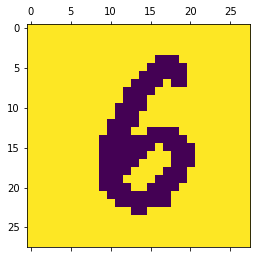

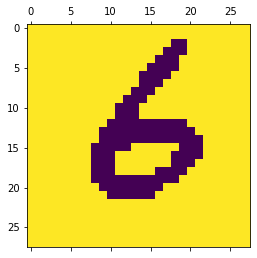

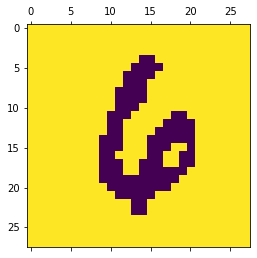

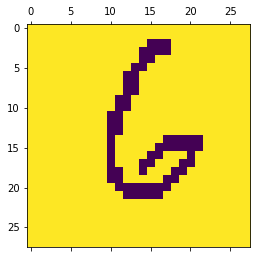

In [77]:
# How does SVM trained on non-noisy misclassify the noisy dataset, when images are represented 
# with their given filtration function values, and persistent homology information?
sign_temp = "PD"
homdim_temp = "1-dim"
filt_temp = "binary"
trnsf_temp = "no noise"
plot_confusion_matrix(svm_classifier_data_sign_homdim_filt[sign_temp, homdim_temp, filt_temp], 
                      data_sign_homdim_filt_trnsf_test[sign_temp, homdim_temp, filt_temp, trnsf_temp],
                      labels_test) 
plt.show()

# Plot all images (represented with their filtration function values) in the dataset, with the given label.
label_temp = 6
for i, data_point_test in enumerate(data_filt_trnsf_test[filt_temp, trnsf_temp]):
    if labels_test[i] == label_temp:
        plt.matshow(data_point_test.reshape((num_x_pixels, num_y_pixels)))

In [78]:
end_time = time.time()
print("Total runtime of the notebook = ", end_time - start_time)

Total runtime of the notebook =  6550.25859951973
